In [2]:
import os, glob, json
import pickle
import pandas as pd
pd.set_option('display.max_colwidth', None)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import numpy as np
from scipy import stats
from collections import Counter, defaultdict
import random, math
from tqdm import tqdm
import platform

# print machine name
machine_name = platform.node().split(".")[0]
print(machine_name)

# print available scratch directories
print(" ".join(os.listdir(f"/{machine_name}")))
scr_dir = os.listdir(f"/{machine_name}")[0]

DISK_IO_DIR = "/{}/{}/yiweil".format(machine_name,scr_dir)
print(DISK_IO_DIR)
if not os.path.exists(DISK_IO_DIR):
    os.mkdir(DISK_IO_DIR)

john11
scr1
/john11/scr1/yiweil


# Load utils

In [2]:
from utils import *
STANZA_DIR

Found 422 conversations which are manually checked to be true climate convos.


'/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner_embed_removed'

In [3]:
def is_valid(utt):
    return not utt.meta['written_by_bot'] \
    and not utt.text == '[deleted]' \
    and not utt.text == '[removed]' \
    and utt.meta['is_generic'] == False

def fewer_n_words(utt,n=20):
    return len(utt.text.strip().split()) < n

def OP_not_deleted(corp,convo_id):
    return corp.get_utterance(convo_id).speaker.id is not None

delta_awarding_ids = set(deltalog['awarding_utt_id'].values)
awarding2awarded = dict(zip(deltalog['awarding_utt_id'],deltalog['awarded_utt_id']))
def OP_deltas(corp,convo_id):
    convo = corp.get_conversation(convo_id)
    op_id = corp.get_utterance(convo_id).speaker.id
    op_utt_ids = set([utt_id for utt_id in convo.get_utterance_ids()
                      if corp.get_utterance(utt_id).speaker.id == op_id])
    #print(op_id)
    #print(op_utt_ids)
    return op_utt_ids.intersection(delta_awarding_ids)

def has_enough_challengers(corp,convo_id,n=10):
    num_challengers = len(corp.get_conversation(convo_id).get_speaker_ids())
    return num_challengers >= n

def has_enough_prior_failed_args(corp,convo_id,n=3,verbose=False):
    convo = corp.get_conversation(convo_id)
    OP_id = corp.get_utterance(convo_id).speaker.id
    in_order_utts = [utt for utt in convo.get_chronological_utterance_list()]
    last_OP_utt = [utt for utt in in_order_utts if utt.speaker.id == OP_id][-1]
    utts_prior_to_last_OP_utt = in_order_utts[:in_order_utts.index(last_OP_utt)]
    utts_prior_delta_counts = Counter([utt.meta['is_awarded_delta'] for utt in utts_prior_to_last_OP_utt])
    
    if verbose:
        print('conversation URL:',convo.meta['url'])
        print('OP username:',OP_id)
        print('last OP reply:',last_OP_utt.meta['permalink'])
        print('delta counts of prior utts:',utts_prior_delta_counts)
    return utts_prior_delta_counts[False] >= n

def has_enough_counterarguments(corp,convo_id):
    return has_enough_challengers(corp,convo_id) and has_enough_prior_failed_args(corp,convo_id)

def is_generic_from_cache(utt):
    return utt.meta['is_generic']

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

def get_doc_freq_matrix(texts_array):
    """
    @param: `texts_array` 2-d array with each row representing the tokenized content of an utterance
    @return: a document frequency matrix over the vocabular of `texts_array`
    """
    DF = defaultdict(int)
    for i in range(len(texts_array)):
        doc = texts_array[i]
        for w in doc:
            DF[w] += 1
    return DF

def get_lemmas_with_heads(stanza_json_parse, exclude_punc=True):
    if exclude_punc:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent if w['upos'] != 'PUNCT']
    else:
        return [f"{w['lemma']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['lemma']}"
                if w['lemma'] is not None 
                else f"{w['text']}_{stanza_json_parse[ix_sent][int(w['head'])-1]['text']}"
                for ix_sent,sent in enumerate(stanza_json_parse)
                for w in sent]

def get_counts_for_lor(corpus, sample1_ids, priors, save_prefix, 
                       stanza_dir='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner',
                       verbose=False, cache=True, background_only=False, skip_background=False,
                       ngram_range=(1,2), min_df=5, do_lowercase=True, 
                       upos=False, xpos=False, depparse=True, heads=False):
    
    if not cache:
        counts_dict = {}
        if not background_only:
            print(f"Creating count matrix for +/- samples with ngram range {ngram_range}, min_df = {min_df}, lowercasing = {do_lowercase}, upos = {upos}, xpos = {xpos}, depparse = {depparse}, and heads = {heads}...")

            # create text arrays
            corpus1_texts, corpus2_texts = [], []
            for utt in tqdm(corpus.iter_utterances()):
                if utt.id[:2]=='t1':
                    try:
                        json_obj = get_stanza_json(utt,stanza_dir=stanza_dir)
                        if json_obj is not None:
                            subbed_json_obj = sub_url_with_domain(utt)
                            if utt.id in sample1_ids:
                                if upos:
                                    corpus1_texts.append([f"{x['lemma']}_{x['upos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['upos']}"
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                                elif xpos:
                                    corpus1_texts.append([f"{x['lemma']}_{x['xpos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['xpos']}"
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                                elif depparse:
                                    corpus1_texts.append([f"{x['lemma']}_{x['deprel']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['deprel']}"
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                                elif heads:
                                    corpus1_texts.append(get_lemmas_with_heads(subbed_json_obj['parse']))
                                else:
                                    corpus1_texts.append([x['lemma'] 
                                                                   if x['lemma'] is not None 
                                                                   else x['text']
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                            else:
                                if upos:
                                    corpus2_texts.append([f"{x['lemma']}_{x['upos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['upos']}"
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                                elif xpos:
                                    corpus2_texts.append([f"{x['lemma']}_{x['xpos']}" 
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['xpos']}"
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                                elif depparse:
                                    corpus2_texts.append([f"{x['lemma']}_{x['deprel']}"
                                                                   if x['lemma'] is not None 
                                                                   else f"{x['text']}_{x['deprel']}"
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                                elif heads:
                                    corpus2_texts.append(get_lemmas_with_heads(subbed_json_obj['parse']))
                                else:
                                    corpus2_texts.append([x['lemma'] 
                                                                   if x['lemma'] is not None 
                                                                   else x['text']
                                                                   for sent in subbed_json_obj['parse']
                                                                   for x in sent if x['upos'] != 'PUNCT'])
                    except FileNotFoundError:
                        pass
            del corpus # free up memory
            print(f'\tFound {len(corpus1_texts)} non-empty texts in sample 1; {len(corpus2_texts)} non-empty texts in sample 2.')
            if verbose:
                print('\tExample corpus1 texts:',corpus1_texts[:3])
                print('\tExample corpus2 texts:',corpus2_texts[:3])
                
            DF1 = get_doc_freq_matrix(corpus1_texts)
            DF2 = get_doc_freq_matrix(corpus2_texts)
            union_vocab = set(DF1.keys()) | set(DF2.keys())
            df_to_exclude = set([w for w in union_vocab if DF1[w]<=min_df or DF2[w]<=min_df])
            print(f'\tExcluding {len(df_to_exclude)} terms out of union vocab of size {len(union_vocab)} for not meeting min_df threshold ({min_df}).')
            if verbose:
                print('\t\tExample words in union vocab:',list(union_vocab)[:3])
                print('\t\tExample words excluded:',list(df_to_exclude)[:3])
            
            # create; save count dictionaries from CV
            for corp_ in ['corpus1','corpus2']:
#                 vectorizer = CountVectorizer(analyzer='word', ngram_range=ngram_range, 
#                                              min_df=min_df, lowercase=do_lowercase, token_pattern=r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
#                 X = vectorizer.fit_transform(corpus1_texts) if corp_ == 'corpus1' \
#                     else vectorizer.fit_transform(corpus2_texts)
#                 vocab = vectorizer.get_feature_names()
#                 counts = np.sum(X,axis=0)
#                 count_dict = Counter({vocab[i]: counts[0,i] for i in range(len(vocab))
#                                   if len(vocab[i]) > 0})
#                 counts_dict[corp_] = count_dict
                if corp_ == 'corpus1':
                    count_dict = Counter([tok for doc in corpus1_texts for tok in doc])
                else:
                    count_dict = Counter([tok for doc in corpus2_texts for tok in doc])
                count_dict = {w: count_dict[w] for w in count_dict if w not in df_to_exclude}
                counts_dict[corp_] = count_dict
                savename = os.path.join('lor_count_mats',
                                     f'{save_prefix}_{corp_}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
    #             if not os.path.exists('lor_count_mats'):
    #                 os.mkdir('lor_count_mats')
                pickle.dump(count_dict,open(savename,'wb'))
                print(f"\tSaved counts of {corp_} (N types = {len(count_dict)}) to {savename}.")
        else:
            print("Skipping directly to creation of background corpus counts matrices.")
        
        if not skip_background:
            # create texts array
            prior_texts = []
            for prior_corp in priors:
                for utt in tqdm(prior_corp.iter_utterances()):
                    json_obj = get_stanza_json(utt)
                    if json_obj is not None:
                        if upos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['upos']}" 
                                                         if x['lemma'] is not None 
                                                         else f"{x['text']}_{x['upos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif xpos:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['xpos']}" 
                                                         if x['lemma'] is not None 
                                                        else f"{x['text']}_{x['xpos']}"
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                        elif depparse:
                            prior_texts.append(' '.join([f"{x['lemma']}_{x['deprel']}" 
                                                         if x['lemma'] is not None 
                                                           else f"{x['text']}_{x['deprel']}"
                                                           for sent in json_obj['parse']
                                                           for x in sent if x['upos'] != 'PUNCT']))
                        elif heads:
                            prior_texts.append(' '.join(get_lemmas_with_heads(json_obj['parse'])))
                        else:
                            prior_texts.append(' '.join([x['lemma'] 
                                                         if x['lemma'] is not None 
                                                           else x['text']
                                                         for sent in json_obj['parse']
                                                         for x in sent if x['upos'] != 'PUNCT']))
                del prior_corp # free up memory when done iterating
            del priors # free up memory when done iterating
            #del corp_to_analyze['switchboard']
            #del corp_to_analyze['gen_reddit']
            if verbose:
                print('Example prior corpus texts:',prior_texts[:3])

            # create; save count dictionary
            if len(prior_texts) > 0:
                vectorizer_prior = CountVectorizer(analyzer='word', ngram_range=ngram_range, min_df=min_df, 
                                                   lowercase=do_lowercase)
                X_prior = vectorizer_prior.fit_transform(prior_texts)
                vocab_prior = vectorizer_prior.get_feature_names()
                print(len(vocab_prior))
                #pickle.dump(X_prior,open('X_prior.pkl','wb'))
                counts_prior = np.sum(X_prior,axis=0)
                count_dict_prior = Counter({vocab_prior[i]: counts_prior[0,i] for i in range(len(vocab_prior))
                                   if len(vocab_prior[i]) > 0})
                counts_dict['prior'] = count_dict_prior

                savename_prior = os.path.join('lor_count_mats',
                                         f'{save_prefix}_prior_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
                pickle.dump(count_dict_prior,open(savename_prior,'wb'))
                print(f"\tSaved counts of prior (N types = {len(count_dict_prior)}) to {savename_prior}.")
            else:
                print("\tNo prior corpora passed.")
                counts_dict['prior'] = Counter()
        
        return counts_dict
        
    else:
        print("Loading counters from cache...")
        counts_dict = {}
        for save_infix in ['corpus1','corpus2','prior']:
            savename = os.path.join('lor_count_mats',
                                 f'{save_prefix}_{save_infix}_ngrams={ngram_range}_min_df={min_df}_lowercase={do_lowercase}_upos={upos}_xpos={xpos}_depparse={depparse}_heads={heads}')
            try:
                counts_dict[save_infix] = pickle.load(open(savename,'rb'))
            except FileNotFoundError:
                pass
        return counts_dict        

In [5]:
PRIOR_WEIGHT = 1
COUNTS1_WEIGHT = 1 # use for +delta
COUNTS2_WEIGHT = 1

def do_weighted_lor(counts1, counts2, counts_prior, 
                    prior_weight=PRIOR_WEIGHT, counts1_weight=COUNTS1_WEIGHT, counts2_weight=COUNTS2_WEIGHT, 
                    verbose=False):
    
    counts1,counts2 = counts1.copy(),counts2.copy()
    if type(counts1) != Counter:
        counts1 = Counter(counts1)
        counts2 = Counter(counts2)
    prior = counts_prior + counts1 + counts2

    sigmasquared = defaultdict(float)
    sigma = defaultdict(float)
    delta = defaultdict(float)

    for word in prior.keys():
        prior[word] = int(prior[word]/prior_weight + 0.5)

    for word in counts2.keys():
        counts1[word] = int(counts1[word]/counts1_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    for word in counts1.keys():
        counts2[word] = int(counts2[word]/counts2_weight + 0.5)
        if prior[word] == 0:
            prior[word] = 1

    n1  = sum(counts1.values())
    n2  = sum(counts2.values())
    nprior = sum(prior.values())
    print("Size of class1:",n1)
    print("Size of class2:",n2)
    print("Size of prior:",nprior)

    for word in prior.keys():
        if prior[word] > 0:
            l1 = float(counts1[word] + prior[word]) / (( n1 + nprior ) - (counts1[word] + prior[word]))
            l2 = float(counts2[word] + prior[word]) / (( n2 + nprior ) - (counts2[word] + prior[word]))
            sigmasquared[word] =  1/(float(counts1[word]) + float(prior[word])) + 1/(float(counts2[word]) + float(prior[word]))
            sigma[word] =  math.sqrt(sigmasquared[word])
            delta[word] = ( math.log(l1) - math.log(l2) ) / sigma[word]

    if verbose:
        for word in sorted(delta, key=delta.get):
            print(word)
            print("%.3f" % delta[word])
            
    return delta

In [6]:
# og_dir = '/juice/scr/yiweil/Green-American-Lexicon/2_data_exploration'
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# import customized_fighting_words
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

In [7]:
# import importlib 
# os.chdir('/juice/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit/convokit')
# importlib.reload(customized_fighting_words)
# from customized_fighting_words import FightingWords
# os.chdir(og_dir)

# Load/filter ConvoKit corpus

Available corpora to load:
* entirety of r/changemyview from inception to 9/24/2021 (`full_cmv`)
* comments-only subset of r/changemyview where comments w/ and without deltas have been evenly matched for length, depth, elapsed time, etc. (`matched_cmv_subsample`)
* subset of the above, further subsetted to comments attached to climate-change-related posts (`matched_cc_cmv_subsample`)
* random sample of posts & comments from top 100 high-activity subreddits (`gen_reddit`)
* switchboard corpus

In [6]:
from convokit import Corpus#, Speaker, download
AVAILABLE_CORP = ['full_cmv','matched_cmv_subsample','gen_reddit']
corp_name_to_filepath = {
                         'full_cmv': '/u/scr/yiweil/my-cmv-corpus_1-1-2010_to_09-24-2021',
                         'matched_cmv_subsample': '/u/scr/yiweil/subsampled_cmv_corpus',
                         'gen_reddit':'/u/scr/yiweil/datasets/convokit/reddit-corpus-small',
                         'switchboard':'/sailhome/yiweil/.convokit/downloads/switchboard-corpus'
                        }

In [10]:
corp_to_analyze = {'matched_cmv_subsample': None}#,'gen_reddit': None,'switchboard':None}
#corp_to_analyze.update({'matched_cmv_subsample': None})

for corp_name in corp_to_analyze:
    if corp_to_analyze[corp_name] is None:
        print("Loading corpus: {}...".format(corp_name))
        corp_to_analyze[corp_name] = Corpus(filename=corp_name_to_filepath[corp_name])
        corp_to_analyze[corp_name].print_summary_stats()
        print('\n')
        
        # Update full meta for conversations if corpus is not `matched_cc_cmv_subsample` (contains comments only, by design)
        if corp_name in {'full_cmv','matched_cmv_subsample','matched_cc_cmv_subsample','gen_reddit','switchboard'}:
            for utt in corp_to_analyze[corp_name].iter_utterances():
                if utt.id == utt.conversation_id: # not a comment but a post
                    convo = corp_to_analyze[corp_name].get_conversation(utt.id)
                    meta_dict = corp_to_analyze[corp_name].get_utterance(utt.id).meta
                    for key in meta_dict:
                        corp_to_analyze[corp_name].get_conversation(utt.id).add_meta(key, meta_dict[key])
                    convo.speaker = utt.speaker
                        
        print("Filtering {}...".format(corp_name))
        corp_to_analyze[corp_name] = filter_bots_mods_removed(corp_to_analyze[corp_name])
        print('\n')
        
        if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
            print("Filtering out generic utterances from {}...".format(corp_name))
            corp_to_analyze[corp_name] = filter_generic_comments(
                corp_to_analyze[corp_name], 
                GENERIC_REGEX_PATS,
                fname=f'generic_dict_{corp_name}.pkl')
            corp_to_analyze[corp_name].print_summary_stats()
            print('\n')
            
        print("Removing footnotes and in-line embedded text from {}...".format(corp_name))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if utt.id != utt.conversation_id:
                utt.text = cleanup(utt.text)
                
        print("Annotating with climate change information...")
        for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
            if convo.id not in c_id2other_cc_label:
                c_id2other_cc_label[convo.id] = 'non-cc'
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_cc_related_gold'] = utt.conversation_id in climate_convo_idxs_gold
            utt.meta['other_cc_label'] = c_id2other_cc_label[utt.conversation_id]
        for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
            convo.meta['other_cc_label'] = c_id2other_cc_label[convo.id]
        print("Distribution of climate change macro labels:\n")
        print("\t",Counter([utt.meta['is_cc_related_gold'] 
                            for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))
        print("Distribution of climate change micro labels:")
        print("\t",Counter([utt.meta['other_cc_label'] 
                            for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))

Loading corpus: matched_cmv_subsample...
Number of Speakers: 43271
Number of Utterances: 205084
Number of Conversations: 44346


Filtering matched_cmv_subsample...
Filtering speakers with usernames ending in '-bot'...
Found 184612 non-deleted/removed utterances not written by a bot or moderator.


Filtering out generic utterances from matched_cmv_subsample...
Filtering to 204946 non-generic comments.
Number of Speakers: 43271
Number of Utterances: 205084
Number of Conversations: 44346


Removing footnotes and in-line embedded text from matched_cmv_subsample...


205084it [00:06, 31444.81it/s]


Annotating with climate change information...


44346it [00:00, 578309.74it/s]
205084it [00:02, 89845.08it/s]
44346it [00:00, 159019.32it/s]


Distribution of climate change macro labels:



205084it [00:00, 535058.49it/s]


	 Counter({False: 203124, True: 1960})
Distribution of climate change micro labels:


205084it [00:00, 580130.25it/s]

	 Counter({'non-cc': 203124, 'other': 488, 'meta': 264, 'doom': 220, 'vegetarianism': 182, 'renewables/energy': 175, 'overpopulation': 167, 'government/politics': 165, 'conservation': 109, 'economy': 91, 'lifestyle': 75, 'adaptation': 9, 'food (non-vegetarianism)': 9, 'ethics/morality': 6})


In [8]:
regression_convo_ids = pickle.load(open('regression_convo_ids.pkl','rb'))
regression_utt_ids = pickle.load(open('regression_utt_ids.pkl','rb'))

print(len(regression_convo_ids),len(regression_utt_ids))

9034 43411


## Sanity checks

In [169]:
# # `matched_cc_cmv_subsample` is subset of `matched _cmv_subsample`
# cc_ids = set(corp_to_analyze['matched_cc_cmv_subsample'].get_utterance_ids())
# all_cmv_ids = set(corp_to_analyze['matched_cmv_subsample'].get_utterance_ids())
# cc_ids.issubset(all_cmv_ids)

# Parsing (w/ Stanza)

Check if any parsing needs to be done:

In [160]:
processed = glob.glob(os.path.join(STANZA_DIR,'*.json'))
processed_ids = set([x.split('/')[-1].split('.json')[0] for x in processed])
print('Already processed {} utterances.'.format(len(processed)))

corp_to_process = None
#missing_ids = regression_utt_ids.difference(processed_ids)
missing_ids = set(corp_to_analyze['matched_cmv_subsample'].get_utterance_ids()).difference(processed_ids)
print("\tFound {} missing ids.".format(len(missing_ids)))
    
if len(missing_ids) > 0:
    print("Creating separate corpus with utterances not yet processed...")
    corpus_to_process = corp_to_analyze['matched_cmv_subsample'].filter_utterances_by(
        lambda utt: utt.id in missing_ids)
    corpus_to_process.print_summary_stats()

Already processed 757953 utterances.
	Found 25139 missing ids.
Creating separate corpus with utterances not yet processed...
Number of Speakers: 15702
Number of Utterances: 25139
Number of Conversations: 24266


In [161]:
len(missing_ids)/len(corp_to_analyze['matched_cmv_subsample'].get_utterance_ids())

0.13627394646400035

In [21]:
corp_to_process.dump('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/corp_to_process_matched_cmv_subsample.pkl')

Only continue past this point if missing ids exist:

In [34]:
# import stanza
# stanza.download('en') # download English model
# nlp = stanza.Pipeline('en', use_gpu= True)

In [30]:
# Perform parsing
processed_dirname = f'{STANZA_DIR}'
assert processed_dirname == '/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output_with_ner'

if not os.path.exists(processed_dirname):
    os.mkdir(processed_dirname)

for corp_name in corp_to_process:
    for utt in tqdm(corp_to_process[corp_name].iter_utterances()):
    #     savename = os.path.join(
    #         DISK_IO_DIR,processed_dirname,"{}.json".format(
    #             utt.id))
        savename = os.path.join(processed_dirname,"{}.json".format(
                utt.id))
        if len(utt.text) > 0:
            print(utt.text)
            try:
                doc = nlp(utt.text)
                print('test')
                jsonlist = {'parse': [[{
                                            'id': word.id,
                                            'text': word.text,
                                            'lemma': word.lemma,
                                            'upos': word.upos,
                                            'xpos': word.xpos,
                                            'feats': word.feats,
                                            'head': word.head,
                                            'deprel': word.deprel,
                                            'start_char': word.start_char,
                                            'end_char': word.end_char
                                        } 
                            for word in sent.words]
                            for sent in doc.sentences],
                            'ents': [{
                                        "text": ent.text,
                                        "type": ent.type,
                                        "start_char": ent.start_char,
                                        "end_char": ent.end_char
                                    }
                                    for ent in doc.ents]}
                with open(savename,'w') as f:
                    json.dump(jsonlist,f)
            except AssertionError:
                pass
        #break

1it [00:00,  8.28it/s]


-


0it [00:00, ?it/s]

/


1it [00:00,  8.98it/s]


Perform some file management:

In [ ]:
# zip up within local machine dir
tar -czf stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz stanza_processed_matched_filtered_cc_cmv_corpus

# move to /juice dir
export JUICE_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration
echo $JUICE_DIR # check
mv stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz $JUICE_DIR

# unzip to /juice dir
tar -xzf $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus.tar.gz -C $JUICE_DIR

# move contents to central dir
export STANZA_DIR=/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/combined_stanza_output#_with_ner
mv $JUICE_DIR/stanza_processed_matched_filtered_cc_cmv_corpus/* $JUICE_DIR/STANZA_DIR/

In [105]:
# Check for corrupted and/or missing json files in unzipped directory
JUICE_DIR='/u/scr/yiweil/Green-American-Lexicon/2_data_exploration'
STANZA_DIR=os.path.join(JUICE_DIR,'combined_stanza_output_with_ner')
all_fnames = glob.glob(os.path.join(STANZA_DIR,'*.json'))
problematic_fnames = []
for fname in tqdm(all_fnames):
    try:
        json.load(open(fname,'r'))
    except EOFError:
        problematic_fnames.append(fname)
print("Found {} problematic json files among {} total files in unzipped /juice dir.".format(
    len(problematic_fnames), len(all_fnames)))

corpus_to_process = corp_to_analyze['matched_cc_cmv_subsample']
ids_needed = [utt.id for utt in corpus_to_process.iter_utterances() if len(utt.text) > 0]
missing_ids = set(ids_needed).difference(set([x.split('/')[-1].split('.json')[0] for x in all_fnames]))
print("Found {} missing ids from {} utterance ids total in corpus to parse.".format(
    len(missing_ids), len(ids_needed)
))

100%|██████████| 6349/6349 [00:05<00:00, 1115.49it/s]

Found 0 problematic json files among 6349 total files in unzipped /juice dir.
Found 0 missing ids from 6349 utterance ids total in corpus to parse.


# Find climate-change related conversations

In [11]:
# def remove_special_chars(s):
#     return re.sub('[^A-Za-z]+', ' ', s)

# def contains_keyword(s,keyword_set,ignore_case=True):
#     if ignore_case:
#         s = s.lower()
#     pat = re.compile(r'\b(' + (r'|'.join(keyword_set)) + r')\b')
#     #print(set(pat.findall(remove_special_chars(s))).intersection(keyword_set))
#     return len(set(pat.findall(s)).intersection(keyword_set)) > 0

# with open('../1_data_collection/keywords_high_precision.txt','r') as f:
#     CLIMATE_KEYWORDS = f.read().splitlines()
# print(CLIMATE_KEYWORDS)

# def get_op(corp,convo_idx):
#     return corp.get_utterance(convo_idx)

# def get_op_title(op):
#     return op.meta['title']

# def get_op_text(op):
#     return op.text

In [12]:
# # import pandas as pd
# # manual_checked = pd.read_csv('full_cmv_high_prec_climate_kw_in_title_manual_checked.tsv',sep='\t')
# # manual_checked = manual_checked.append(pd.read_csv('tf_idf_predicted_true_manual_checked.tsv',sep='\t'),
# #                      ignore_index=True)
# manual_checked = pd.read_csv('is_cc_related_gold_manual_checked.tsv',sep='\t')
# manual_checked['is_true'] = manual_checked['is_true'].apply(
#     lambda x: {'f':'false','m':'meta','d':'doom','r':'renewables/energy','v':'vegetarianism',
#               'p':'overpopulation','g':'government/politics','c':'conservation','e':'economy',
#               'l':'lifestyle','foo':'food (non-vegetarianism)','a':'adaptation',
#               'mor':'ethics/morality','gm':'government/politics'}[x]
#                 if not pd.isnull(x) else 'other')
# manual_checked['label'] = manual_checked['label'].apply(lambda x: {'s':'skeptic','st':'indifferent'}[x] 
#                                                        if x in {'s','st'} else 'other')
# gold_df = manual_checked.loc[manual_checked['is_true']!='false']
# climate_convo_idxs_gold = gold_df['id'].values
# print(f'Found {len(climate_convo_idxs_gold)} conversations which are manually checked to be true climate convos.')

# # Add meta field for whether utterance belongs to climate change-related conversation
# c_id2other_cc_label = dict(zip(gold_df['id'].values,gold_df['is_true'].values))
# for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
#     if convo.id not in c_id2other_cc_label:
#         c_id2other_cc_label[convo.id] = 'non-cc'

# for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#     utt.meta['is_cc_related_gold'] = utt.conversation_id in climate_convo_idxs_gold
#     utt.meta['other_cc_label'] = c_id2other_cc_label[utt.conversation_id]
# for convo in tqdm(corp_to_analyze[corp_name].iter_conversations()):
#     convo.meta['other_cc_label'] = c_id2other_cc_label[convo.id]
# print(Counter([utt.meta['is_cc_related_gold'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))
# print(Counter([utt.meta['other_cc_label'] for utt in tqdm(corp_to_analyze[corp_name].iter_utterances())]))

In [ ]:
# Find other keywords related to environment

# Approach 1: Empath

In [53]:
from empath import Empath
lexicon = Empath()

RENEWABLES_SEEDS = ['renewable','solar panel','wind farm','clean energy']
ENVIRO_SEEDS = ['environmentalism','ecosystem','sustainability','natural habitat','habitat loss']
VAX_SEEDS = ['vaccine','vaccination','anti-vax','anti-vaccine','antivax','antivaccine']
#lexicon.create_category("renewables_reddit",RENEWABLES_SEEDS,model="reddit")
#lexicon.create_category("enviro_reddit",ENVIRO_SEEDS,model="reddit")
lexicon.create_category("vax_reddit",VAX_SEEDS,model="reddit")

["vaccination", "vaccines", "anti-vax", "anti-vaxxers", "anti-vaccination", "vaccinations", "anti-vaccine", "antivaxxers", "anti-vaxers", "anti-vaccers", "vaccine", "anti_vaxxers", "anti-vax_movement", "anti-vaxxer", "anti_vaxers", "vaccinating", "anti-vaccine_movement", "antivax", "flu_shots", "vaccinating", "anti_vaccine", "anti-vaccine_people", "Anti-vaxxers", "flu_vaccine", "pro-vaccination", "immunization", "anti_vax", "vax", "anti_vaccers", "vaccinate", "anti_vaccination", "anti-vaccination_movement", "anti-vaccination_people", "mandatory_vaccines", "vaxxing", "vaccinated", "anti-vaxx", "flu_vaccines", "vaxxers", "Jenny_McCarthy", "mandatory_vaccinations", "autism", "anti-vax_people", "antivaxers", "flu_shot", "pro-vaccine", "anti-vax_crowd", "certain_vaccines", "vaxx", "vaccinated", "vaxers", "Vaccines", "vaccinations", "Vaccinations", "pro-vaxxers", "pro_vaccine", "other_vaccines", "medical_community", "anti_vaxxer", "anti-vaxer", "unvaccinated", "antivaxxer", "vaccine", "immun

In [54]:
lexicon.create_category("enviro_nyt",VAX_SEEDS,model="nytimes")

["vaccine", "vaccination", "vaccines", "AZT", "smallpox_vaccine", "antibiotics", "vaccinations", "new_vaccine", "antibiotic", "gene_therapy", "new_drug", "tamoxifen", "hepatitis_B", "clinical_trials", "hepatitis_C", "smallpox", "transfusions", "nevirapine", "clinical_trial", "other_diseases", "such_drugs", "Cipro", "thalidomide", "anthrax_vaccine", "flu_vaccine", "protease_inhibitors", "experimental_drug", "immunization", "H.I.V.", "doses", "influenza", "experimental_drugs", "diabetics", "cervical_cancer", "serious_side_effects", "penicillin", "infection", "infections", "infected_people", "healthy_people", "AIDS_virus", "effective_treatment", "anti-H.I.V._drugs", "oral_vaccine", "antibodies", "AZT", "new_drugs", "new_treatment", "diseases", "vaccinated", "most_patients", "early_detection", "transfusion", "H.I.V._infection", "estrogen", "therapies", "bone_marrow_transplants", "standard_treatment", "human_immunodeficiency_virus", "cancer_patients", "blood_transfusions", "screening_test",

In [57]:
VAX_TO_REMOVE={'alternative_medicine','autism','homeopathy','herd_immunity','homeopathy','measles','medical_community',
'medical_establishment','polio','preventable_diseases','quackery'}

In [58]:
VAX_KWS = set(["vaccination", "vaccines", "anti-vax", "anti-vaxxers", "anti-vaccination", "vaccinations", "anti-vaccine", "antivaxxers", "anti-vaxers", "anti-vaccers", "vaccine", "anti_vaxxers", "anti-vax_movement", "anti-vaxxer", "anti_vaxers", "vaccinating", "anti-vaccine_movement", "antivax", "flu_shots", "vaccinating", "anti_vaccine", "anti-vaccine_people", "Anti-vaxxers", "flu_vaccine", "pro-vaccination", "immunization", "anti_vax", "vax", "anti_vaccers", "vaccinate", "anti_vaccination", "anti-vaccination_movement", "anti-vaccination_people", "mandatory_vaccines", "vaxxing", "vaccinated", "anti-vaxx", "flu_vaccines", "vaxxers", "Jenny_McCarthy", "mandatory_vaccinations", "autism", "anti-vax_people", "antivaxers", "flu_shot", "pro-vaccine", "anti-vax_crowd", "certain_vaccines", "vaxx", "vaccinated", "vaxers", "Vaccines", "vaccinations", "Vaccinations", "pro-vaxxers", "pro_vaccine", "other_vaccines", "medical_community", "anti_vaxxer", "anti-vaxer", "unvaccinated", "antivaxxer", "vaccine", "immunized", "vaccinate", "herd_immunity", "vaxxer", "forced_vaccinations", "immunize", "mandatory_vaccination", "anti_science", "anti-vaxxer_movement", "measles", "anti-vaccer", "homeopathy", "flu_vaccination", "Vaccination", "MMR_vaccine", "immunizations", "immunizing", "polio", "HPV_vaccine", "preventable_diseases", "medical_establishment", "measles_vaccine", "childhood_vaccines", "alternative_medicine", "quackery", "vaccinated_children", "vax"])

In [59]:
VAX_KWS = VAX_KWS.difference(VAX_TO_REMOVE)

In [61]:
#VAX_KWS

In [48]:
RENEWABLE_KWS = set(['renewable','renewables','solar power','wind power','hydropower','solar and wind',
                'biofuel','biofuels','carbon capture','solar/wind','clean energy','geothermal','hydroelectric',
                'hydroelectricity','solar farm','solar farms','wind farm','wind farms','alternative enegry',
                'green energy','solar energy','wind energy'])
ENVIRO_KWS = set(["sustainability", "environmentalism", "ecosystem", "ecosystems","eco-system",
                 "biodiversity",'environmental','deforestation'])

In [49]:
renewable_convos = [convo for convo in corp_to_analyze[corp_name].iter_conversations()
                   if contains_keyword(convo.meta['title'],RENEWABLE_KWS)]
renewable_convo_ids = set([c.id for c in renewable_convos])
renewable_utts = [utt for utt in corp_to_analyze[corp_name].iter_utterances()
                 if utt.conversation_id in renewable_convo_ids]
len(renewable_utts)

1843

In [50]:
Counter([utt.meta['is_awarded_delta'] for utt in renewable_utts])

Counter({False: 1828, True: 15})

In [65]:
enviro_convos = [convo for convo in corp_to_analyze[corp_name].iter_conversations()
                   if contains_keyword(convo.meta['title'],CLIMATE_KEYWORDS)]
enviro_convo_ids = set([c.id for c in enviro_convos])
enviro_utts = [utt for utt in corp_to_analyze[corp_name].iter_utterances()
                 if utt.conversation_id in enviro_convo_ids]
len(enviro_utts)

22331

In [66]:
Counter([utt.meta['is_awarded_delta'] for utt in enviro_utts])

Counter({False: 22041, True: 290})

In [62]:
vax_convos = [convo for convo in corp_to_analyze[corp_name].iter_conversations()
                   if contains_keyword(convo.meta['title'],VAX_KWS)]
vax_convo_ids = set([c.id for c in vax_convos])
vax_utts = [utt for utt in corp_to_analyze[corp_name].iter_utterances()
                 if utt.conversation_id in vax_convo_ids]
len(vax_utts)

32564

In [ ]:
Counter([utt.meta['is_awarded_delta'] for utt in vax_utts])

In [18]:
for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv','matched_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            assert 'is_cc_related' in utt.meta

756789it [00:01, 617000.07it/s]


In [14]:
# climate_convo_idxs = []
# lingering_posts = []
# for utt in tqdm(filtered_cmv_corpus.iter_utterances()):
#     if utt.id[:2] == 't3':
#         print('test') # Oh, right, I deleted OPs in the subsamples b/c those automatically can't get deltas
#         lingering_posts.append(utt)
#         op_idx = utt.id
#         op = get_op(filtered_subsample,op_idx)
#         op_title = get_op_title(op)
#         if contains_keyword(op_title, set(CLIMATE_KEYWORDS)):
#             climate_convo_idxs.append(op_idx)
# len(climate_convo_idxs)

In [15]:
# # Add meta field for whether utterance belongs to climate change-related conversation
# for utt in tqdm(corpus.iter_utterances()):
#     utt.meta['is_cc_related'] = utt.conversation_id in \
#                                 set(climate_convo_idxs)

# Stance labeling

In [71]:
# # Select random sample to manually classify
# sample_convo_ids = np.random.choice(climate_convo_idxs,size=150,replace=False)
# len(sample_convo_ids),sample_convo_ids[:3]

(150, array(['t3_an59pr', 't3_563ep2', 't3_2ylc5a'], dtype='<U9'))

In [83]:
# # Write to file to manually label
# pd.DataFrame({
#     'id': sample_convo_ids,
#     'title': [corpus.get_utterance(convo_id).meta['title'] 
#              if 'title' in corpus.get_utterance(convo_id).meta else -1
#              for convo_id in sample_convo_ids],
#     'label': [-1]*len(sample_convo_ids)
# }).to_csv('cmv_climate_posts_to_manually_stance_label.csv',header=True,index=False)

In [3]:
# Read in labels
sample_with_labels_df = pd.read_csv('/u/scr/yiweil/Green-American-Lexicon/2_data_exploration/\
cmv_climate_posts_with_manual_stance_labels.csv',header=0)
sample_with_labels_df.head()

,id,title,label
0,t3_an59pr,CMV: The most ethical course of action is to take very drastic measures to stop climate change,p
1,t3_563ep2,CMV: I will not have kids due to climate change.,ps
2,t3_2ylc5a,CMV:Climate change is a scam by the UN,a
3,t3_ehwa7r,Politicians who don't believe in climate change should not be allowed to hold public office,ps
4,t3_bg5fnj,CMV: Patanogia donating $10 Million towards climate change sets a bad precedent.,an


In [4]:
# Aggregate fine-grained annotations into one of 3 macro categories
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['label'].apply(lambda x: x[0])
sample_with_labels_df['manual_label_macro'] = sample_with_labels_df['manual_label_macro'].apply(
    lambda x: {'p':'pro',
               'a':'anti',
               'n':'neutral'}[x] if x in {'p','a','n'} else x)
sample_with_labels_df['manual_label_macro'].value_counts()

pro        92
anti       38
neutral    20
Name: manual_label_macro, dtype: int64

In [5]:
sample_with_labels_df['label'].value_counts()/sum(sample_with_labels_df['label'].value_counts())

ps    0.380000
a     0.246667
p     0.126667
n     0.126667
pa    0.106667
na    0.006667
an    0.006667
Name: label, dtype: float64

In [6]:
# Plot distribution over time
# x-axis: time
# y-axis: conversation stance

from datetime import datetime
def get_convo_time(convo_id):
    return corpus.get_utterance(convo_id).meta['created']

sample_with_labels_df['time'] = sample_with_labels_df['id'].apply(lambda x: get_convo_time(x))
sample_with_labels_df['year'] = sample_with_labels_df['time'].apply(lambda x: datetime.utcfromtimestamp(x).year)

sns.displot(data=sample_with_labels_df,x='year',hue='manual_label_macro',multiple='stack')
plt.xlabel('')
plt.ylabel('Number of posts')
plt.title('Stance of post titles over time')
sns.despine()
plt.legend(title='Stance of post title', loc='upper left', labels=['neutral', 'anti', 'pro'])

NameError: name 'corpus' is not defined

See how many of each stance got deltas:

In [10]:
stance_labeled_with_deltas = set(deltalog['awarded_utt_id'].values).intersection(
    set(sample_with_labels_df['id'].values))
len(stance_labeled_with_deltas)

0

# Topic analysis

In [28]:
post_titles = pd.DataFrame({
    'id':list(regression_convo_ids),
    'text':[corp_to_analyze['matched_cmv_subsample'].get_conversation(convo_id).meta['title']
           for convo_id in regression_convo_ids]
})
post_titles['cleaned_text'] = post_titles['text'].apply(lambda x: re.sub('[,\.!?]', '', x.lower()))
post_titles.shape

(9034, 3)

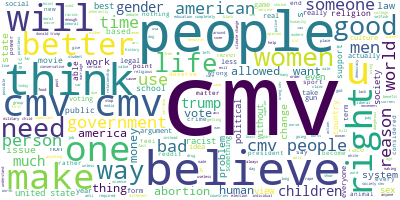

In [23]:
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(post_titles['cleaned_text'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [38]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'cmv', 'people', 'right', 'wrong'])

def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

data = post_titles['cleaned_text'].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Downloading package stopwords to
[nltk_data]     /sailhome/yiweil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['reason', 'trump', 'alt', 'well', 'left', 'incompetent']


In [39]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [42]:
from pprint import pprint
# number of topics
num_topics = 20
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"think" + 0.006*"us" + 0.005*"women" + 0.005*"need" + 0.004*"society" '
  '+ 0.004*"state" + 0.004*"way" + 0.004*"like" + 0.004*"believe" + '
  '0.004*"men"'),
 (1,
  '0.008*"think" + 0.008*"one" + 0.008*"would" + 0.007*"vote" + 0.005*"good" + '
  '0.005*"reason" + 0.004*"believe" + 0.004*"human" + 0.003*"thing" + '
  '0.003*"us"'),
 (2,
  '0.008*"trump" + 0.006*"us" + 0.005*"bad" + 0.005*"donald" + 0.004*"thing" + '
  '0.004*"believe" + 0.004*"like" + 0.004*"political" + 0.003*"american" + '
  '0.003*"would"'),
 (3,
  '0.008*"good" + 0.007*"want" + 0.007*"reason" + 0.006*"believe" + 0.006*"us" '
  '+ 0.006*"society" + 0.006*"would" + 0.005*"better" + 0.004*"gender" + '
  '0.004*"government"'),
 (4,
  '0.008*"trump" + 0.008*"us" + 0.007*"would" + 0.006*"believe" + '
  '0.005*"government" + 0.004*"race" + 0.004*"best" + 0.004*"racist" + '
  '0.004*"good" + 0.004*"legal"'),
 (5,
  '0.007*"allowed" + 0.007*"think" + 0.005*"would" + 0.004*"nothing" + '
  '0.004*"women" + 0.00

In [43]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = 'ldavis_prepared_'+str(num_topics)
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.033554  0.015616       1        1  6.096481
12     0.024935  0.001632       2        1  5.661826
6      0.036648  0.023452       3        1  5.614546
8      0.044179  0.012105       4        1  5.484312
18    -0.017181  0.073222       5        1  5.435796
3     -0.070402 -0.014167       6        1  5.212812
4     -0.033252  0.026347       7        1  5.157216
10    -0.027902  0.037368       8        1  5.112273
15     0.074465  0.078745       9        1  5.075635
2     -0.065726  0.006821      10        1  4.937565
17     0.000859 -0.000051      11        1  4.880928
9     -0.000284  0.054768      12        1  4.860294
1     -0.045050  0.017562      13        1  4.838555
11     0.054408 -0.051950      14        1  4.786856
19     0.028137 -0.061761      15        1  4.760501
5     -0.002827  0.015896      16        1  4.687394
7      0.001648 -0.008797      17        1  4.660081
14    -0.049782 -0.062144      18        1  4.587850
13    -0.075315 -0.071733      19        1  4.138369
16     0.088890 -0.092932      20        1  4.010709, topic_info=         Term        Freq       Total Category  logprob  loglift
156     think  338.000000  338.000000  Default  30.0000  30.0000
466     women  195.000000  195.000000  Default  29.0000  29.0000
367    gender  155.000000  155.000000  Default  28.0000  28.0000
1044   person  166.000000  166.000000  Default  27.0000  27.0000
146       bad  202.000000  202.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
447      much    6.413048  134.535577  Topic20  -6.0742   0.1727
274      make    6.438727  173.519662  Topic20  -6.0702  -0.0778
90    without    5.925248   91.236535  Topic20  -6.1533   0.4820
123     human    5.924780   95.553015  Topic20  -6.1534   0.4357
548      idea    5.926719   96.265310  Topic20  -6.1530   0.4286

[1753 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
233        1  0.070967       able
233        2  0.082795       able
233        3  0.082795       able
233        4  0.035484       able
233        5  0.082795       able
...      ...       ...        ...
10900      3  0.576554    zealots
7005      13  0.584401  zimmerman
1626       6  0.289961    zippers
1626      10  0.579922    zippers
5581      18  0.584479   æsthetic

[7000 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 13, 7, 9, 19, 4, 5, 11, 16, 3, 18, 10, 2, 12, 20, 6, 8, 15, 14, 17])

# Features

In [1]:
lexicons_per_word = defaultdict(list) # keep track of which lexicons a word appears in 

NameError: name 'defaultdict' is not defined

## Arousal

### SentiStrength

#### Examine SentiStrength lexicon bugs

In [59]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
Dictionary.txt','r') as f:
    ss_vocab = set(f.read().splitlines())

In [30]:
len(senti_dict)

2655

In [33]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/\
SentimentLookupTable.txt','r') as f:
    lines = f.read().splitlines()
    
senti_dict = {}
for line in lines:
    line_fields = line.split('\t')[:2]
    word, score = line_fields[0], int(line_fields[1])
    senti_dict[word] = score

In [110]:
#senti_dict#['abandon*']

In [56]:
def find_sentistrength_overlap(utts,ss_vocab):
    utts_vocab = [utt.split() for utt in utts]
    utts_vocab = [item.strip() for sublist in utts_vocab for item in sublist]
    return Counter([x for x in utts_vocab if x in ss_vocab])

In [60]:
sentistrength_vocab_overlap_per_cat = {}
for cat in utt_ids_per_senti_cat:
    sentistrength_vocab_overlap_per_cat[cat] = find_sentistrength_overlap(
        [filtered_cmv_subsample.get_utterance(utt_id).text
        for utt_id in utt_ids_per_senti_cat[cat]],ss_vocab)

In [170]:
# deltas_one_cat_vs_rest = {}
# for curr_cat in SENTI_CATS:
#     print("Computing LOR values for SS vocab in {} class vs. the rest.".format(curr_cat))
#     rest = Counter()
#     for cat in SENTI_CATS:
#         if cat != curr_cat:
#             rest += sentistrength_vocab_overlap_per_cat[cat]
#     deltas_one_cat_vs_rest[curr_cat] = \
#         do_weighted_lor(sentistrength_vocab_overlap_per_cat[curr_cat], 
#                                            rest, 
#                     PRIOR_WEIGHT, COUNTS1_WEIGHT, COUNTS2_WEIGHT, verbose=False)

In [93]:
#sorted(deltas_one_cat_vs_rest['hi_neg_hi_pos'].items(),key=lambda x: x[1],reverse=True)

In [94]:
#sorted(deltas_one_cat_vs_rest['hi_neg_lo_pos'].items(),key=lambda x: x[1],reverse=True)

In [95]:
#sorted(deltas_one_cat_vs_rest['hi_pos_lo_neg'].items(),key=lambda x: x[1],reverse=True)
# REALLY NEED TO REMOVE GENERIC COMMENTS

In [96]:
#sorted(deltas_one_cat_vs_rest['hi_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [97]:
#sorted(deltas_one_cat_vs_rest['lo_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [98]:
#sorted(deltas_one_cat_vs_rest['lo_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [99]:
#sorted(deltas_one_cat_vs_rest['hi_pos_neut_neg'].items(),key=lambda x: x[1],reverse=True)

In [100]:
#sorted(deltas_one_cat_vs_rest['neut_neg_neut_pos'].items(),key=lambda x: x[1],reverse=True)

In [79]:
len(senti_dict)

2655

In [86]:
# BUGS TO REMOVE FROM LOOKUP TABLE!

# cool, coolest, coolness, erode, erosion, exhaust, fume, fumes, leakage, leaking, 
# pollut, power, powerless, spill, sunnier, sunniest, sunny, sunshin*, warm*

# ?: desert, progressive, drought, undemocratic

bugs_to_remove = ['cool','coolest', 'coolness', 'erode', 'erosion', 'exhaust', 'fume', 
                  'fumes', 'leakage', 'leaking', 'pollut', 'power', 'powerless', 'spill', 
                  'sunnier', 'sunniest', 'sunny', 'sunshin*', 'warm*','desert','drought']

In [85]:
pd.DataFrame(senti_dict,index=[0]).T.to_csv('senti_dict.tsv',sep='\t',header=True,
                                            index=True)

In [171]:
# with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
# SentimentLookupTable.txt','r') as f:
#     old_lines = f.read().splitlines()

# for i,line in enumerate(old_lines):
#     for n,bug in enumerate(bugs_to_remove):
#         if line.startswith(bug):
#             print(n,line)

# with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
# SentimentLookupTable_debugged.txt','w') as f:
#     for line in old_lines:
#         has_bug = False
#         for bug in bugs_to_remove:
#             if line.startswith(bug):
#                 has_bug = True
#                 break
#         if not has_bug:
#             f.write(line+'\n')

In [101]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    for line in f:
        for bug in bugs_to_remove:
            if line.startswith(bug):
                print(line)

In [104]:
with open('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt','r') as f:
    print(len(f.read().splitlines()))

2634


In [105]:
len(old_lines),len(bugs_to_remove)

(2657, 21)

In [106]:
os.rename('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable_debugged.txt',
         '/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/\
SentimentLookupTable.txt')

#### Measure SentiStrength

In [16]:
from sentistrength import PySentiStr
senti = PySentiStr()
senti.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data/') 
print(senti.getSentiment('What exhaust, what fumes there is too much drought!',score='dual'))
print(senti.getSentiment('Energy efficiency is great.',score='dual'))

senti_debugged = PySentiStr()
senti_debugged.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_debugged.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_debug/') 
print(senti_debugged.getSentiment('What exhaust, what fumes there is too much drought!', 
                         score='dual'))
print(senti_debugged.getSentiment('Energy efficiency is great.',score='dual'))

senti_ads = PySentiStr()
senti_ads.setSentiStrengthPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength.jar') 
senti_ads.setSentiStrengthLanguageFolderPath('/u/scr/yiweil/datasets/SentiStrength/SentiStrength_Data_adjs_advs/') 
print(senti_ads.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))
print(senti.getSentiment('What a journey! What wrath! What Uneasiness!', 
                         score='dual'))

def get_senti_scores(utts, senti_model=senti_debugged, score='dual'):
    """
    param s: str to label for arousal
    param senti_model: instance of a PySentiStr() object
    param score: 'unary', 'dual' (default), 'binary', or 'ternary'
    """
    res = senti_model.getSentiment(utts, score=score)
    return res

[(1, -3)]
[(3, -1)]
[(2, -1)]
[(3, -1)]
[(2, -1)]
[(2, -3)]


Skip directly to scoring from cache if caches exist:

In [48]:
# Check that text; title information available for all ids
for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id != utt.conversation_id: # is a comment, rather than post
            text = utt.text
        else:
            text = corp_to_analyze[corp_name].get_conversation(utt.id).meta['title']

756789it [00:02, 317573.64it/s]
6349it [00:00, 211855.78it/s]


In [88]:
# # Score in batches
# BATCH_SIZE=5000

# for corp_name in corp_to_analyze:
#     if corp_name in {'matched_cmv_subsample','gen_reddit'}:
#         print("Scoring comment texts/post titles within {} in batches of {}..."\
#              .format(corp_name, BATCH_SIZE))
#         utt_ids = corp_to_analyze[corp_name].get_utterance_ids()
#         print("\tFound {} items to score.".format(len(utt_ids)))

#         all_senti_scores = defaultdict(list)

#         for ix in range(0,len(utt_ids),BATCH_SIZE):
#             utt_ids_batch = utt_ids[ix:min(ix+BATCH_SIZE,len(utt_ids))]
#             utts_batch_texts = [corp_to_analyze[corp_name].get_utterance(utt_id).text 
#                     if utt_id != corp_to_analyze[corp_name].get_utterance(utt_id).conversation_id
#                     else corp_to_analyze[corp_name].get_conversation(utt_id).meta['title']
#                     for utt_id in utt_ids_batch]
#             ids_texts_zip = list(zip(utt_ids_batch,utts_batch_texts))
#             ids_texts_zip = [item for item in ids_texts_zip if len(item[1]) > 0]
#             for senti_model in {senti_debugged, senti_ads}:
#                 utts_batch_texts = [x[1] for x in ids_texts_zip]
#                 utts_batch_senti_scores = get_senti_scores(utts_batch_texts,
#                                                            senti_model=senti_model)
#                 if len(utts_batch_senti_scores) != len(utts_batch_texts):
#                     break
#                 senti_model_name = 'all' if senti_model == senti_debugged else 'adxs_only'
#                 all_senti_scores[senti_model_name].extend(
#                     list(zip([x[0] for x in ids_texts_zip],utts_batch_senti_scores)))
#             if ix % 5000 == 0:
#                 print(ix)

#         pickle.dump(all_senti_scores,
#                     open('filtered_{}_senti_scores.pkl'.format(corp_name),'wb'))
#         print('\tSaved SentiStrength output to {}.\n'.format(
#                 'filtered_{}_senti_scores.pkl'.format(corp_name)))

In [79]:
diff = []
for i in tqdm(range(len(all_senti_scores['adxs_only']))):
    if all_senti_scores['adxs_only'][i] != all_senti_scores['all'][i]:
        diff.append(all_senti_scores['adxs_only'][i][0])
len(diff)

100%|██████████| 756670/756670 [00:00<00:00, 930395.31it/s] 


189988

In [84]:
utt_id2senti_score['adxs_only'][diff[10000]]

(3, -2)

In [85]:
utt_id2senti_score['all'][diff[10000]]

(3, -3)

In [86]:
corp_to_analyze['matched_cmv_subsample'].get_utterance(diff[10000]).text

'What makes you think the troops believe in intervening in these countries?  \n\nA line from "The Charge of the Light Brigade:"  \n\n*Ours is not to question why, ours is not to make reply. Ours is but to do and die.*  \n\nThe "support our troops" is not for what the government has them do, but for what they are willing to do for you as a US citizen. They are willing to guard your freedoms, with their life if need be. They are willing to take a bullet so that we can get on here and debate, have sympathy for them, etc... they aren\'t personally asking for it.  \n\nDo I think the idea of supporting the troops has been fetishized? I certainly do. I also think there are individuals who take it way too far, and think you are a bad person if you don\'t respect or support the troops. I don\'t think everyone must, that it is somehow our civic duty to do so. As a veteran, I support our troop without supporting the current policy. I honestly hold no umbrage against anyone that say a veteran or c

In [17]:
# Load scores from cache and initialize look-up dict
cached_senti_scores = glob.glob('filtered_*_senti_scores.pkl')
print('Found {} cached SentiStrength files.'.format(len(cached_senti_scores)))
utt_id2senti_score = defaultdict(dict)
for cache in cached_senti_scores:
    if cache != 'filtered_gen_reddit_senti_scores.pkl':
        scores = pickle.load(open(cache,'rb'))
        for senti_model in scores:
            utt_id2senti_score[senti_model].update(dict(zip(
                [item[0] for item in scores[senti_model]],
                [item[1] for item in scores[senti_model]]
            )))                              
        
def assign_senti_cat(senti_res): 
    res_pos, res_neg = senti_res[0], senti_res[1]
    cats = []
    if res_pos == 2:
        cats.append('lo_pos')
    elif res_pos > 2:
        cats.append('hi_pos')
    else:
        cats.append('neut_pos')
        
    if res_neg == -2:
        cats.append('lo_neg')
    elif res_neg < -2:
        cats.append('hi_neg')
    else:
        cats.append('neut_neg')
    
    return cats

# Assign scores from look-up dict
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if len(utt.text) > 0:
                for senti_model in {'all','adxs_only'}:
                    cats = assign_senti_cat(utt_id2senti_score[senti_model][utt.id])
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = '_'.join(sorted(cats))
            else:
                for senti_model in {'all','adxs_only'}:
                    utt.meta[f'senti_{senti_model}_arousal_cat'] = None

Found 3 cached SentiStrength files.


756789it [00:13, 54248.93it/s]


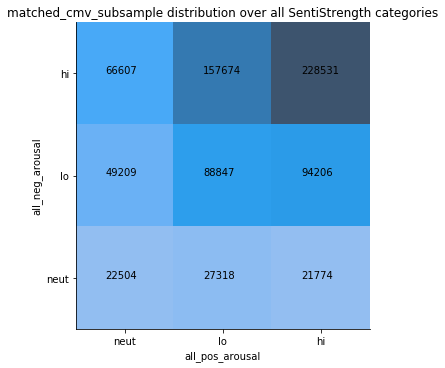

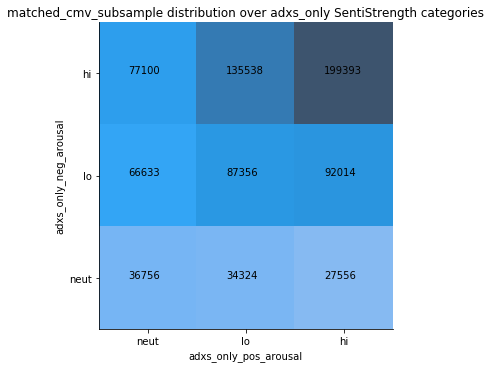

In [21]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                  if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat':[utt.meta['senti_all_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat':[utt.meta['senti_adxs_only_arousal_cat'] 
                                 for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']]
        })
        for senti_model in {'all','adxs_only'}:
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            ax = sns.displot(data=to_plot_df, 
                             x=f'{senti_model}_pos_arousal', 
                             y=f'{senti_model}_neg_arousal')
            x_locs, y_locs = ax.axes[0][0].get_xticks(), ax.axes[0][0].get_yticks()
            for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                    plt.annotate(str(len(to_plot_df.loc[
                        (to_plot_df[f'{senti_model}_pos_arousal']==pos_level) &
                        (to_plot_df[f'{senti_model}_neg_arousal']==neg_level)])),
                        xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.title(f'{corp_name} distribution over {senti_model} SentiStrength categories')
            plt.savefig(f'figs/senti_dist_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

Examine temporal trend:

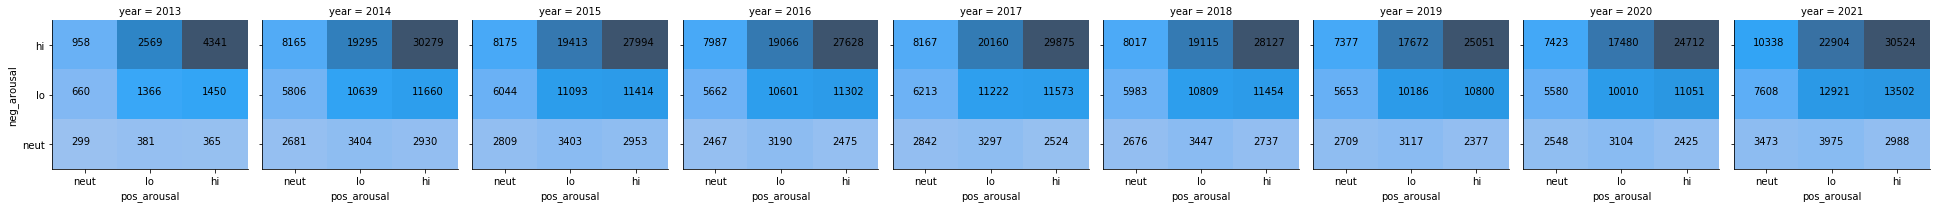

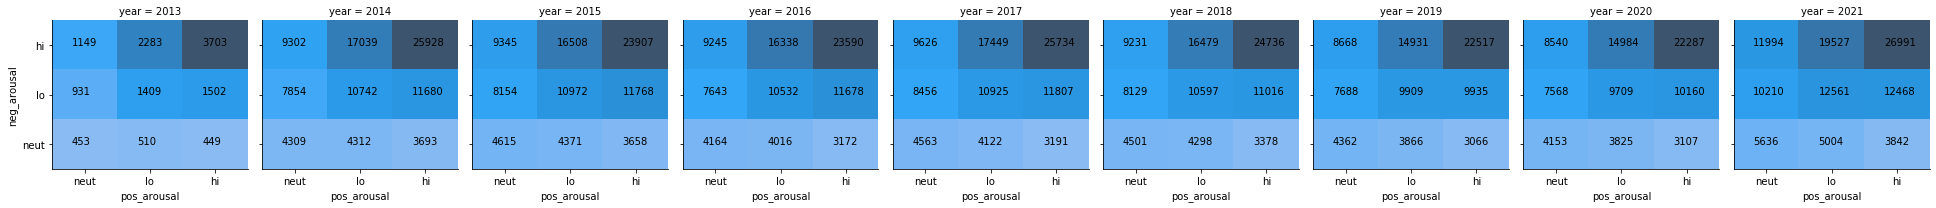

In [22]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','gen_reddit','matched_cmv_subsample'}:

        years = list(range(2013,2022))
        topics = ['climate change','other']
        for senti_model in ['all','adxs_only']:
        #emotions = EMOLEX_EMOS
            df_year, df_topic = [], []
            df_id, df_contro, df_replies, df_score = [], [], [], []
            df_pos_arousal, df_neg_arousal = [], []
            for utt in corp_to_analyze[corp_name].iter_utterances():
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if ('is_cc_related' in utt.meta and utt.meta['is_cc_related']) else 'other'
                df_year.append(year)
                df_topic.append(topic)
                df_id.append(utt.id)
                contro = utt.meta['controversiality'] if 'controversiality' in utt.meta else None
                df_contro.append(contro)
                num_replies = len(utt.meta['reply_ids']) if 'reply_ids' in utt.meta else None
                df_replies.append(num_replies)
                df_score.append(utt.meta['score'])
                senti_cat = utt.meta[f'senti_{senti_model}_arousal_cat'] 
                if senti_cat is not None:
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                else:
                    df_pos_arousal.append(None)
                    df_neg_arousal.append(None)
            to_plot_df = pd.DataFrame({
                'year':df_year,
                'topic':df_topic,
                'id':df_id,
                'contro':df_contro,
                'num_replies':df_replies,
                'score':df_score,
                'pos_arousal':df_pos_arousal,
                'neg_arousal':df_neg_arousal
            })
            for i,val in enumerate(['pos','neg']):
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='year', aspect=1)
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')#, ci='sd')
            sns.despine()
            for i,col in enumerate(g.col_names):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['year']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
            plt.savefig(f'figs/senti_dist_over_time_{corp_name}_{senti_model}.png',
                        dpi=150,bbox_inches="tight")

In [23]:
# # Why are there so many neut-neut comments in general Reddit?
# # Examine examples
# [utt.text for utt in corp_to_analyze['gen_reddit'].iter_utterances()
# if utt.meta['senti_arousal_cat'] == 'neut_neg_neut_pos'][:20]

In [24]:
# [utt.text for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
# if utt.meta['senti_arousal_cat'] == 'hi_neg_hi_pos'][:20]

### NRC

In [14]:
VAD = pd.read_csv('/u/scr/yiweil/datasets/NRC-VAD-Lexicon.txt',sep='\t',header=0)
VAD.head()

,Word,Valence,Arousal,Dominance
0,aaaaaaah,0.479,0.606,0.291
1,aaaah,0.520,0.636,0.282
2,aardvark,0.427,0.490,0.437
3,aback,0.385,0.407,0.288
4,abacus,0.510,0.276,0.485


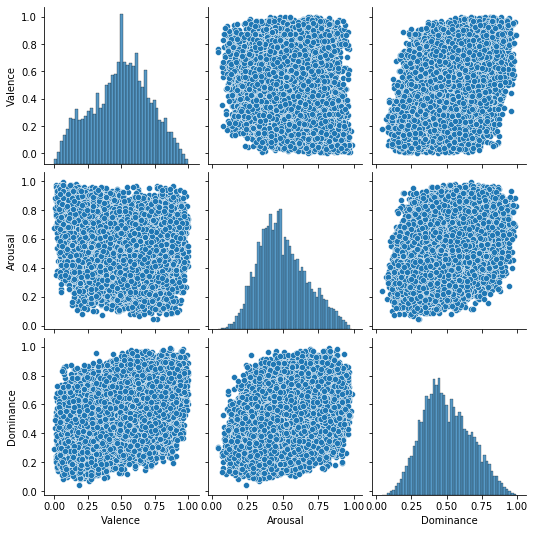

In [20]:
sns.pairplot(data=VAD)

In [19]:
# Create look-up dicts and function for computing NRC arousal

word2nrc_arousal = dict(zip(VAD['Word'],VAD['Arousal']))
word2nrc_valence = dict(zip(VAD['Word'],VAD['Valence']))

NRC_words_per_cat = defaultdict(list)
HI_AROUSAL_THRESH, LO_AROUSAL_THRESH = VAD['Arousal'].quantile(.75), VAD['Valence'].quantile(.25)
for w in tqdm(VAD['Word'].values):
    if word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['hi_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] <= VAD['Valence'].quantile(.25):
        NRC_words_per_cat['lo_neg'].append(w)
    elif word2nrc_arousal[w] <= LO_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['lo_pos'].append(w)
    elif word2nrc_arousal[w] >= HI_AROUSAL_THRESH \
    and word2nrc_valence[w] >= VAD['Valence'].quantile(.75):
        NRC_words_per_cat['hi_pos'].append(w)
    else:
        NRC_words_per_cat['neut'].append(w)
        
NRC_words_per_cat = {cat: set(NRC_words_per_cat[cat]) for cat in NRC_words_per_cat}

word2NRC_cat = {}
for cat in NRC_words_per_cat:
    word2NRC_cat.update({w: cat for w in NRC_words_per_cat[cat]})
    
def get_nrc_arousal_cat(utt_lemmas,utt_id,cache_dict=None,verbose=False):
    if not cache_dict:
        val_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_valence]
        if len(val_lemms) > 0:
            valence_norm = sum([word2nrc_valence[lemm] 
                            for lemm in val_lemms])/len(val_lemms)
            arousal_lemms = [lemm for lemm in utt_lemmas if lemm in word2nrc_arousal]
            arousal_norm = sum([word2nrc_arousal[lemm] 
                               for lemm in arousal_lemms])/len(arousal_lemms)
            if verbose:
                print(val_lemms)
                print(arousal_lemms)

            if arousal_norm >= VAD['Arousal'].quantile(.50):
                if valence_norm >= VAD['Valence'].quantile(.5):
                    return 'hi_pos'
                else:
                    return 'hi_neg'
            elif arousal_norm < VAD['Arousal'].quantile(.50) \
            and arousal_norm >= VAD['Arousal'].quantile(.25):
                if valence_norm >= VAD['Valence'].quantile(.5):
                    return 'lo_pos'
                else:
                    return 'lo_neg'
            else:
                return 'neut'
        return None
    else:
        return cache_dict[utt_id]

100%|██████████| 20007/20007 [00:18<00:00, 1105.32it/s]


In [ ]:
#NRC_words_per_cat['hi_neg']

In [ ]:
#NRC_words_per_cat['lo_neg']

In [ ]:
#NRC_words_per_cat['hi_pos']

In [ ]:
#NRC_words_per_cat['lo_pos']

In [21]:
# Assign NRC arousal categories 
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        vad_cache = pickle.load(open(f'VAD_scores_{corp_name}.pkl','rb'))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            vad_score = get_nrc_arousal_cat(None,utt.id,cache_dict=vad_cache)
            utt.meta['nrc_all_arousal_cat'] = vad_score['all']
            utt.meta['nrc_adxs_only_arousal_cat'] = vad_score['adxs_only']
            #break

756789it [00:07, 99482.51it/s] 


In [30]:
# # One time: create cache 
# vad_cache = defaultdict(dict)
# for corp_name in corp_to_analyze:
#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         vad_cache[utt.id]['all'] = utt.meta['nrc_all_arousal_cat']
#         vad_cache[utt.id]['adxs_only'] = utt.meta['nrc_adxs_only_arousal_cat']
#     pickle.dump(vad_cache,open(f'VAD_scores_{corp_name}.pkl','wb'))

756789it [00:03, 217946.28it/s]


### Compare SentiStrength categories to VAD categories

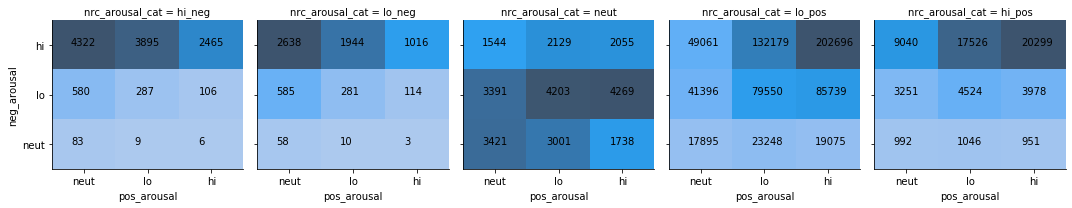

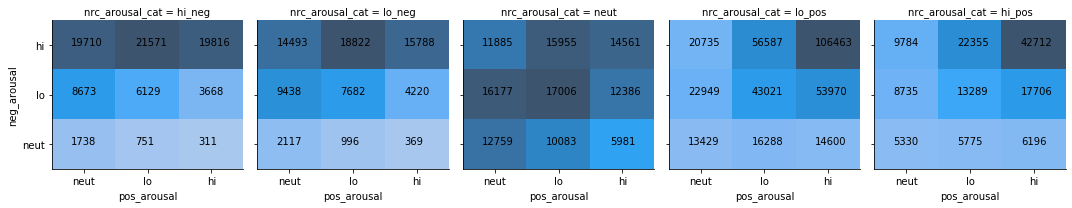

In [37]:
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        for model_name in ['all','adxs_only']:
            to_plot_df = pd.DataFrame({
                'id': [utt.id for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.meta[f'senti_{model_name}_arousal_cat'] 
                      and f'nrc_{model_name}_arousal_cat' in utt.meta 
                      and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'senti_arousal_cat':[utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'nrc_arousal_cat':[utt.meta[f'nrc_{model_name}_arousal_cat'] 
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if utt.meta[f'senti_{model_name}_arousal_cat'] 
                                     and f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            for i,val in enumerate(['pos','neg']):
                to_plot_df['{}_arousal'.format(val)] = \
                to_plot_df[f'senti_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                          to_plot_df['{}_arousal'.format(val)],
                                                          categories=categories,
                                                          ordered=True)

            g = sns.FacetGrid(to_plot_df, col='nrc_arousal_cat', 
                              col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
            g.map(sns.histplot, 'pos_arousal', 'neg_arousal')
            for i,col in enumerate(['hi_neg','lo_neg','neut','lo_pos','hi_pos']):
                ax = g.axes.flat[i]
                x_locs, y_locs = ax.get_xticks(), ax.get_yticks()
                for p_i,pos_level in enumerate(['neut', 'lo', 'hi']):
                    for n_i,neg_level in enumerate(['neut', 'lo', 'hi']):
                        ax.annotate(str(len(to_plot_df.loc[(to_plot_df['nrc_arousal_cat']==col) &
                                                           (to_plot_df['pos_arousal']==pos_level) &
                                                           (to_plot_df['neg_arousal']==neg_level)])),
                                    xy=(x_locs[p_i]-0.2,y_locs[2-n_i]))
        #     plt.title('{} distribution over SentiStrength categories per VAD category'.format(
        #         corp_name))
            plt.savefig(f'figs/senti_dist_and_vad_dist_{corp_name}_{model_name}.png',
                         dpi=150,bbox_inches="tight")

Comments receiving `hi_neg` NRC label but `hi_pos_lo_neg` SentiStrength label:

In [115]:
mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_neg') &
                              (to_plot_df['senti_arousal_cat']=='hi_pos_lo_neg')]\
['id'].values
pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

,0
0,"The existence of Global Warming is considered a political issue in very few countries. Really only the US.\n\nWhy is that?\n\nIn 2006, Al Gore helped to make the movie ""An Inconvenient Truth."" The opening line of this film is ""'Hi, I'm Al Gore, I used to be the next president of the United States of America."" By opening the film in this manner, Mr. Gore *immediately* politicized the issue. I don't agree with the fact that it did, but that's the unfortunate truth.\n\n\nIf you're talking about the US and only the US, then there's some truth to this as we've politicized the issue of global warming (even though the IPCC has officially stated that it's happening and caused by humans.) If your talking about other countries, then I don't think this is true simply because global warming isn't a political issue. So, please clarify, is this US specific or not?\n\nSource: Attendance of Multiple Lectures by IPCC memebers"
1,"Just because a source has not got a good track record does not mean they are permanently doomed to being wrong forever. Second, a prediction is only proved when it comes true. Just because it has not come true yet doesn't mean it never will. What you demand from these organisations is that they knew what they were talking about 5 years ago, when there is every chance they are working on more robust science since then. Regardless of this, your post claims it is unprovable. They are, of course, all provable, they just haven't been proved yet. \n\nInstead I put it to you, that you cannot prove that anthropocentric climate change being catastrophic cannot be proven, and your point of view is therefore redundant. I however, can prove that it is provable. It is instantly proved, when any one of the models that claims it will be catastrophic is proved correct"
2,"First time commenting on one of these, your opinion actually makes a lot of sense to me. Developing economies need these co2 emitting resources; however, there is no need for developed nations to still be using them. While there are definite pluses for having more CO2 in the air there are still many negatives! Pollution, contamination, CO2 levels in the ocean, acid rain, smog, and many more. Human life and expectancy can all move up by creating resources that have no effect on the environment. Elon Musk had commented this a couple days ago: ""If we know we have to get off oil no matter what, we know that is an inescapable outcome, why run this crazy experiment of changing the chemical composition of the atmosphere and oceans by adding enormous amounts of CO2 that have been buried since the Precambrian Era?"" he added. ""That's crazy. That's the dumbest experiment in history, by far."""
3,Politicians should have been making substantial progress towards stopping climate change years and years ago. We still aren't doing enough. One could make the point that our economies are dependent on fossil fuels too much at the minute (particularly in the us where lobbying forces have ensured that fossil fuels are subsidised massively.) These are all things that are currently delaying (or minimising) political action on climate change
4,"Could be if it wasn't so expensive. Nuclear power could be great if we'd invested heavily in developing a cheap to decommission, long life, unable to breed isotopes for nuclear weapons reactor 30 or 40 years ago. \n\nThe same is true of fusion, even if fusion reactors become viable you can get a huge amount of solar panels, wind turbines and hydro dams for the same money as a fusion reactor would cost."
5,"Very few progressives are abstaining from their vote with Biden, especially with the leaders of the progressive wing aligning themselves, furthermore with no serious 3rd party contender your argument should be along the lines ”if your on the left and hold climate change to a high degree then you should vote for biden and not a write in candidate or the green party” \n\nThere are thousands of sources that will adequately demonstrate the

Comments receiving `hi_pos` NRC label but `hi_neg_neut_pos` or `hi_neg_lo_pos` SentiStrength label:

In [28]:
# mismatch_ids = to_plot_df.loc[(to_plot_df['nrc_arousal_cat']=='hi_pos') &
#                               (to_plot_df['senti_arousal_cat'].isin({'hi_neg_neut_pos',
#                                                                      'hi_neg_lo_pos'}))]\
# ['id'].values
# pd.DataFrame([corp_to_analyze[corp_name].get_utterance(i).text for i in mismatch_ids])

## Emotions

### EmoLex

In [15]:
BLACKLIST_WORDS = {'shit','shitty','fuck','crap','crappy','gore','trump','tree','sun','soil','shanghai','john',
                  'desert','turn','earthquake','lightning','hurricane','cyclone','tornado','storm','wildfire',
                  'fire','cool','warm','hot','human','earth','planet','global','climate','change','cold'}

In [16]:
PATH_TO_EMOLEX = "/u/scr/yiweil/datasets/NRC-Emotion-Intensity-Lexicon-v1.txt"
EMOLEX = pd.read_csv(PATH_TO_EMOLEX,sep='\t')
EMOLEX = EMOLEX.loc[~EMOLEX['word'].isin(BLACKLIST_WORDS)]
EMOLEX_EMOS = EMOLEX['emotion'].value_counts().index
print(EMOLEX.head())

print(EMOLEX[
    'emotion'
].value_counts())

        word emotion  emotion-intensity-score
0   outraged   anger                    0.964
1  brutality   anger                    0.959
2     hatred   anger                    0.953
3    hateful   anger                    0.940
4  terrorize   anger                    0.939
fear            1754
trust           1562
anger           1475
sadness         1292
joy             1265
disgust         1085
anticipation     862
surprise         578
Name: emotion, dtype: int64


In [44]:
ratios_trusted_trusting = pickle.load(open('emolex_high_trust_ratios_trusted_trusting.pkl','rb'))
trusted_words = [w for w in ratios_trusted_trusting if ratios_trusted_trusting[w] >= 1]
trusting_words = [w for w in ratios_trusted_trusting if ratios_trusted_trusting[w] < 1]
len(trusted_words),len(trusting_words)

(450, 379)

In [ ]:
# # Why is trust higher than the rest?
# EMOLEX.loc[(EMOLEX['emotion']=='trust') & 
#           (EMOLEX['emotion-intensity-score']>0.5)].word.values

In [25]:
# Create look-up dicts and function for computing Emolex scores

word2emolex_score = defaultdict(dict)
for _,row in EMOLEX.iterrows():
    word, emotion, score = row['word'], row['emotion'], row['emotion-intensity-score']
    word2emolex_score[word][emotion] = score
    
def get_emolex_scores(utt,utt_id,json_dir,cache_dict=None,verbose=False):
    if not cache_dict:
        json_obj = get_stanza_json(utt)
        if json_obj:
            utt_lemmas = [x['lemma'] for sent in json_obj['parse'] for x in sent]
            utt_adxs = [x['lemma'] for sent in json_obj['parse'] for x in sent if x['upos'] in {'ADJ','ADV'}]
            emo_lemms = [lemm for lemm in utt_lemmas if lemm in word2emolex_score]
            emo_adxs = [lemm for lemm in utt_adxs if lemm in word2emolex_score]
            if verbose:
                print(emo_lemms)
                print(emo_adxs)

            emo_norms = defaultdict(dict)
            if len(emo_lemms) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_lemms
                                    if emo in word2emolex_score[lemm]])/len(emo_lemms)
                    emo_norms['all'][emo] = emo_norm
            if len(emo_adxs) > 0:
                for emo in EMOLEX_EMOS:
                    emo_norm = sum([word2emolex_score[lemm][emo]
                                    for lemm in emo_adxs
                                    if emo in word2emolex_score[lemm]])/len(emo_adxs)
                    emo_norms['adxs_only'][emo] = emo_norm
            return emo_norms
        return {}
    else:
        return cache_dict[utt_id]

In [42]:
utt.text

'We actually don’t have many Mac apples around me, so I don’t have strong opinions on it.\n\nBut when I saw the Red Delicious is the lowest common denominator of apples, I mean that in terms of its actual place in the market.   It literally was bred to be the generic “apple” that you can find in any free fruit basket, crappy school and hospital cafeteria, etc.   It’s the mass market product of late 20th century American industrial agriculture.\n\nThe original cultivar of the apple was apparently quite good, which is why it became popular.  And I’m sure if you get some good red delicious apples today that they are from sources closer to those original trees.\n\nBut around the ‘40s and ‘50s, as our food supply chains industrialized, farmers started selecting for strains that were more consistently deep red, because those were the easiest to market, that had thick skins, because those could be more easily shipped, and that had high yields, because those grew more cheaply.   Taste and text

In [44]:
get_emolex_scores(utt,utt.id,STANZA_DIR,verbose=True)

['strong', 'free', 'school', 'hospital', 'late', 'good', 'popular', 'good', 'delicious', 'food', 'start', 'ship', 'grow', 'result', 'delicious', 'dominate', 'bad', 'bottom', 'fall', 'delicious', 'government', 'production', 'delicious', 'grow', 'good', 'good', 'reliable', 'delicious']
['strong', 'free', 'late', 'good', 'popular', 'good', 'delicious', 'delicious', 'bad', 'delicious', 'delicious', 'good', 'good', 'reliable', 'delicious']


defaultdict(dict,
            {'all': {'fear': 0.05914285714285714,
              'trust': 0.23260714285714287,
              'anger': 0.03403571428571429,
              'sadness': 0.05971428571428572,
              'joy': 0.22746428571428567,
              'disgust': 0.013964285714285716,
              'anticipation': 0.1727857142857143,
              'surprise': 0.04357142857142856},
             'adxs_only': {'fear': 0.025,
              'trust': 0.27540000000000003,
              'anger': 0.030199999999999998,
              'sadness': 0.03646666666666667,
              'joy': 0.37513333333333326,
              'disgust': 0.02606666666666667,
              'anticipation': 0.10213333333333333,
              'surprise': 0.058399999999999994}})

In [48]:
# # One time: create cache
# for corp_name in corp_to_analyze:
#     if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
#         emolex_cache = defaultdict(dict)
#         for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#             scores = get_emolex_scores(utt,utt.id,STANZA_DIR)
#             if len(scores) > 0:
#                 for emo in EMOLEX_EMOS:
#                     for model_name in scores:
#                         utt.meta[f'emolex_{model_name}_{emo}'] = scores[model_name][emo]
#                         emolex_cache[utt.id][f'{model_name}_{emo}'] = scores[model_name][emo]
#         pickle.dump(emolex_cache,open(f'emolex_cache_{corp_name}.pkl','wb'))

756789it [28:50, 437.41it/s]


In [26]:
# Get Emolex scores for corpora that are stanza-parsed
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cmv_subsample','matched_cc_cmv_subsample'}:
        emolex_cache = pickle.load(open(f'emolex_cache_{corp_name}.pkl','rb'))
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            scores = get_emolex_scores(utt,utt.id,STANZA_DIR,cache_dict=emolex_cache)
            if len(scores) > 0:
                for emo in EMOLEX_EMOS:
                    for model_name in ['all','adxs_only']:
                        if f'{model_name}_{emo}' in scores:
                            utt.meta[f'emolex_{model_name}_{emo}'] = scores[f'{model_name}_{emo}']

756789it [01:05, 11557.13it/s]


Examine temporal trend:

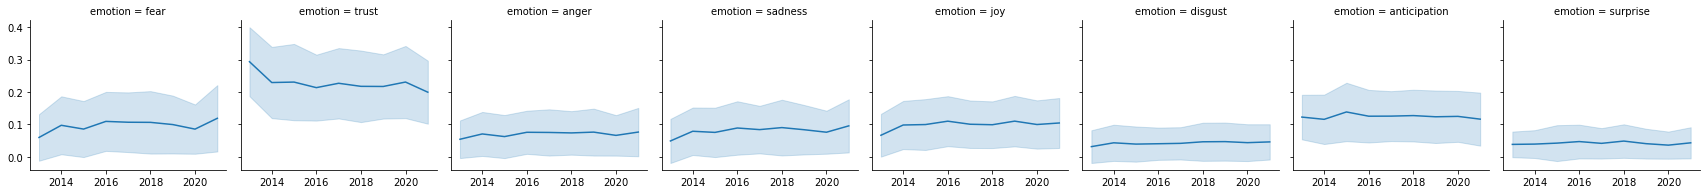

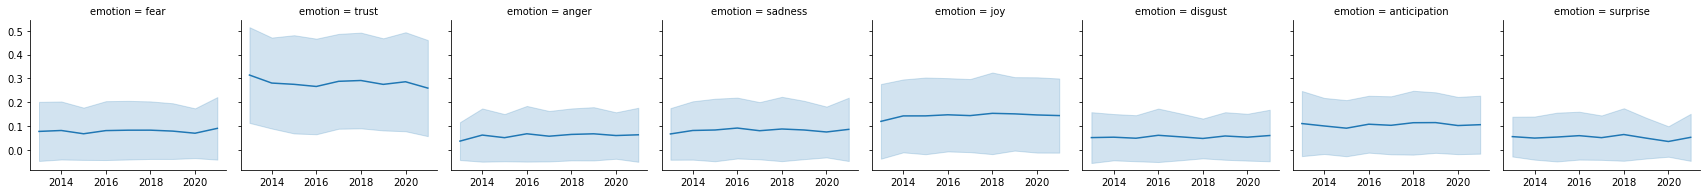

In [133]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            year = datetime.utcfromtimestamp(utt.timestamp).year
            topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
            for key in utt.meta.keys():
                if key.startswith(f'emolex_{model_name}'):
                    emo = key.split('_')[-1]
                    score = utt.meta[f'emolex_{model_name}_{emo}']
                    df_year.append(year)
                    df_topic.append(topic)
                    df_emo.append(emo)
                    df_emoscore.append(score)
                    df_id.append(utt.id)
                    df_contro.append(utt.meta['controversiality'])
                    df_replies.append(len(utt.meta['reply_ids']))
                    df_score.append(utt.meta['score'])
                    df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                    senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                    df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                    df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                    df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
        plt.rcParams['figure.figsize'] = [10, 5]
        g = sns.FacetGrid(to_plot_df, col='emotion', aspect=1)
        g.map(sns.lineplot, 'year', 'emoscore', ci='sd')
        sns.despine()
        for ax in g.axes[0]:
            ax.set_xlabel('')
            ax.set_ylabel('')
        plt.savefig(f'figs/emolex_scores_over_time_{corp_name}_{model_name}.png',
                    dpi=200,bbox_inches="tight")

Examine other correlations:

Engagement-related correlations:

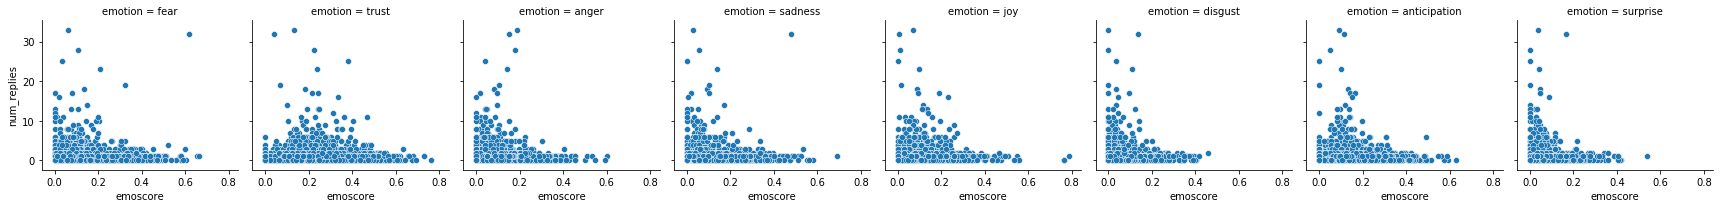

In [209]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','num_replies')
# for ax in g.axes[0]:
#     ax.set_yscale('log')

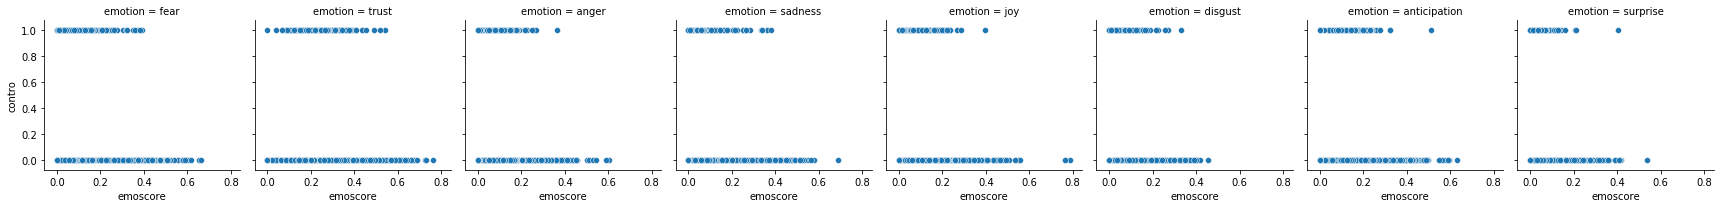

In [210]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','contro')

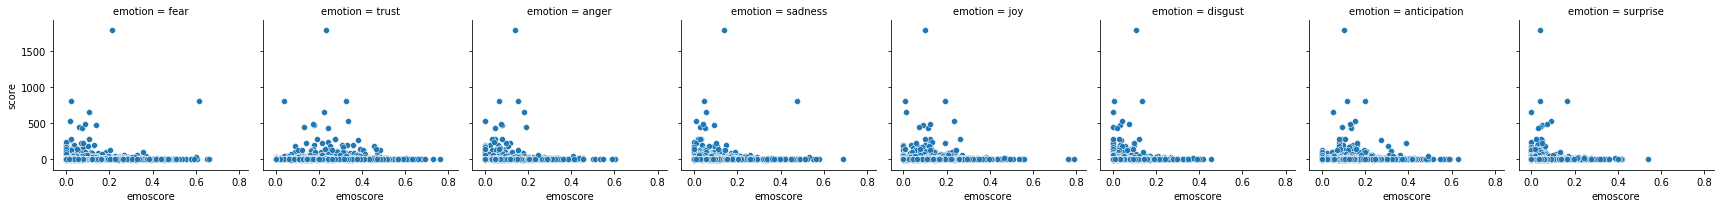

In [211]:
g = sns.FacetGrid(to_plot_df, col='emotion')
g.map(sns.scatterplot,'emoscore','score')

Arousal correlations:

In [38]:
for corp_name in corp_to_analyze:
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            if utt.id[:2] != 't3':
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
                for key in utt.meta.keys():
                    if key.startswith(f'emolex_{model_name}'):
                        emo = key.split('_')[-1]
                        score = utt.meta[f'emolex_{model_name}_{emo}']
                        df_year.append(year)
                        df_topic.append(topic)
                        df_emo.append(emo)
                        df_emoscore.append(score)
                        df_id.append(utt.id)
                        df_contro.append(utt.meta['controversiality'])
                        df_replies.append(len(utt.meta['reply_ids']))
                        df_score.append(utt.meta['score'])
                        df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                        senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                        df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                        df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                        df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })
        for i,val in enumerate(['pos','neg']):
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
    
        g = sns.FacetGrid(to_plot_df, col=f'nrc_arousal', 
                          col_order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
        g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)

        # Aesthetics & saving
        for ax_ix,ax in enumerate(g.axes[0]):
            if ax_ix == 0:
                ax.set_ylabel('Emotion intensity score',fontsize=24)
            ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel('')
        plt.savefig(f'figs/emolex_dist_and_vad_dist_{corp_name}_{model_name}.png',
                     dpi=150,bbox_inches="tight")

KeyboardInterrupt: 

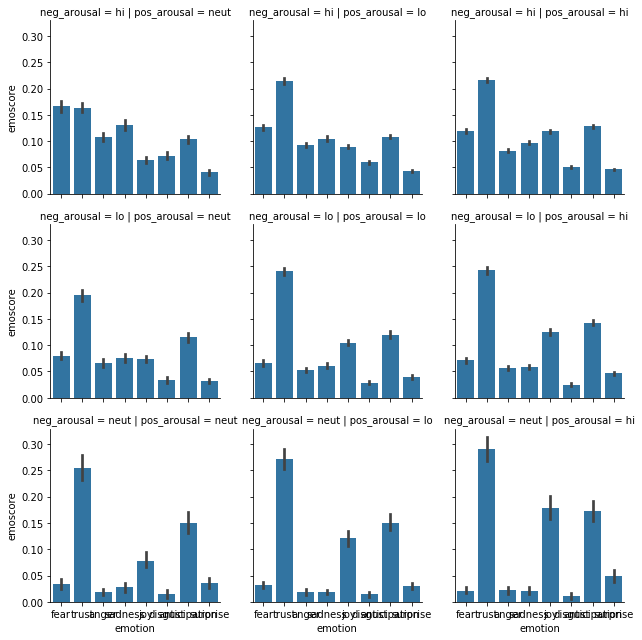

In [200]:
for corp_name in corp_to_analyze:
    
    g = sns.FacetGrid(to_plot_df, col='pos_arousal', row='neg_arousal',
                      col_order=['neut','lo','hi'], row_order=['hi','lo','neut'])
    g.map(sns.barplot, 'emotion', 'emoscore', order=EMOLEX_EMOS)
    
#     # Aesthetics & saving
#     for ax_ix,ax in enumerate(g.axes[0]):
#         if ax_ix == 0:
#             ax.set_ylabel('Emotion intensity score',fontsize=24)
#         ax.set_title(ax.title._text.split('= ')[-1],fontsize=22)
#         ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
#         ax.set_xlabel('')
#     plt.savefig('figs/emolex_dist_and_senti_dist_{}.png'.format(corp_name),
#                  dpi=150,bbox_inches="tight")

## People

In [17]:
def get_ents(utt,json_dir,verbose=False):
    json_obj = get_stanza_json(utt)
    if json_obj is not None:
        ents = [(x['text'],x['type']) for x in json_obj['ents']]
        return ents
    else:
        return []

In [ ]:
# Extract people
for corp_name in corp_to_analyze:
    if corp_name in {'matched_cc_cmv_subsample','matched_cmv_subsample'}:
        all_corp_ents = []
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            if utt.id[:2] != 't3':
                utt_ents = get_ents(utt,STANZA_DIR)
                all_corp_ents.extend(utt_ents)
                utt.meta['people'] = [e[0] for e in utt_ents if e[1]=='PERSON']

23450it [07:04, 34.12it/s]

First, examine most commonly mentioned NEs:

In [282]:
print(sorted(Counter([x for x in all_corp_ents if x[1] not in {'DATE','CARDINAL','ORDINAL','PERCENT'}]).items(), 
       key=lambda x: x[1], reverse=True)[:100])
del all_corp_ents

[(('US', 'GPE'), 738), (('Earth', 'LOC'), 642), (('China', 'GPE'), 602), (('Trump', 'PERSON'), 175), (('India', 'GPE'), 174), (('IPCC', 'ORG'), 160), (('American', 'NORP'), 155), (('America', 'GPE'), 145), (('Europe', 'LOC'), 139), (('Republicans', 'NORP'), 130), (('Canada', 'GPE'), 116), (('USA', 'GPE'), 108), (('Americans', 'NORP'), 95), (('NASA', 'ORG'), 92), (('California', 'GPE'), 89), (('Democrats', 'NORP'), 83), (('Russia', 'GPE'), 83), (('the United States', 'GPE'), 79), (('Africa', 'LOC'), 74), (('Chinese', 'NORP'), 73), (('U.S.', 'GPE'), 71), (('republicans', 'NORP'), 65), (('Australia', 'GPE'), 57), (('UK', 'GPE'), 57), (('earth', 'LOC'), 56), (('EPA', 'ORG'), 51), (('Republican', 'NORP'), 50), (('Al Gore', 'PERSON'), 48), (('Tesla', 'ORG'), 46), (('Venus', 'LOC'), 45), (('Paris', 'GPE'), 45), (('Obama', 'PERSON'), 44), (('Germany', 'GPE'), 42), (('EU', 'ORG'), 41), (('Florida', 'GPE'), 40), (('Bible', 'WORK_OF_ART'), 40), (('OP', 'ORG'), 40), (('France', 'GPE'), 39), (('GM'

Examine most commonly mentioned people:

In [355]:
counted_people = Counter([item for sublist in 
                         [utt.meta['people'] for utt in corp_to_analyze['matched_cc_cmv_subsample'].iter_utterances()
                         if utt.id[:2] != 't3' and utt.meta['is_awarded_delta']]
                         for item in sublist
                         ])
sorted(counted_people.items(),key=lambda x: x[1],reverse=True)[:100]

[('Trump', 10),
 ('Greta', 4),
 ('Joe', 3),
 ('Al Gore', 3),
 ('Broecker', 2),
 ('E. Calvo', 2),
 ('M.T. McCulloch', 2),
 ('J.F. Marshall', 2),
 ('M.K. Gagan', 2),
 ('J.M. Lough', 2),
 ('B.N. Opdyke', 2),
 ('Iris', 2),
 ('Lindzen', 2),
 ('Clinton', 2),
 ('Bill Nye', 2),
 ("Al Gore's", 2),
 ('Greta Thunberg', 2),
 ('Donald Trump', 2),
 ('Simon', 2),
 ('Joe Smuch', 1),
 ('Ruddiman', 1),
 ('S.E. Wijffels', 1),
 ('R.J. Matear', 1),
 ('Occam', 1),
 ('Spencer', 1),
 ('Hadley Cells', 1),
 ('W Bush', 1),
 ('Biden', 1),
 ('Matt Yglesias', 1),
 ('Linuxmoose5000', 1),
 ('Manchin', 1),
 ('Dunning-Kruger', 1),
 ('Brooks', 1),
 ('The Bill Gates', 1),
 ('Sandy', 1),
 ('Lenin', 1),
 ('Milankovitch', 1),
 ('Saharan Summers', 1),
 ('Robert Mugabe', 1),
 ('McCulloch', 1),
 ('Nick Bostrom', 1),
 ('Bostrom', 1),
 ('Erwin', 1),
 ('Utah Phillips', 1),
 ('BILL NYE', 1),
 ('Bruce Willis', 1),
 ('Cook', 1),
 ('Cooks', 1),
 ('Tucker Carlson', 1),
 ('Tucker', 1),
 ('Bill', 1),
 ('Jim Skea', 1),
 ('Mitch McConnell

Examine temporal trend:

756789it [00:04, 185943.28it/s]


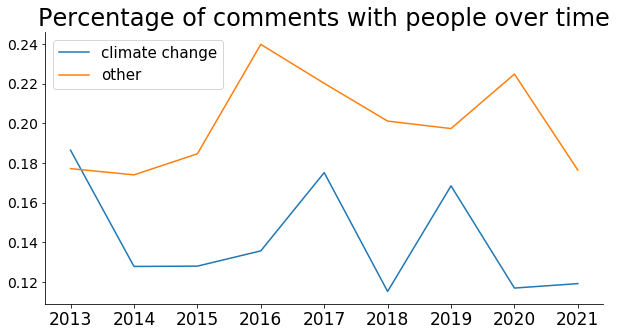

In [49]:
for corp_name in corp_to_analyze:
    counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.timestamp and utt.id[:2] != 't3':
            year = datetime.utcfromtimestamp(utt.timestamp).year
            if utt.meta['is_cc_related']:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['climate change']['has person'] += 1
                else:
                    counts_by_bin[year]['climate change']['no person'] += 1
            else:
                if len(utt.meta['people'])>0:
                    counts_by_bin[year]['other']['has person'] += 1
                else:
                    counts_by_bin[year]['other']['no person'] += 1

    years = list(range(2013,2022))
    topics = ['climate change','other']
    classes = ['has person','no person']
    to_plot_df = pd.DataFrame({
        'year':[item for sublist in 
                [[y]*len(topics)*len(classes) for y in years]
                for item in sublist],
        'topic':[item for sublist in 
                [[t]*len(classes) for t in topics]
                for item in sublist]*len(years),
        'class':classes*len(years)*len(topics),
        'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
    })

    per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
    to_plot_df['percent'] = to_plot_df.apply(
        lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
                            .loc[x['topic']]['count'],
        axis=1
    )

    plt.rcParams['figure.figsize'] = [10, 5]
    sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='has person'],
               x='year',y='percent',hue='topic',ci='sd')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(fontsize=17)
    plt.yticks(fontsize=14)
    plt.title('Percentage of comments with people over time',fontsize=24)
    plt.legend(title='',fontsize=15)
    sns.despine()
    plt.savefig('figs/pct_comments_with_people_over_time_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

Examine correlation with other comment properties:

In [50]:
for corp_name in corp_to_analyze:

    people_df = pd.DataFrame({
        'id':[utt.id
             for utt in corp_to_analyze[corp_name].iter_utterances()
             if utt.id[:2] != 't3'],
        'has_person':[len(utt.meta['people'])>0 
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
        'num_people':[len(utt.meta['people']) 
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
        'year':[datetime.utcfromtimestamp(utt.timestamp).year 
                for utt in corp_to_analyze[corp_name].iter_utterances()
               if utt.id[:2] != 't3'],
        'controversiality':[utt.meta['controversiality'] 
                            for utt in corp_to_analyze[corp_name].iter_utterances()
                           if utt.id[:2] != 't3'],
        'num_replies':[len(utt.meta['reply_ids'])
                       for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.id[:2] != 't3'],
        'score':[utt.meta['score']
                 for utt in corp_to_analyze[corp_name].iter_utterances()
                if utt.id[:2] != 't3']
    })

    people_df.head()

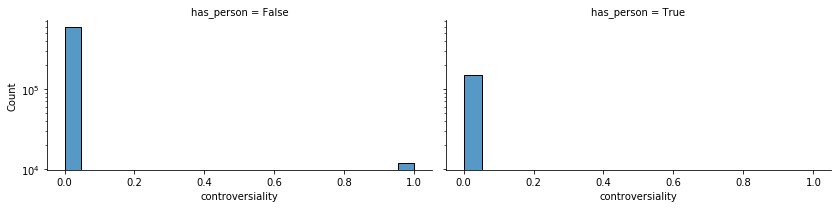

In [51]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "controversiality")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

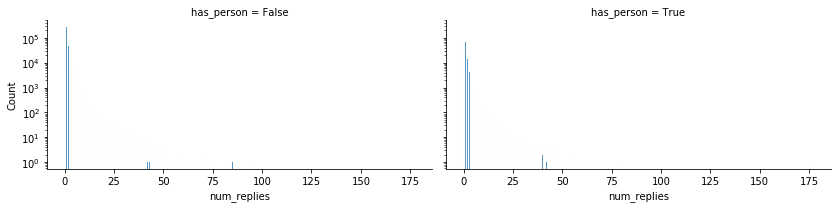

In [52]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "num_replies")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

In [54]:
g = sns.FacetGrid(people_df, col='has_person', aspect=2)
g.map(sns.histplot, "score")#, log_scale=True)
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f475d53c510> (for post_execute):


KeyboardInterrupt: 

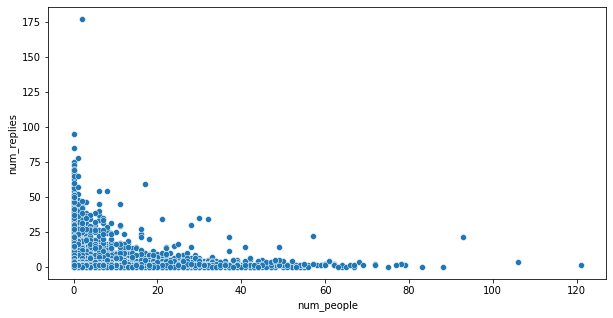

In [55]:
sns.scatterplot(data=people_df,x="num_people",y="num_replies")

In [173]:
#sns.scatterplot(data=people_df,x="num_people",y="controversiality")

In [174]:
#ax = sns.scatterplot(data=people_df,x="num_people",y="score")

## URLs

In [129]:
from urllib.parse import urlparse

def get_url_domain(url):
    url = re.split(']|\)',url)[0]
    domain = urlparse(url).netloc
    domain = re.split('.com|.org|.gov|.edu|.net', domain.split('www.')[-1])[0]
    return domain

def get_urls(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

for corp_name in corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        utt.meta['text_urls'] = get_urls(utt.text)
        utt.meta['url_domains'] = [get_url_domain(u_) for u_ in utt.meta['text_urls']]
        utt.meta['num_urls'] = len(utt.meta['text_urls'])
        utt.meta['has_url'] = utt.meta['num_urls'] > 0

<>:4: DeprecationWarning: invalid escape sequence \)
<>:4: DeprecationWarning: invalid escape sequence \)
<>:4: DeprecationWarning: invalid escape sequence \)
<ipython-input-129-e688f4df060a>:4: DeprecationWarning: invalid escape sequence \)
  url = re.split(']|\)',url)[0]
184474it [00:07, 24760.85it/s]


In [130]:
counted_url_domains = Counter([item for sublist in 
                         [utt.meta['url_domains'] for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
                         if utt.id[:2] != 't3' and utt.meta['is_awarded_delta']]
                         for item in sublist
                         ])
sorted(counted_url_domains.items(),key=lambda x: x[1],reverse=True)[:100]

[('en.wikipedia', 1259),
 ('youtube', 409),
 ('reddit', 163),
 ('ncbi.nlm.nih', 154),
 ('en.m.wikipedia', 89),
 ('nytimes', 89),
 ('youtu.be', 82),
 ('google', 77),
 ('washingtonpost', 75),
 ('i.imgur', 71),
 ('theguardian', 61),
 ('npr', 60),
 ('cdc', 52),
 ('forbes', 39),
 ('psychologytoday', 33),
 ('pewresearch', 33),
 ('theatlantic', 33),
 ('vox', 32),
 ('cnn', 31),
 ('huffingtonpost', 31),
 ('imgur', 31),
 ('politifact', 29),
 ('amazon', 29),
 ('votesmart', 29),
 ('upload.wikimedia', 23),
 ('bbc', 23),
 ('slate', 22),
 ('businessinsider', 22),
 ('nbcnews', 21),
 ('tandfonline', 21),
 ('bls', 21),
 ('abcnews.go', 20),
 ('jstor', 20),
 ('independent.co.uk', 19),
 ('nature', 18),
 ('telegraph.co.uk', 18),
 ('sciencedirect', 18),
 ('twitter', 18),
 ('cnbc', 18),
 ('merriam-webster', 18),
 ('plato.stanford', 18),
 ('economist', 17),
 ('usatoday', 17),
 ('m.youtube', 17),
 ('data.worldbank', 16),
 ('nber', 16),
 ('time', 15),
 ('fivethirtyeight', 15),
 ('pubmed.ncbi.nlm.nih', 15),
 ('me

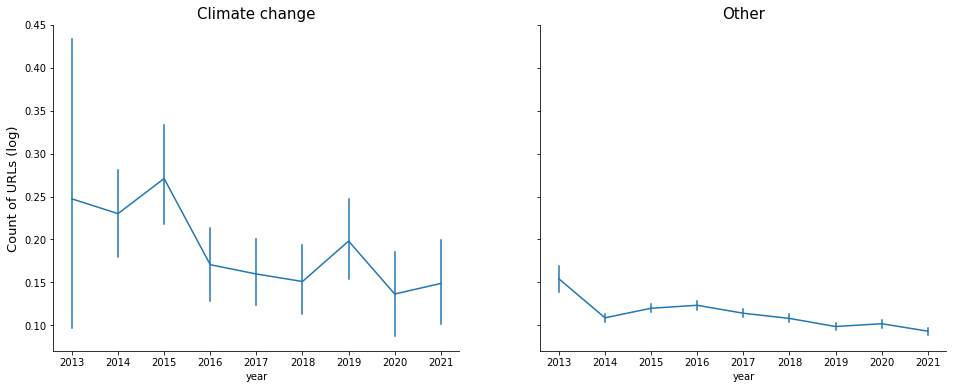

In [89]:
for corp_name in corp_to_analyze:
    to_plot_df = pd.DataFrame({
            'topic': [utt.meta['is_cc_related_gold']
                      for utt in corp_to_analyze[corp_name].iter_utterances()
                      if utt.id[:2] != 't3'],
            'year': [datetime.utcfromtimestamp(utt.timestamp).year
                     for utt in corp_to_analyze[corp_name].iter_utterances()
                     if utt.id[:2] != 't3'],
            'num_urls': [utt.meta['num_urls']
                            for utt in corp_to_analyze[corp_name].iter_utterances()
                            if utt.id[:2] != 't3'],

        })
    to_plot_df['log_num_urls'] = to_plot_df['num_urls'].apply(lambda x: np.log(x+1))

    fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=True)
    for ix_, topic_bool in enumerate([True, False]):
        ax_ = ax[ix_]
        sns.lineplot(data=to_plot_df.loc[to_plot_df['topic']==topic_bool], 
                     x='year', y='log_num_urls', ci=95,err_style='bars',
                     ax=ax_)
        if ix_ % 2 == 0:
            ax_.set_ylabel('Count of URLs (log)',fontsize=13)
            ax_.set_title("Climate change",fontsize=15)
        else:
            ax_.set_ylabel('')
            ax_.set_title("Other",fontsize=15)
        #labels = ax_.get_xticklabels()
        #print(labels[0].text)
        #print([label.__dict__ for label in ax_.get_xticklabels()[:3]])
        #ax_.set_xticklabels([label._x for label in ax_.get_xticklabels()],fontsize=14,rotation=90)
        #ax_.set_xlabel('')
    sns.despine()
    plt.savefig('figs/log_num_urls_over_time_with_error_bars_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

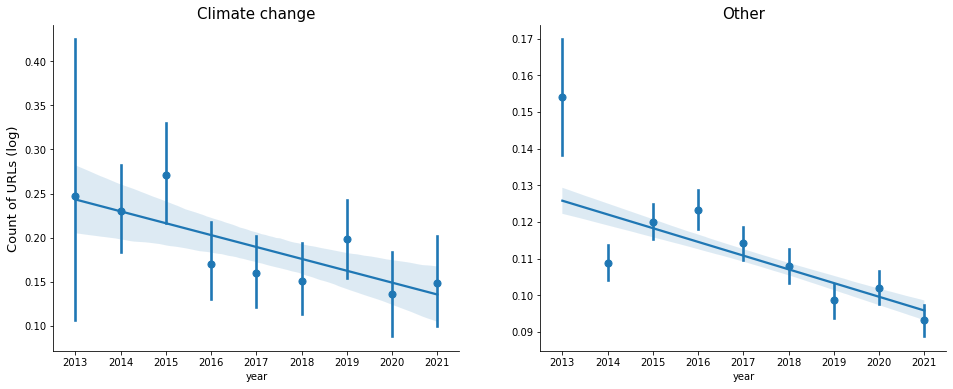

In [95]:
fig, ax = plt.subplots(1,2,figsize=(16,6),sharey=False)
for ix_, topic_bool in enumerate([True, False]):
    ax_ = ax[ix_]
    sns.regplot(data=to_plot_df.loc[to_plot_df['topic']==topic_bool], 
                 x='year', y='log_num_urls', ci=95,scatter=True,x_estimator=np.mean,
                 ax=ax_)
    if ix_ % 2 == 0:
        ax_.set_ylabel('Count of URLs (log)',fontsize=13)
        ax_.set_title("Climate change",fontsize=15)
    else:
        ax_.set_ylabel('')
        ax_.set_title("Other",fontsize=15)
sns.despine()
plt.savefig('figs/log_num_urls_over_time_regplot_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

## DeSMOG features

In [56]:
desmog_feats_dict = defaultdict(list)
for fname in glob.glob('/u/scr/yiweil/GWStance/4_analyses/lexicons/*.txt'):
    feats_cat = fname.split('/')[-1].split('.txt')[0]
    with open(fname,'r') as f:
        desmog_feats_dict[feats_cat].extend(f.read().splitlines())

In [105]:
desmog_feats_dict.keys()

dict_keys(['ANTI_WORDS', 'AFFIRM_WORDS', 'SCI_WORDS', 'VERBS_WORDS', 'DOUBT_WORDS', 'PRO_WORDS'])

## Scientific language

### Use Empath

In [ ]:
from empath import Empath
lexicon = Empath()
SCIENCE_SEEDS = desmog_feats_dict['SCI_WORDS']#

In [ ]:
', '.join(SCIENCE_SEEDS)

In [ ]:
# lexicon.create_category("science_nyt",SCIENCE_SEEDS,model="nytimes")
# lexicon.create_category("science_reddit",SCIENCE_SEEDS,model="reddit")
# lexicon.create_category("science_fic",SCIENCE_SEEDS,model="fiction")

empath_sci_feats = {}
for mod in ['nyt','reddit','fic']:
    with open(f'/juice/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/\
empath/data/user/science_{mod}.empath','r') as f:
        empath_sci_feats[mod] = f.read().split('\t')[1:]

In [284]:
for corp_name in ['matched_cc_cmv_subsample']:#corp_to_analyze:
    for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
        if utt.id[:2] != 't3':
            for empath_cat in ['science','science_nyt','science_reddit','science_fic']:
                utt.meta[empath_cat] = lexicon.analyze(utt.text, categories=[empath_cat])[empath_cat]#, normalize=False)

6349it [00:02, 2188.39it/s]


Examine temporal trend:

In [ ]:
# for corp_name in corp_to_analyze:
#     counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

#     for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#         if utt.timestamp and utt.id[:2] != 't3':
#             year = datetime.utcfromtimestamp(utt.timestamp).year
#             for empath_cat in ['science','science_nyt','science_reddit','science_fic']:
#                 if utt.meta['is_cc_related']:
#                     counts_by_bin[year]['climate change'][empath_cat] += utt.meta[empath_cat]
#                 else:
#                     counts_by_bin[year]['other'][empath_cat] += utt.meta[empath_cat]

#     years = list(range(2013,2022))
#     topics = ['climate change','other']
#     classes = ['science','science_nyt','science_reddit','science_fic']
#     to_plot_df = pd.DataFrame({
#         'year':[item for sublist in 
#                 [[y]*len(topics)*len(classes) for y in years]
#                 for item in sublist],
#         'topic':[item for sublist in 
#                 [[t]*len(classes) for t in topics]
#                 for item in sublist]*len(years),
#         'class':classes*len(years)*len(topics),
#         'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
#     })

#     per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
#     to_plot_df['norm'] = to_plot_df.apply(
#         lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
#                             .loc[x['topic']]['count'],
#         axis=1
#     )
    
#     plt.rcParams['figure.figsize'] = [10, 5]
#     g = sns.FacetGrid(to_plot_df, col='topic', hue='class', aspect=1.5, sharey=False)
#     g.map(sns.lineplot, 'year', 'norm', ci=95)
#     g.add_legend()
#     for ix_ax,ax in enumerate(g.axes[0]):
#         ax.set_xlabel('')
#         ax.set_xticklabels(ax.get_xticklabels(),fontsize=14,rotation=90)
#         if ix_ax % 2 == 0:
#             ax.set_ylabel('Normed count of lexicon features',fontsize=13)
#             ax.set_title("Climate change",fontsize=15)
#         else:
#             ax.set_title("Other",fontsize=15)
#     sns.despine()
#     plt.savefig('figs/empath_sci_features_over_time_{}.png'.format(corp_name),
#                 dpi=200,bbox_inches="tight")

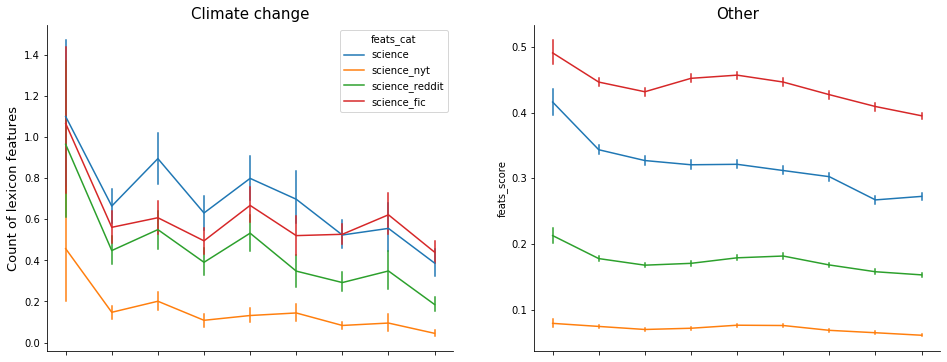

In [240]:
for corp_name in corp_to_analyze:
#     empath_cats = ['science','science_nyt','science_reddit','science_fic']
#     to_plot_df = pd.DataFrame({
#             'topic': [utt.meta['is_cc_related']
#                       for empath_cat in empath_cats
#                       for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#             'year': [datetime.utcfromtimestamp(utt.timestamp).year
#                      for empath_cat in empath_cats
#                      for utt in corp_to_analyze[corp_name].iter_utterances()
#                      if utt.id[:2] != 't3'],
#             'feats_score': [utt.meta[empath_cat]
#                             for empath_cat in empath_cats
#                             for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#             'feats_cat': [empath_cat
#                           for empath_cat in empath_cats
#                           for utt in corp_to_analyze[corp_name].iter_utterances()
#                           if utt.id[:2] != 't3'],

#         })

    fig, ax = plt.subplots(1,2,figsize=(16,6))
    for ix_, topic_bool in enumerate([True, False]):
        ax_ = ax[ix_]
        sns.lineplot(data=to_plot_df.loc[to_plot_df['topic']==topic_bool], 
                     hue='feats_cat', x='year', y='feats_score', ci=95,err_style='bars',
                     ax=ax_)
        if ix_ % 2 == 0:
            ax_.set_ylabel('Count of lexicon features',fontsize=13)
            ax_.set_title("Climate change",fontsize=15)
        else:
            ax_.set_title("Other",fontsize=15)
            ax_.get_legend().remove()
        ax_.set_xlabel('')
        ax_.set_xticklabels(ax_.get_xticklabels(),fontsize=14,rotation=90)
    sns.despine()
    plt.savefig('figs/empath_sci_features_over_time_with_error_bars_{}.png'.format(corp_name),
                dpi=200,bbox_inches="tight")

# Regressions

## Create matched pairs

In [ ]:
regression_ids = pickle.load(open('convo_utt_ids_for_regression.pkl','rb'))
regression_convo_ids, regression_utt_ids = regression_ids['convo'], regression_ids['utt']

In [ ]:
from nltk.corpus import stopwords
to_ignore = set(stopwords.words('english'))
to_ignore |= set(VAD['Word'].values)
to_ignore |= set(EMOLEX['word'].values)
# add Empath sci features

def get_jaccard_sim(utt1,utt2,to_ignore=to_ignore):
    json1 = get_stanza_json(utt1)
    json2 = get_stanza_json(utt2)
    utt1_words = [x['lemma'] if x['lemma'] is not None 
                   else x['text']
                   for sent in json1['parse']
                   for x in sent]
    utt2_words = [x['lemma'] if x['lemma'] is not None 
                   else x['text']
                   for sent in json2['parse']
                   for x in sent]
    utt1_words = set([w for w in utt1_words if w not in to_ignore]).difference(set(utt1.meta['people']))
    utt2_words = set([w for w in utt2_words if w not in to_ignore]).difference(set(utt2.meta['people']))
    return len(utt1_words.intersection(utt2_words))/len(utt1_words | utt2_words)

In [ ]:
matched_pairs = defaultdict()

for convo_id in tqdm(regression_convo_ids):
    convo = subsample.get_conversation(convo_id)
    convo_delta_awarding_ids = OP_deltas(corp_to_analyze['full_cmv'],convo_id)
    convo_delta_awarded_ids = set([awarding2awarded[x] for x in convo_delta_awarding_ids]).intersection(
        regression_utt_ids)
    non_delta_ids = set([x for x in convo.get_utterance_ids() if x[:2] == 't1'
                         and x in regression_utt_ids]).difference(
        convo_delta_awarded_ids)
    #print(f"Found {len(convo_delta_awarded_ids)} comments awarded deltas in conversation {convo_id}.")
    #print(f"Found {len(non_delta_ids)} comments not-awarded deltas in conversation {convo_id}.")
    if len(non_delta_ids) > 0:
        for delta_utt_id in convo_delta_awarded_ids: # find most similar -delta utt for each +delta utt w/ a delta
            try:
                pos_delta_utt = subsample.get_utterance(delta_utt_id)
                #print(f"\tLooking for most similar utt to '{pos_delta_utt.text}'...")
                sims = [(get_jaccard_sim(pos_delta_utt,subsample.get_utterance(utt_id)),utt_id)
                        for utt_id in non_delta_ids]
                sorted_sims = sorted(sims,key=lambda x:x[0],reverse=True)
                #print("\tSorted Jaccard similarities:",sorted_sims)
                most_sim_utt_id = sorted_sims[0][1]
                #print("\tMost similar utt:",subsample.get_utterance(most_sim_utt_id).text)
                matched_pairs[delta_utt_id] = most_sim_utt_id
            except KeyError:
                pass
            
pickle.dump(matched_pairs,open('matched_pairs_for_regression.pkl','wb'))

# Engagement

Create balanced-ish sample of comments from cc- and non-cc-related threads 
for plotting efficiency: `random_ids_to_plot`

In [41]:
# for corp_name in corp_to_analyze:
#     #if 
#     non_cc_ids_to_keep = [utt for utt in filtered_cmv_subsample.iter_utterances()
#                          if not utt.meta['is_cc_related']]
#     cc_ids_to_keep = list(set(filtered_cmv_subsample.get_utterance_ids()).difference(
#         set(non_cc_ids_to_keep)))
#     random_sample_size = 5000
#     print("Drawing random sample of {} from {} non-climate comments for plotting efficiency.".format(
#         random_sample_size,len(non_cc_ids_to_keep)))
#     random_non_cc_ids_to_plot = list(np.random.choice(non_cc_ids_to_keep,size=random_sample_size,replace=False))
#     random_cc_ids_to_plot = list(np.random.choice(cc_ids_to_keep,size=random_sample_size,replace=False))
#     random_ids_to_plot = random_non_cc_ids_to_plot + list(random_cc_ids_to_plot)
#     print("Final size of random sample of climate-related and non-climate comments:",len(random_ids_to_plot))

Drawing random sample of 5000 from 756554 non-climate comments for plotting efficiency.
Final size of random sample of climate-related and non-climate comments: 10000


In [131]:
gen_reddit_utt = corp_to_analyze['gen_reddit'].random_utterance()

In [132]:
gen_reddit_utt.meta

{'score': 7,
 'top_level_comment': 'e5iu8pm',
 'retrieved_on': 1538758820,
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'subreddit': 'baseball',
 'stickied': False,
 'permalink': '/r/baseball/comments/9dnjws/sources_tell_wdiv_detroit_that_altercation_among/e5j9ph8/',
 'author_flair_text': 'MIL bandwagon',
 'written_by_bot': False,
 'senti_arousal_cat': 'hi_neg_neut_pos'}

In [133]:
gen_reddit_utt.reply_to

'e5j14b1'

In [137]:
corp_to_analyze['gen_reddit'].get_conversation(gen_reddit_utt.conversation_id).meta

{'title': "Sources tell WDIV Detroit that altercation among Tigers' broadcasting duo involved color commentator Rod Allen choking play- by-play man Mario Impemba because of a chair in the broadcast booth",
 'num_comments': 404,
 'domain': 'clickondetroit.com',
 'timestamp': 1536270856,
 'subreddit': 'baseball',
 'gilded': 0,
 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0},
 'stickied': False,
 'author_flair_text': 'Detroit Tigers'}

In [157]:
len("Removed, see comment rule 3")

27

In [115]:
utt_eng_zip = list(zip([utt.meta['score'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['ups'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['downs'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['is_awarded_delta'] for utt in filtered_cmv_subsample.iter_utterances()],
                       [utt.meta['is_cc_related'] for utt in filtered_cmv_subsample.iter_utterances()],
                      [len(utt.meta['reply_ids']) if 'reply_ids' in utt.meta else 0
                       for utt in filtered_cmv_subsample.iter_utterances()],
                      [utt.id
                       for utt in filtered_cmv_subsample.iter_utterances()]))


eng_df = pd.DataFrame({
    'score':[item[0] for item in utt_eng_zip],
    'ups':[item[1] for item in utt_eng_zip],
    'log_ups':[np.log(item[1]+1) for item in utt_eng_zip],
    'downs':[item[2] for item in utt_eng_zip],
    'log_downs':[np.log(item[2]+1) for item in utt_eng_zip],
    'is_awarded_delta':[item[3] for item in utt_eng_zip],
    'is_cc_related':[item[4] for item in utt_eng_zip],
    'num_replies':[item[5] for item in utt_eng_zip],
    'log_num_replies':[np.log(item[5]+1) for item in utt_eng_zip],
    'id':[item[6] for item in utt_eng_zip]
})

eng_df.describe()

NameError: name 'filtered_cmv_subsample' is not defined

## Relationship/distribution of engagement variables

In [120]:
import scipy.stats as stats
stats.pearsonr(eng_df['score'].values,eng_df['log_num_replies'].values)

(0.26922011147959785, 0.0)

In [117]:
stats.spearmanr(eng_df['score'].values,eng_df['num_replies'].values)

SpearmanrResult(correlation=0.3023072129391767, pvalue=0.0)

Text(0, 0.5, 'Log num replies')

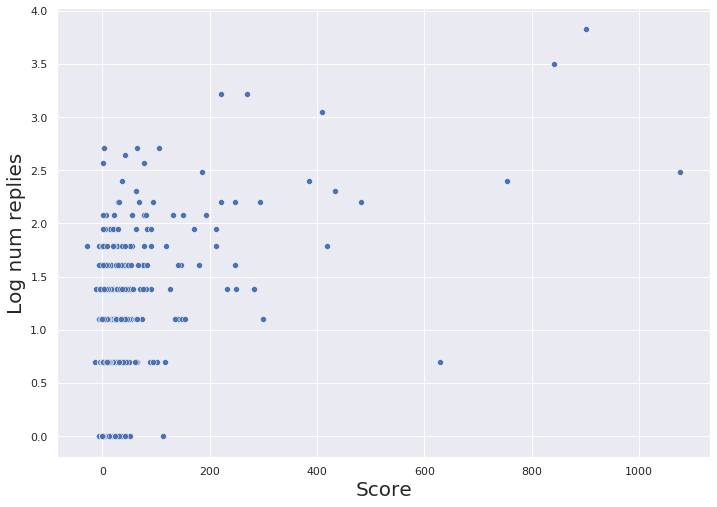

In [131]:
#random_ids_to_plot = set(random_ids_to_plot)
ax = sns.scatterplot(data=eng_df.loc[eng_df['id'].isin(random_ids_to_plot)],
               x='score',y='log_num_replies')
ax.set_xlabel("Score",fontsize=20)
ax.set_ylabel("Log num replies",fontsize=20)

#g.ax_marg_x.set_xlim(0, 100)
#g.ax_joint.set_xscale('log')
#g.ax_joint.set_yscale('log')

#ax.set(xscale="log")#, xscale="log")

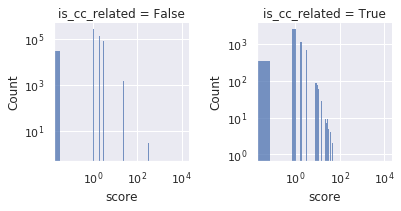

In [155]:
g = sns.FacetGrid(eng_df, col="is_cc_related", sharey=False)#, aspect=1.5)
g.map(sns.histplot, "score")
g.set(xscale="log", yscale="log")
plt.savefig('figs/log_log_score_dist.png',dpi=150,bbox_inches="tight")

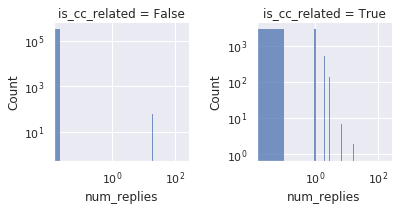

In [142]:
g = sns.FacetGrid(eng_df, col="is_cc_related", sharey=False)#, aspect=1.5)
g.map(sns.histplot, "num_replies")
g.set(yscale="log",xscale="log")#, yscale="log")

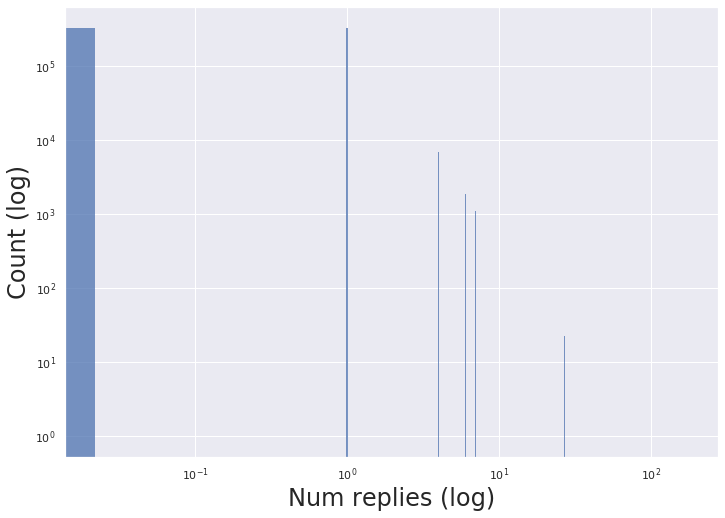

In [153]:
ax = sns.histplot(data=eng_df,x='num_replies')
ax.set(yscale="log")
ax.set(xscale="log")
ax.set_xlabel("Num replies (log)",fontsize=24)
ax.set_ylabel("Count (log)",fontsize=24)
plt.savefig('figs/log_log_num_replies_dist.png',dpi=150,bbox_inches='tight')

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


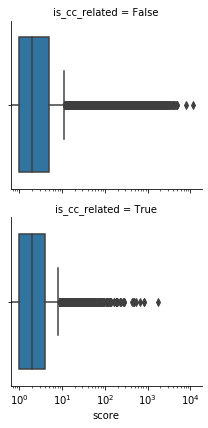

In [54]:
g = sns.FacetGrid(eng_df, row="is_cc_related", sharex=True)#, aspect=1.5)
g.map(sns.boxplot, "score")
g.set(xscale="log")#, yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


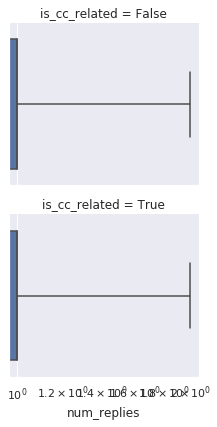

In [132]:
g = sns.FacetGrid(eng_df, row="is_cc_related", sharex=True)#, aspect=1.5)
g.map(sns.boxplot, "num_replies", showfliers=False)
g.set(xscale="log")#, yscale="log")

In [169]:
utt_eng_zip = list(zip([utt.meta['score'] for utt in filtered_gen_reddit_corpus.iter_utterances()],
                       [utt.id for utt in filtered_gen_reddit_corpus.iter_utterances()]))
                       #[utt.meta['downs'] for utt in filtered_gen_reddit_corpus.iter_utterances()]))

eng_df = pd.DataFrame({
    'score':[item[0] for item in utt_eng_zip],
    'id':[item[1] for item in utt_eng_zip]
    #'log_score':[np.log(item[0]+1) for item in utt_zip],
    #'ups':[item[1] for item in utt_eng_zip],
    #'log_ups':[np.log(item[1]+1) for item in utt_eng_zip],
    #'downs':[item[2] for item in utt_eng_zip],
    #'log_downs':[np.log(item[2]+1) for item in utt_eng_zip],
    #'upvote_ratio':[item[1]/(item[2]+.1) for item in utt_eng_zip]
})

eng_df.describe()

,score
count,270501.000000
mean,151.237104
std,2393.677951
min,-698.000000
25%,1.000000
50%,2.000000
75%,8.000000
max,195757.000000


[None, None]

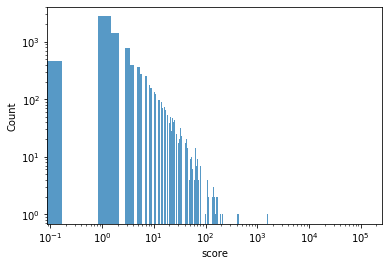

In [170]:
random_gen_reddit_sample_to_plot = set(np.random.choice(filtered_gen_reddit_corpus.get_utterance_ids(),
                                                   size=10000,replace=False))
ax = sns.histplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], x="score")
ax.set(xscale="log", yscale="log")

## Correlation of engagement with features of interest: arousal, NEs

### cmv delta-matched subsample


In [81]:
eng_df['senti_arousal_cats'] = [utt.meta['senti_arousal_cats'] 
                               for utt in filtered_cmv_subsample.iter_utterances()]
eng_df['senti_arousal_cats'] = eng_df['senti_arousal_cats'].apply(
    lambda x: '_'.join(sorted(x)))#.value_counts()
eng_df['senti_arousal_cats'].value_counts()

hi_neg_hi_pos        251081
hi_neg_lo_pos        156390
hi_pos_lo_neg        100206
lo_neg_lo_pos         82631
hi_neg_neut_pos       65974
lo_neg_neut_pos       46495
lo_pos_neut_neg       23121
hi_pos_neut_neg       20489
neut_neg_neut_pos     16557
Name: senti_arousal_cats, dtype: int64

In [109]:
eng_df['senti_arousal_cats'] = [utt.meta['senti_arousal_cat'] 
                               for utt in filtered_gen_reddit.iter_utterances()]
eng_df['senti_arousal_cats'] = eng_df['senti_arousal_cats'].apply(
    lambda x: '_'.join(sorted(x))
if type(x) == list else None)#.value_counts()
eng_df['senti_arousal_cats'].value_counts()

neut_neg_neut_pos    78822
lo_pos_neut_neg      32459
lo_neg_neut_pos      28458
hi_neg_neut_pos      28240
hi_pos_neut_neg      24467
hi_neg_hi_pos        23634
hi_neg_lo_pos        21948
lo_neg_lo_pos        17276
hi_pos_lo_neg        14934
Name: senti_arousal_cats, dtype: int64

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


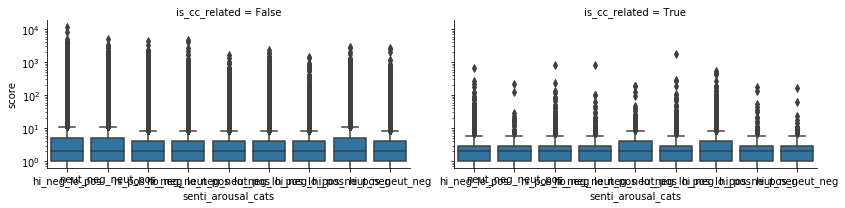

In [82]:
# Distribution over scores for different arousal categories--very even
g = sns.FacetGrid(eng_df, col = 'is_cc_related', aspect=2)
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=True,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


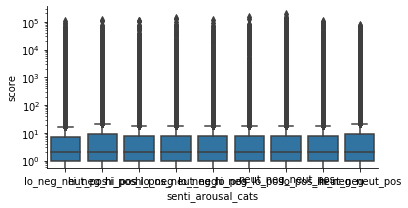

In [111]:
# Distribution over scores for different arousal categories--very even
g = sns.FacetGrid(eng_df, aspect=2)
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=True,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


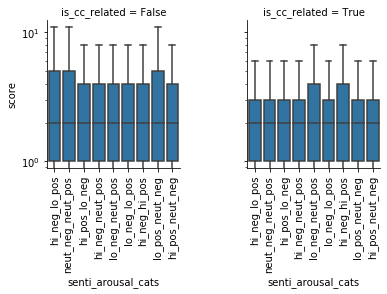

In [83]:
# Fig 1
# Same as above, without outliers--still very even
g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'senti_arousal_cats', 'score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#g.set(yscale="log")
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig('figs/score_v_senti_arousal.png',bbox_inches="tight",dpi=150)

[Text(0, 0, 'lo_neg_neut_pos'),
 Text(0, 0, 'hi_neg_hi_pos'),
 Text(0, 0, 'hi_pos_lo_neg'),
 Text(0, 0, 'hi_pos_neut_neg'),
 Text(0, 0, 'lo_neg_lo_pos'),
 Text(0, 0, 'hi_neg_lo_pos'),
 Text(0, 0, 'neut_neg_neut_pos'),
 Text(0, 0, 'lo_pos_neut_neg'),
 Text(0, 0, 'hi_neg_neut_pos')]

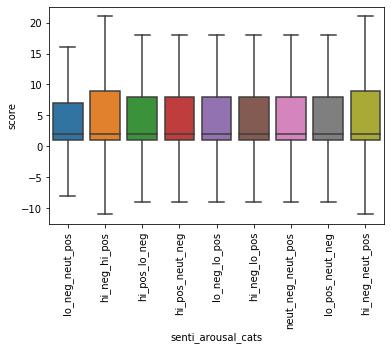

In [114]:
# Fig 
# Same as above, without outliers--still very even
#g = sns.FacetGrid(eng_df)#, col = 'is_cc_related')
ax = sns.boxplot(data=eng_df, x='senti_arousal_cats', y='score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#ax.set(yscale="log")
#for ax in g.axes.ravel():
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
#plt.savefig('figs/score_v_senti_arousal.png',bbox_inches="tight",dpi=150)

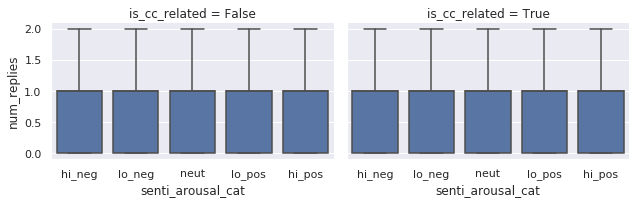

In [146]:
# Distribution over num_replies for different arousal categories--very even
#eng_df['senti_arousal_cat'] = [utt.meta['senti_arousal_cat'] for utt in filtered_cmv_subsample.iter_utterances()]
g = sns.FacetGrid(eng_df, col = 'is_cc_related', aspect=1.5)
g.map(sns.boxplot, 'senti_arousal_cat', 'num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
#g.set(yscale="log")

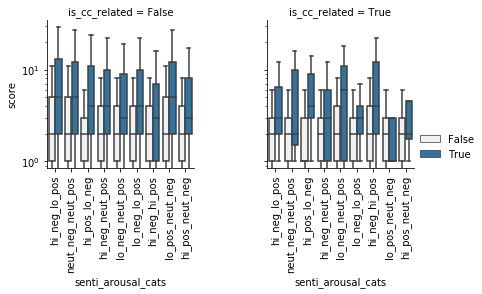

In [84]:
# Fig 2
# what about conditioned on whether or not a comment got a delta?
# score is still independent it seems of arousal for comments w/o delta
# HOWEVER, score varies across arousal category for comments w/ delta

g = sns.FacetGrid(eng_df, col = 'is_cc_related')#, hue='is_awarded_delta')
g.map_dataframe(sns.boxplot, x='senti_arousal_cats', y='score', showfliers=False,
           
               hue='is_awarded_delta')
g.set(yscale="log")
g.add_legend()
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

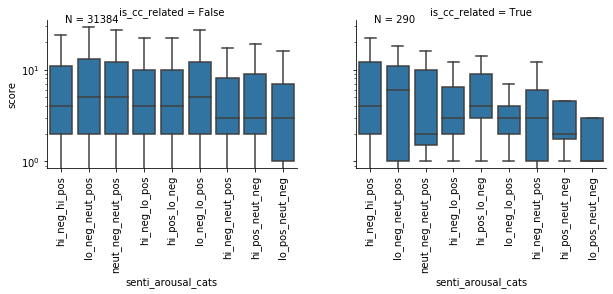

In [85]:
# Fig 3 
# looking only at comments w/ delta:
    # it seems for comments on non-climate-related posts, high arousal ~ high score
    # for comments on climate-related posts (much smaller N), situation is a bit non-linear
    
def annotate(data, **kws):
    n = len(data)
    ax = plt.gca()
    ax.text(.07, .99, f"N = {n}", transform=ax.transAxes)

g = sns.FacetGrid(eng_df.loc[eng_df['is_awarded_delta']], col = 'is_cc_related', aspect=1.5)
g.map_dataframe(sns.boxplot, x='senti_arousal_cats', y='score', showfliers=False,)
           #order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")
g.map_dataframe(annotate)
for ax in g.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

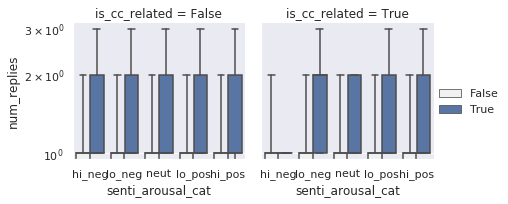

In [136]:
# what about conditioned on whether or not a comment got a delta?
# score is still independent it seems of arousal for comments w/o delta
# HOWEVER, score varies across arousal category for comments w/ delta

g = sns.FacetGrid(eng_df, col = 'is_cc_related')#, hue='is_awarded_delta')
g.map_dataframe(sns.boxplot, x='senti_arousal_cat', y='num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
               hue='is_awarded_delta')
g.set(yscale="log")
g.add_legend()

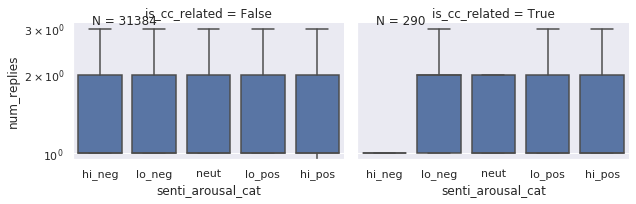

In [139]:
g = sns.FacetGrid(eng_df.loc[eng_df['is_awarded_delta']], col = 'is_cc_related', aspect=1.5)
g.map_dataframe(sns.boxplot, x='senti_arousal_cat', y='num_replies', showfliers=False,
           order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'])
g.set(yscale="log")
g.map_dataframe(annotate)

In [157]:
# Does score differ for comments w/ and w/o people?

eng_df['has_person'] = [len(filtered_cmv_subsample.get_utterance(utt_id).meta['cleaned_entities_in_text']) > 0
                              for utt_id in random_ids_to_plot]

g = sns.FacetGrid(eng_df, col = 'is_cc_related')
g.map(sns.boxplot, 'has_person', 'score', showfliers=True)
g.set(yscale="log")

KeyError: 'cleaned_entities_in_text'

In [ ]:
# Add deltas into the picture
sns.boxplot(data=eng_df, x='has_person', y='score', showfliers=False,
           hue='is_awarded_delta')

### General Reddit subsample

[None]

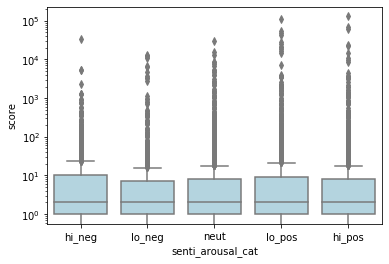

In [176]:
eng_df['senti_arousal_cat'] = [utt.meta['senti_arousal_cat']
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]
ax = sns.boxplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], 
                 x='senti_arousal_cat', y='score', showfliers=True,
               order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],color='lightblue')
ax.set(yscale="log")

[None]

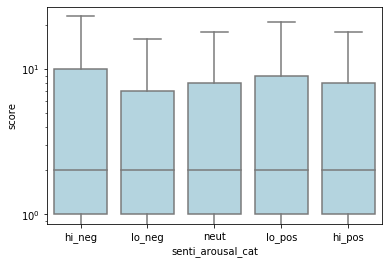

In [178]:
# without outliers
ax = sns.boxplot(data=eng_df.loc[eng_df['id'].isin(random_gen_reddit_sample_to_plot)], 
                 x='senti_arousal_cat', y='score', showfliers=False,
               order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],color='lightblue')
ax.set(yscale="log")

In [193]:
eng_df['has_person'] = [len(utt.meta['cleaned_entities_in_text']) > 0
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]
eng_df['has_person'].value_counts()

False    270400
True        101
Name: has_person, dtype: int64

[None]

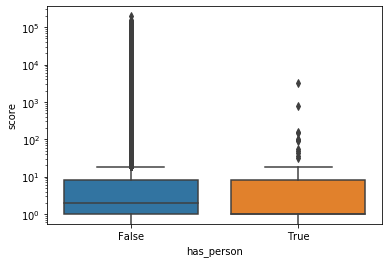

In [194]:
eng_df['has_person'] = [len(utt.meta['cleaned_entities_in_text']) > 0
                              for utt in filtered_gen_reddit_corpus.iter_utterances()]

ax = sns.boxplot(data=eng_df, 
                 x='has_person', y='score', showfliers=True)
ax.set(yscale="log")

# Comments receiving deltas vs. not

## Add +/-delta; num. deltas to meta

Maintain list of comments awarded deltas by:

iterating through all comment utterances

if: speaker.isin(known_mods) AND comment begins with a CUE_START
    
    save: id of mod comment, 
    comment awarding the delta (mod comment's reply_to parent),
    comment awarded the delta (comment awarding the delta's reply_to)

In [7]:
# CUE_STARTS = {'Confirmed: 1 delta awarded to /u/',
#              'Confirmed - 1 delta awarded to /u/',
#              'The moderators have confirmed, ei'}

# with open(os.path.join(DISK_IO_DIR,'deltalog.tsv'),'w') as f:
#     f.write('{}\t{}\t{}\n'.format('logging_utt_id','awarding_utt_id',
#                                   'awarded_utt_id'))
#     for utterance in tqdm(corpus.iter_utterances()):
#         if utterance.speaker.id in known_cmv_mods\
#         and (utterance.text.startswith('Confirmed: 1 delta awarded to /u/')\
#              or utterance.text.startswith('Confirmed - 1 delta awarded to /u/')\
#              or utterance.text.startswith('The moderators have confirmed, ei')):
#             logging_comment_id = utterance.id
#             awarding_comment_id = utterance.reply_to
#             awarded_comment_id = corpus.get_utterance(awarding_comment_id)\
#                                         .reply_to
#             f.write('{}\t{}\t{}\n'.format(
#                 logging_comment_id,awarding_comment_id,
#                     awarded_comment_id))

deltalog = pd.read_csv(os.path.join('/u/scr/yiweil/Green-American-Lexicon/1_data_collection/reddit',
                                    'deltalog.tsv'),
                      sep='\t',header=0)
delta_awarded_utt_ids = set(deltalog['awarded_utt_id'].values)
delta_counts = deltalog['awarded_utt_id'].value_counts()
utt_id2num_deltas = {id_: delta_counts[id_] for id_ in delta_counts.index.values}

# Update meta to include whether an utterance was awarded a delta or not
def is_awarded_delta(utterance_id):
    return utterance_id in delta_awarded_utt_ids

def num_deltas(utterance_id):
    if utterance_id in delta_awarded_utt_ids:
        return utt_id2num_deltas[utterance_id]
    else:
        return 0

for corp_name in corp_to_analyze:
    if corp_name in {'full_cmv', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
            utt.meta['is_awarded_delta'] = is_awarded_delta(utt.id)
            utt.meta['num_deltas'] = num_deltas(utt.id)

NameError: name 'corp_to_analyze' is not defined

Examine comments getting the most deltas:

In [58]:
delta_counts

t1_d498qau    36
t1_h4hrvgr    28
t1_ehuop0f    15
t1_cg7nbsu    14
t1_c9xf9b1    13
              ..
t1_h0735d6     1
t1_gm1gfmm     1
t1_dozxucl     1
t1_eh7bzti     1
t1_ctsigef     1
Name: awarded_utt_id, Length: 33702, dtype: int64

In [ ]:
# # examples
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] for utt_id in delta_counts.index.values[:10]]})

Within cc-related discussions:

In [65]:
cc_ids = set(corp_to_analyze['matched_cc_cmv_subsample'].get_utterance_ids())
print(len(cc_ids))
delta_counts.loc[delta_counts.index.isin(cc_ids)]

6349


t1_dl1zf88    2
t1_dh1bhuq    2
t1_f3xknsc    2
t1_efr2kcr    1
t1_dhd1ud8    1
             ..
t1_ha2hgif    1
t1_h8x5n7z    1
t1_e7gts5n    1
t1_h3fx0yw    1
t1_d8vwrpw    1
Name: awarded_utt_id, Length: 290, dtype: int64

In [ ]:
# pd.DataFrame({'text':[corp_to_analyze['matched_cmv_subsample'].get_utterance(utt_id).text
#           for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]],
#              'num_deltas':[delta_counts[utt_id] 
#                            for utt_id in delta_counts.loc[delta_counts.index.isin(cc_ids)].index.values[:10]]})

In [ ]:
# for corp_name in corp_to_analyze:
#     if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
#         sns.displot([utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
#                    log_scale=(False,True))
#         #plt.set_yscale
#         plt.title(f'Distribution of deltas in {corp_name}',fontsize=22)
#         plt.xlabel("Num deltas awarded comment",fontsize=20)
#         plt.ylabel("Num comments",fontsize=20)
#         plt.savefig(f'figs/dist_num_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

In [ ]:
#for corp_name in corp_to_analyze:
    if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:
        to_plot_df = pd.DataFrame({
            'num_deltas': [utt.meta['num_deltas'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            'score': [utt.meta['score'] for utt in corp_to_analyze[corp_name].iter_utterances()],
            #'num_people':[len(utt.meta['people']) for utt in corp_to_analyze[corp_name].iter_utterances()],
            'senti_arousal_cat':[utt.meta['senti_arousal_cat']
                                 if utt.meta['senti_arousal_cat']
                                else None
                                for utt in corp_to_analyze[corp_name].iter_utterances()],
        })
        for i,val in enumerate(['pos','neg']):
            to_plot_df['{}_arousal'.format(val)] = to_plot_df['senti_arousal_cat'].apply(
                lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                if type(x) == str else None
            )
            if i%2 == 1:
                categories=['hi','lo','neut']
            else:
                categories=['neut','lo','hi']
            to_plot_df['{}_arousal'.format(val)] = pd.Categorical(
                                                      to_plot_df['{}_arousal'.format(val)],
                                                      categories=categories,
                                                      ordered=True)
        sns.scatterplot(data=to_plot_df,x='num_deltas',y='score')
        plt.title("Score vs. num deltas")

In [ ]:
# g = sns.FacetGrid(to_plot_df, aspect=1.5, col='senti_arousal_cat')
# g.map(sns.histplot, 'num_deltas', log_scale=(False,True))
# plt.title("Num deltas vs. arousal")

In [ ]:
# # Temporal trend
# for corp_name in corp_to_analyze:
#     if corp_name in {'full', 'matched_cmv_subsample', 'matched_cc_cmv_subsample'}:

#         counts_by_bin = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

#         for utt in tqdm(corp_to_analyze[corp_name].iter_utterances()):
#             if utt.timestamp:
#                 year = datetime.utcfromtimestamp(utt.timestamp).year
#                 if utt.meta['is_cc_related']:
#                     if utt.meta['is_awarded_delta']:
#                         counts_by_bin[year]['climate change']['awarded delta'] += 1
#                     else:
#                         counts_by_bin[year]['climate change']['not awarded delta'] += 1
#                 else:
#                     if utt.meta['is_awarded_delta']:
#                         counts_by_bin[year]['other']['awarded delta'] += 1
#                     else:
#                         counts_by_bin[year]['other']['not awarded delta'] += 1
                        
#         years = list(range(2013,2022))
#         topics = ['climate change','other']
#         classes = ['awarded delta','not awarded delta']
#         to_plot_df = pd.DataFrame({
#             'year':[item for sublist in 
#                     [[y]*len(topics)*len(classes) for y in years]
#                     for item in sublist],
#             'topic':[item for sublist in 
#                     [[t]*len(classes) for t in topics]
#                     for item in sublist]*len(years),
#             'class':classes*len(years)*len(topics),
#             'count':[counts_by_bin[y][t][c] for y in years for t in topics for c in classes] 
#         })
        
#         per_year_topic_totals = to_plot_df.groupby(['year','topic']).sum()
#         to_plot_df['percent'] = to_plot_df.apply(
#             lambda x: x['count']/per_year_topic_totals.loc[x['year']]\
#                                 .loc[x['topic']]['count'],
#             axis=1
#         )

#         plt.rcParams['figure.figsize'] = [10, 5]
#         sns.lineplot(data=to_plot_df.loc[to_plot_df['class']=='awarded delta'],
#                    x='year',y='percent',hue='topic',ci='sd')
#         plt.xlabel('')
#         plt.ylabel('')
#         plt.xticks(fontsize=17)
#         plt.yticks(fontsize=14)
#         plt.title('Percentage of comments awarded ∆ over time',fontsize=24)
#         plt.legend(title='',fontsize=15)
#         sns.despine()
#         plt.savefig('figs/pct_comments_awarded_delta_over_time_{}.png'.format(corp_name),
#                     dpi=200,bbox_inches="tight")

Examples of comments awarding deltas, which explain why user was persuaded:

In [289]:
comments_awarding_deltas_climate_threads = [
    utt_id for utt_id in deltalog['awarding_utt_id'].values
    if corpus.get_utterance(utt_id).meta['is_cc_related']
]
print(len(comments_awarding_deltas_climate_threads))

pd.DataFrame({
    'id':comments_awarding_deltas_climate_threads,
    'text':[corpus.get_utterance(utt_id).text
           for utt_id in comments_awarding_deltas_climate_threads]
})

319


,id,text
0,t1_ef9tzs5,∆ Yeah that's honestly a solid point it would be nice if the government could just handle it. So another solution would bne if we could just stop being so over hyped about the issue in general.\n\nOnly issue is that I think we are in way too deep for that to work. It is at the forefront of public policy right now. Plus the changes that liberals are proposing would cost trillions of dollars and have huge impact on peoples lives....which leads to yellow vests.
1,t1_h8xaroo,[deleted]
2,t1_ejjs8tf,"Your point about diminishing returns on greenhouse gas emissions (because of common infrastructure) is a good one. Indeed, I had been imagining that Western population growth leads to emissions growth in a linear fashion. So I guess I'll give you a !delta for that.\n\nHowever, I still maintain my main view that having children isn't a good solution to climate change, on account of the fact that scientific engagement in western countries just isn't high enough. Most people are not involved in energy innovation and research, which means they're producing carbon emissions without contributing to the betterment of these technologies. Maybe if my country (USA) funded its schools better and made more of a conscious drive to shift the labor force towards energy research, then I'd feel differently about this.\n\nAlso, I think that the concept of diminishing returns could apply to energy innovation as well."
3,t1_fhqpeoe,"Yes, and they have links! I love it! \n\nKeep on sciencing, good sir!\n\n!delta"
4,t1_hb50dh3,"Δ I'll buy that. Bonus points for providing why, if fixed, it would be part of the solution to other issues too. Honestly it's the worst part of any kind of activism is battling with peoples lack of awareness. Pair with apathy it's probably the most immediate threat to humanity"
...,...,...
314,t1_ds5kees,[deleted]
315,t1_dh56ffl,∆ Thank you these articles did a great job of changing my view! This gets me thinking. Do humans have a right to keep reproducing and expanding even though that conflicts with general biological conservation? And how can we regulate that conflict?
316,t1_dcsvdvw,"∆ You know, you are right, it is definitely a case of the Dunning-Kruger effect, we just don't know how much we don't know. And I should recognize it as such, also, in the same way some people are hyperbolic negative, being hyperbolic positive is not wise, I recognize now my mistake."
317,t1_et321b6,"!delta\n\nIndividual lifestyle choices may not be useful on their own, but they can inspire others to demand change."


## Which features matter in changing people's minds?

List of features:
* engagement-related features
    * people/messengers
    * +/- arousal (based on SentiStrength)
    * EmoLex
* OG CMV paper features
    * non-textual features
        * entry time
        * len of back-and-forth
        * number of participants
    * textual features
        * interplay-related features
        * word category-based features
        * word score-based features
        * entire argument features
        * markdown formatting features
* DeSMOG features
    
    
NB: OG CMV paper uses different set-up to test importance of features by finding unsuccessful argument with highest Jaccard similarity to successful argument comment and training classifier to make binary prediction as to which one was successful. Intuition: control for content.

### Compute LOR values

In [179]:
def sub_url_with_domain(utt):
    json_obj = get_stanza_json(utt)
    new_json_obj = []
    utt_urls = utt.meta['text_urls']
    utt_domains = utt.meta['url_domains']
    for ix,utt_url in enumerate(utt_urls):
        for sent in json_obj['parse']:
            json_list = []
            for word in sent:
                #print(word['text'],utt_url)
                if word['text'] == utt_url:
                    #print('url found!')
                    word['lemma'] = f'<URL>{utt_domains[ix]}</URL>'
                json_list.append(word)
            new_json_obj.append(json_list)
    return {'parse':new_json_obj,'ents':json_obj['ents']}

In [173]:
lor_per_corp = defaultdict(dict)

In [178]:
domain_counts = Counter([item for sublist in [utt.meta['url_domains'] for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()]
        for item in sublist])
sorted(domain_counts.items(),key=lambda x:x[1],reverse=True)[:30]

[('en.wikipedia', 7105),
 ('youtube', 2617),
 ('reddit', 2365),
 ('ncbi.nlm.nih', 709),
 ('youtu.be', 603),
 ('nytimes', 598),
 ('google', 574),
 ('en.m.wikipedia', 565),
 ('washingtonpost', 519),
 ('theguardian', 440),
 ('i.imgur', 376),
 ('npr', 337),
 ('cdc', 331),
 ('imgur', 248),
 ('forbes', 248),
 ('theatlantic', 230),
 ('huffingtonpost', 209),
 ('cnn', 209),
 ('vox', 195),
 ('pewresearch', 180),
 ('businessinsider', 175),
 ('bbc', 170),
 ('politifact', 163),
 ('psychologytoday', 151),
 ('amazon', 151),
 ('upload.wikimedia', 141),
 ('sciencedirect', 139),
 ('time', 133),
 ('twitter', 133),
 ('independent.co.uk', 120)]

First get counts:

In [260]:
UPOS = False
XPOS = False
DEPPARSE = False
HEADS = False

sample1_set = set([utt.id for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
                  if utt.meta['is_awarded_delta']])
print(f"Found {len(sample1_set)} ids in sample 1.")

counts_bare = get_counts_for_lor(corp_to_analyze['matched_cmv_subsample'],
                         sample1_set,
                         [],
                         'matched_cmv_subsample_deltas_vs_no_deltas_url_subbed_gen_reddit_switchboard_prior',
                         cache=True,
                         skip_background=True,
                         min_df=5,
                         upos=UPOS,
                         xpos=XPOS,
                         depparse=DEPPARSE,
                         heads=HEADS,
                                verbose=True)
counts_bare_background = get_counts_for_lor(corp_to_analyze['matched_cmv_subsample'],
                         sample1_set,
                         [],
                         'matched_cmv_subsample_deltas_vs_no_deltas_gen_reddit_switchboard_prior',
                         cache=True,
                         skip_background=True,
                         min_df=5,
                         upos=UPOS,
                         xpos=XPOS,
                         depparse=DEPPARSE,
                         heads=HEADS)
counts_bare['prior'] = counts_bare_background['prior'].copy()
del counts_bare_background
print(counts_bare.keys())

Found 24238 ids in sample 1.
Loading counters from cache...
Loading counters from cache...
dict_keys(['corpus1', 'corpus2', 'prior'])


In [261]:
counts_bare['corpus1']['<URL>forbes</URL>']

158

In [262]:
for corp_name in ['matched_cmv_subsample']:#corp_to_analyze:
    weighted_lor_bare = do_weighted_lor(counts_bare['corpus1'], counts_bare['corpus2'], 
                                         counts_bare['prior'], 
                                         prior_weight=10, 
                                         counts1_weight=1, 
                                         counts2_weight=3, 
                                         verbose=False)
    lor_per_corp[corp_name]['weighted_bare'] = weighted_lor_bare

Size of class1: 2623653
Size of class2: 2524093
Size of prior: 3041380


In [263]:
lor_per_corp['matched_cmv_subsample']['weighted_bare']['<URL>forbes</URL>']

0.006456218396408883

In [264]:
# URL-domain-subbed, weights = 1:5; 10(prior)
sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
 for w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
if abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('Perl', 22.36340584975672),
 ('rep', 17.270576286718885),
 ('Tesla', 15.894697418298607),
 ('dem', 13.674989086399513),
 ('musk', 12.1138912994852),
 ('Steven', 11.821722751959104),
 ('label', 11.275064278495085),
 ('UBI', 10.664885833086624),
 ('Act', 10.642948971702928),
 ('she', 10.451068054759645),
 ('candidate', 10.123006538348674),
 ('code', 10.052817132741895),
 ('Donald', 9.805260301825488),
 (':)', 9.721848960705959),
 ('e.g.', 9.2563194128867),
 ('Atheist', 8.889758549178396),
 ('language', 8.49829424261911),
 ('reform', 8.494325795109553),
 ('write', 8.37230686411755),
 ('mrna', 8.315086793493087),
 ('0', 8.173830894998277),
 ('Pearl', 8.153084653153474),
 ('strength', 8.042442049895202),
 ('critic', 8.003627063469274),
 ('community', 7.936163728204206),
 ('veal', 7.917945155231595),
 ('modernization', 7.872665640183634),
 ('4chan', 7.843029057500373),
 ('dubstep', 7.78196536404077),
 ('Reade', 7.707231948120927),
 ('Turkey', 7.621336443330188),
 ('Iran', 7.501111582998482

In [270]:
bjs_utts = [utt for utt in corp_to_analyze['matched_cmv_subsample'].iter_utterances()
 if 'open.spotify' in set(utt.meta['url_domains'])]
len(bjs_utts)

7

In [272]:
Counter([utt.meta['is_awarded_delta'] for utt in bjs_utts])

Counter({False: 6, True: 1})

In [271]:
[utt.text for utt in bjs_utts]

['Part of the point of 4\'33" of silence was that there was no such thing as silence. John Cage expands on this point in *Silence* to argue that any sound can be music since it is ultimately narrow minded habit that causes us to exclude the world of noise from what is "music." He would also make the point that the performance is ultimately not separate from the music; in fact, he would argue that the traditional conception of music is due to a type of elitist theater. That is why there is music made in helicopters. \n\nAnyhow, John Cage invented the [prepared piano](https://www.youtube.com/watch?v=pUTXNxFvjDw) as an extension of this idea that we should break the bounds of the traditional noises from a piano. He would put nails into the piano. It is hard to listen to but that isn\'t the point. The point was experimentation. It eventually produced beautiful music through the artist [Hauschka](https://www.youtube.com/watch?v=HYsvlJgtAgY&t=10s).\n\nThese pieces you complain about, althoug

In [265]:
sig_urls = {w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
 for w in sig_vals if w.startswith('<URL>')}
sorted(sig_urls.items(),key=lambda x:x[1],reverse=True)

[('<URL>hillaryclinton</URL>', 7.211279408583122),
 ('<URL>open.spotify</URL>', 7.137726143131212),
 ('<URL>nationmaster</URL>', 6.387297584856927),
 ('<URL>i.imgur</URL>', 6.341606035367493),
 ('<URL>govtrack.us</URL>', 5.4904813558559455),
 ('<URL>papers.ssrn</URL>', 5.4632733060746075),
 ('<URL>hdr.undp</URL>', 5.085840635636199),
 ('<URL>data.worldbank</URL>', 5.075875259059722),
 ('<URL>igmchicago</URL>', 4.838708268704931),
 ('<URL>irp.wisc</URL>', 4.824584133910021),
 ('<URL>theregister.co.uk</URL>', 4.6565154003626015),
 ('<URL>bjs</URL>', 4.650719694306102),
 ('<URL>newscientist</URL>', 4.621542412368362),
 ('<URL>berniesanders</URL>', 4.473980983679933),
 ('<URL>np.reddit</URL>', 4.296090667302304),
 ('<URL>economist</URL>', 4.16903089118217),
 ('<URL>bbc.co.uk</URL>', 4.1269244393916935),
 ('<URL>s-media-cache-ak0.pinimg</URL>', 4.123509884268923),
 ('<URL>jstor</URL>', 4.05691163324499),
 ('<URL>chicagobooth</URL>', 3.950385969389478),
 ('<URL>cnbc</URL>', 3.825840945139208

In [269]:
print(', '.join([f'{x[0][5:-6]} ({round(x[1],2)})' for x in sorted(sig_urls.items(),key=lambda x:x[1],reverse=False)[:25]]))

reddit (-16.76), everydayfeminism (-13.03), link.springer (-8.24), sciencedirect (-6.35), clarissethorn (-6.11), youtube (-5.98), google (-5.94), tvtropes (-5.66), thinkprogress (-5.35), pediatrics.aappublications (-4.92), huffingtonpost.co.uk (-4.8), youtu.be (-4.77), who.int (-4.34), onlinelibrary.wiley (-4.18), rainn (-3.99), epi (-3.99), gires (-3.8), sciencedaily (-3.74), whatweknow.inequality.cornell (-3.48), pbs (-3.43), docs.google (-3.1), huffingtonpost (-3.08), theatlantic (-3.0), investopedia (-2.97), en.m.wikipedia (-2.97)


In [ ]:
### CC only, weights = 1:20; 100(prior)
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [341]:
', '.join([x[0] for x in sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)])

'co2, climate, dioxide, carbon, carbon dioxide, ocean, www skepticalscience, the 97, skepticalscience, skepticalscience com, greenhouse, natural cycle, atmosphere be, warming, of co2, methane, climate change, biodiversity'

In [353]:
# all CMV, weights = 1:15; 2(prior)
sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
 for w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
if abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('the', 11.65223593438836),
 ('and', 9.044503936958723),
 ('of', 8.830251953672748),
 ('in', 8.495489394793362),
 ('be', 6.935466565549153),
 ('to', 6.672344854048106),
 ('org', 6.378605205762511),
 ('this', 5.698767242889603),
 ('they', 5.060941526720041),
 ('on', 4.823586586174394),
 ('that', 4.790308555141541),
 ('but', 4.757179591663222),
 ('with', 4.624515535407693),
 ('for', 4.603754234044307),
 ('delta', 4.458204454307972),
 ('of the', 4.309174770514293),
 ('https en', 4.285298831864885),
 ('org wiki', 4.241611609072515),
 ('en', 4.2236784848163),
 ('it', 4.180457274827762),
 ('wikipedia', 4.119898932602194),
 ('wikipedia org', 4.108473012634816),
 ('en wikipedia', 4.096150259645583),
 ('at', 4.072908946144148),
 ('in the', 4.04918598931869),
 ('as', 3.9444962675971302),
 ('pdf', 3.8483769056064707),
 ('from', 3.767372007755723),
 ('often', 3.7574842418604413),
 ('might', 3.6145568063771374),
 ('more', 3.566763120142677),
 ('good', 3.5611504463673147),
 ('he', 3.489783708538045

In [208]:
'research' in all_empath_sci_feats

True

In [81]:
# weights = 1:20
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('the', 4.4302531538826235),
 ('co2', 4.016102779647343),
 ('a', 3.6958391316434254),
 ('%', 3.27900082888966),
 ('poor', 3.0976039497792205),
 ('experiment', 3.0424920188000733),
 ('dioxide', 3.0424920188000733),
 ('ocean', 2.954950657988805),
 ('carbon', 2.8240499604875784),
 ('CCP', 2.753984186194391),
 ('be', 2.6021516116289285),
 ('cycle', 2.5479712046109273),
 ('per', 2.5382071565705706),
 ('gallon', 2.448384646847179),
 ('Science', 2.448384646847179),
 ('greenhouse', 2.41632292750537),
 ('97', 2.413320700127313),
 ('action', 2.401585299286658),
 ('rich', 2.3418134481657575),
 ('ecosystem', 2.334966622594344),
 ('biodiversity', 2.325489454781162),
 ('release', 2.266239008606097),
 ('seaweed', 2.2661594089949384),
 ('methane', 2.2517828462681706),
 ('organic', 2.2405143977054625),
 ('Chinese', 2.2405143977054625),
 ('Climate', 2.221307313261586),
 ('atmosphere', 2.191767559255129),
 ('battery', 2.176345301888634),
 ('effect', 2.153029738413637),
 ('water', 2.1413696008766516),
 (

In [147]:
# cc-only; weights = 1:15; with switchboard + gen reddit background
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('co2', 3.073409887010761),
 ('poor', 3.0468640464438366),
 ('experiment', 2.935999024612736),
 ('dioxide', 2.935999024612736),
 ('CCP', 2.8259325333936167),
 ('Science', 2.5652632762584426),
 ('ocean', 2.417681387726944),
 ('gallon', 2.3718752019230416),
 ('seaweed', 2.362943692821538),
 ('per', 2.354143934908629),
 ('rich', 2.251348124565579),
 ('preservation', 2.2345503013288663),
 ('chemistry', 2.2325408051593065),
 ('biodiversity', 2.2325408051593065),
 ('cycle', 2.228912483832722),
 ('%', 2.203216550745488),
 ('97', 2.1494354909751343),
 ('release', 2.1341811718403463),
 ('battery', 2.112940911364332),
 ('al.', 2.0945069435538954),
 ('ecosystem', 2.072538167736246),
 ('methane', 2.021694522720207),
 ('butcher', 1.9727312617433763),
 ('spend', -1.9854550035112353),
 ('problem', -2.1041447334295675),
 ('say', -2.165822551593976),
 ('have', -2.1837199073610107),
 ('civilization', -2.186938705088744),
 ('economist', -2.2009175638399103),
 ('drought', -2.303192177434896),
 ('you', -2

In [96]:
# cc-only; weights = 1:15; no background (just 2 samples summed)
sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
 for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

[('poor', 3.713671364499459),
 ('co2', 3.2295807306411852),
 ('experiment', 3.203951655197919),
 ('dioxide', 2.9911401258015),
 ('per', 2.8989588291733894),
 ('CCP', 2.844079322574466),
 ('rich', 2.7421704393263613),
 ('Science', 2.5946945876398217),
 ('ocean', 2.5735458269633043),
 ('release', 2.566973670172775),
 ('battery', 2.4794890558012255),
 ('gallon', 2.404942741828649),
 ('cycle', 2.401765556567715),
 ('seaweed', 2.387298764123448),
 ('%', 2.3487778703293536),
 ('chemistry', 2.3386072864477616),
 ('biodiversity', 2.265351694926317),
 ('preservation', 2.2587407880686805),
 ('97', 2.19121246662543),
 ('local', 2.172246272776472),
 ('ecosystem', 2.132717534315285),
 ('action', 2.125024904123274),
 ('al.', 2.118505571502948),
 ('unit', 2.11660533465535),
 ('methane', 2.0680575117728566),
 ('20', 1.9951863705248571),
 ('butcher', 1.99025136273504),
 ('greenhouse', 1.9743014656083901),
 ('organic', 1.9622396003718359),
 ('Chinese', 1.9622396003718359),
 ('fertilizer', 1.957498656869

In [ ]:
# # all CMV; weights = 1:15; with switchboard + gen reddit background
# sig_vals = {w: lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [145]:
# # weight = 1:10
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.96}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

In [146]:
# # weight = 1:5
# sig_vals = {w: lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w] 
#  for w in lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos']
# if abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_wo_pos'][w]) > 1.9}
# sorted(sig_vals.items(),key=lambda x:x[1],reverse=True)

### Test RQs

##### Draw random sample from -delta comments for more even sample sizes for LOR (NO LONGER NEEDED w/ WEIGHTED LOR)

In [175]:
# cc_ids = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
#                          if utt.meta['is_cc_related']]
# non_delta_ids_to_keep = [utt.id for utt in filtered_cmv_subsample.iter_utterances()
#                          if not utt.meta['is_awarded_delta']
#                         and utt.meta['is_cc_related']]
# delta_ids_to_keep = set(cc_ids).difference(set(non_delta_ids_to_keep))
# print('Found {} comments w/ deltas.'.format(len(delta_ids_to_keep)))

# random_sample_size = len(delta_ids_to_keep)
# print("Drawing random sample of equal size of {} from {} non-delta comments total for LOR balance.".format(
#     random_sample_size,len(non_delta_ids_to_keep)))

# random_non_delta_ids_for_lor = list(np.random.choice(non_delta_ids_to_keep,size=random_sample_size,replace=False))
# random_ids_for_lor = set(list(delta_ids_to_keep) + list(random_non_delta_ids_for_lor))
# print("Final size of delta-balanced sample of climate-related and non-climate comments:",len(random_ids_for_lor))

In [176]:
# random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# # balanced for +/- delta
# random_sample.print_summary_stats()

In [177]:
# cc_random_sample = filtered_cmv_subsample.filter_utterances_by(lambda utt: utt.id in random_ids_for_lor) 
# # balanced for +/- delta
# cc_random_sample.print_summary_stats()

##### RQ1: Is there a messenger effect for changing people's minds?

--> Are comments with deltas more likely to have people/named entities 
compared to comments not receiving deltas?

--> Do people/named entities tend to have large, positive LOR values?

--> Calculate LOR values for all people/named entities and look at their distributions--tend to skew positive?

In [ ]:
# # Plot distribution over +/- person for comments +/- deltas

# for corp_name in corp_to_analyze:
#     to_plot_df = pd.DataFrame({
#         'is_awarded_delta': [utt.meta['is_awarded_delta']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#         'num_deltas': [utt.meta['num_deltas']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'has_person': [len(utt.meta['people']) > 0
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'num_people': [len(utt.meta['people'])
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3']

#     })

#     g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
#     g.map(sns.histplot, "num_people")
#     g.axes[0][0].set_yscale('log')
#     g.axes[0][1].set_yscale('log')
#     plt.savefig(f'figs/people_counts_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")
    
#     g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
#     g.map(sns.histplot, "has_person")
#     g.axes[0][0].set_yscale('log')
#     g.axes[0][1].set_yscale('log')
#     plt.savefig(f'figs/people_boolean_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")
#     plt.show()
    
#     fig, ax = plt.subplots()
#     fig.set_size_inches(4, 7)
#     sns.barplot(data=to_plot_df, x='is_awarded_delta',y="num_people", ax=ax)
#     ax.set_xlabel('')
#     ax.set_xticklabels(['-delta','+delta'],fontsize=18)
#     ax.set_ylabel('Number of people in comment',fontsize=18)
#     sns.despine()
#     plt.savefig(f'figs/people_deltas_vs_no_deltas_barplot_{corp_name}.png',dpi=150,bbox_inches='tight')
#     plt.show()

In [286]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['num_people'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['num_people'].values)

Ttest_indResult(statistic=1.9118281701798976, pvalue=0.05594321688115575)

In [210]:
# Check if people show up in sig. LOR
{w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
for w in counted_people.keys()
if w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}

{'anakin': 1.9306656970520502,
 'harry': 2.442573572315126,
 'jesus': 2.8013219047876907,
 'phil': 2.158466487794158,
 'john': 2.1921700706132103,
 'steve': 2.0803680343541684,
 'trayvon': -1.9575906607049192,
 'kanye': 2.1267502062667853,
 'dale': 2.673781660435547,
 '4chan': 3.2597054143249267,
 'steven': 3.8705827514950935,
 'zimmerman': -2.447521790753426,
 'fox': 1.9767793468978048,
 'wayne': 1.9621376238674135,
 'alito': 2.0890688543229308,
 'sherlock': 2.9155502282310977,
 'mrna': 3.6249980626315232,
 'simon': 2.1706929062820626,
 'jane': 2.3909312706241526}

In [287]:
# Check if people show up in sig. LOR
{w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
for w in counted_people.keys()
if w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}

{}

###### RQSci: Does science help sway opinions?

In [ ]:
# # Plot distribution over #sci_words for comments +/- deltas

# for corp_name in corp_to_analyze:
#     to_plot_df = pd.DataFrame({
#         'is_awarded_delta': [utt.meta['is_awarded_delta']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                             if utt.id[:2] != 't3'],
#         'num_deltas': [utt.meta['num_deltas']
#                              for utt in corp_to_analyze[corp_name].iter_utterances()
#                       if utt.id[:2] != 't3'],
#         'science': [utt.meta['science']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],
#         'science_nyt': [utt.meta['science_nyt']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],
#         'science_reddit': [utt.meta['science_reddit']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                           if utt.id[:2] != 't3'],
#         'science_fic': [utt.meta['science_fic']
#                        for utt in corp_to_analyze[corp_name].iter_utterances()
#                        if utt.id[:2] != 't3'],

#     })
#     for col in ['num_deltas','science','science_nyt','science_reddit','science_fic']:
#         to_plot_df[f'log_{col}'] = to_plot_df[col].apply(lambda x: math.log(x+1))

# #     fig, axes = plt.subplots(4,2,figsize=(8,15))
# #     row_ix = 0
# #     for delta_ix,delta_bool in enumerate([False,True]):
# #         for cat_ix,empath_cat in enumerate(['science','science_nyt','science_reddit','science_fic']):
# #             ax_ = axes[cat_ix][delta_ix]
# #             sns.histplot(to_plot_df.loc[(to_plot_df['is_awarded_delta']==delta_bool)],
# #                             x=empath_cat,ax=ax_)
# #             ax_.set_xlabel(f"Count of {empath_cat} features",fontsize=13)
# #             ax_.set_yscale('log')
# #             if delta_ix % 2 == 0:
# #                 ax_.set_ylabel("#Comments",fontsize=15)
# #                 if cat_ix == 0:
# #                     ax_.set_title('not awarded delta',fontsize=18)
# #             else:
# #                 ax_.set_ylabel("")
# #                 if cat_ix == 0:
# #                     ax_.set_title('awarded delta',fontsize=18)
# #             sns.despine()
# #     plt.savefig(f'figs/dists_empath_sci_feats_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches="tight")

#     fig, axes = plt.subplots(1,4,figsize=(10,4),sharey=True)
#     for cat_ix,empath_cat in enumerate(['science','science_nyt','science_reddit','science_fic']):
#         ax_ = axes[cat_ix]
#         sns.barplot(data=to_plot_df,x='is_awarded_delta',y=empath_cat,ax=ax_,ci=95)
#         ax_.set_xlabel('')
#         ax_.set_xticklabels(['-delta','+delta'],fontsize=14)
#         ax_.set_ylim([0,1.3])
#         ax_.set_ylabel('')
#         ax_.set_title(f'{empath_cat}',fontsize=14)
#         sns.despine()
#     plt.savefig(f'figs/barplots_empath_sci_feats_deltas_vs_no_deltas_{corp_name}.png',dpi=150,bbox_inches='tight')

In [293]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science'].values)

Ttest_indResult(statistic=3.685231098569228, pvalue=0.00023039937215591438)

In [294]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_nyt'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_nyt'].values)

Ttest_indResult(statistic=2.0158037843727756, pvalue=0.04386255800801137)

In [295]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_reddit'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_reddit'].values)

Ttest_indResult(statistic=1.0015507354642577, pvalue=0.3165988057867682)

In [296]:
stats.ttest_ind(to_plot_df.loc[to_plot_df['is_awarded_delta']]['science_fic'].values,
                to_plot_df.loc[~to_plot_df['is_awarded_delta']]['science_fic'].values)

Ttest_indResult(statistic=3.009314222824129, pvalue=0.002628665963912681)

In [264]:
# Check if sci_feats show up in sig. LOR
all_empath_sci_feats = set([item for sublist in empath_sci_feats.values() for item in sublist])

sorted({w: lor_per_corp['matched_cmv_subsample']['weighted_bare'][w] 
for w in all_empath_sci_feats
if w in lor_per_corp['matched_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]) > 1.9}.items(),key=lambda x:x[1],reverse=True)

[('research', 4.309916014662114),
 ('study', 3.889331733568624),
 ('improve', 3.3018885017899806),
 ('critical', 3.037568272902809),
 ('development', 2.9749460027468566),
 ('benefit', 2.6117792121143064),
 ('researcher', 2.343351001221101),
 ('establish', 2.296586711057056),
 ('philosophy', 2.2809980895352164),
 ('accomplish', 2.2344748490095547),
 ('modify', 2.176347762098813),
 ('access', 2.039409590772334),
 ('function', 2.0304489756280772),
 ('limit', 1.9948744906612708),
 ('scientist', 1.9920246207603145),
 ('evaluate', 1.9752297722013117),
 ('present', 1.9054237394453248),
 ('review', -3.3841281454538312),
 ('subject', -7.295347094902295),
 ('appeal', -18.647944328848926)]

In [297]:
sorted({w: lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w] 
for w in all_empath_sci_feats
if w in lor_per_corp['matched_cc_cmv_subsample']['weighted_bare']
and abs(lor_per_corp['matched_cc_cmv_subsample']['weighted_bare'][w]) > 1.9}.items(),key=lambda x:x[1],reverse=True)

[]

In [300]:
to_plot_df.loc[to_plot_df['lor']<-3]

,word,lor


outliers:         word        lor
47    review  -3.384128
53   subject  -7.295347
171   appeal -18.647944


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


outliers: Empty DataFrame
Columns: [word, lor]
Index: []


/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.


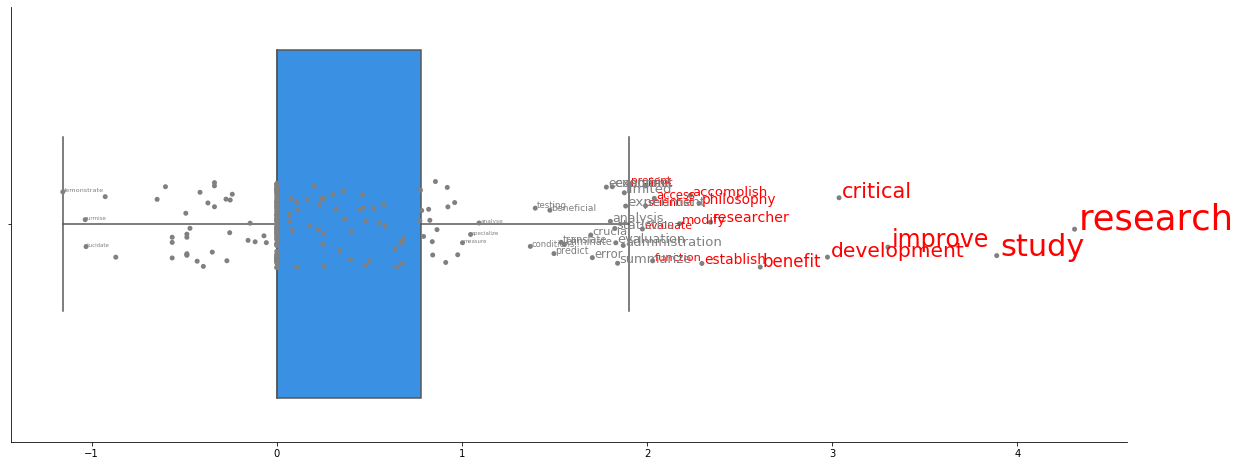

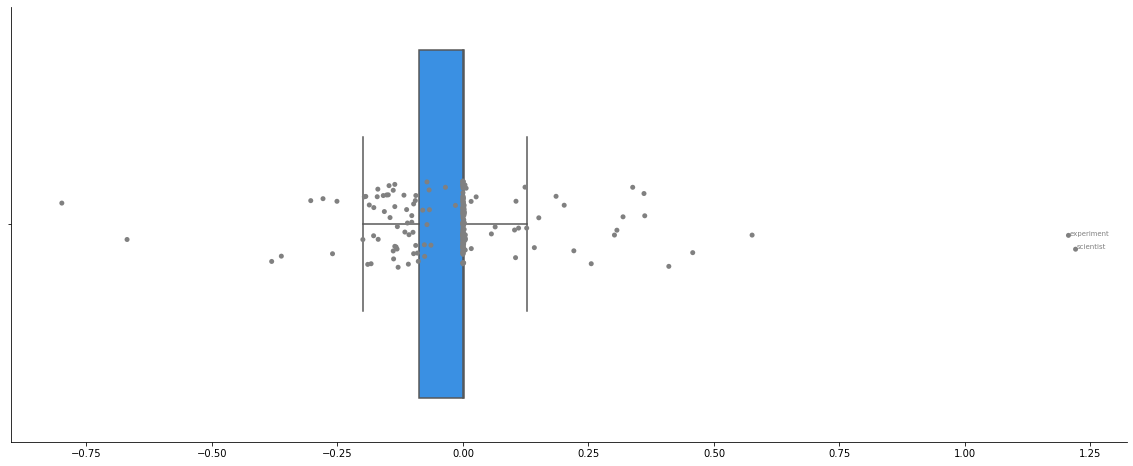

In [342]:
for corp_name in corp_to_analyze:
    to_plot_df = pd.DataFrame({
        'word': [w for w in all_empath_sci_feats],
        'lor': [lor_per_corp[corp_name]['weighted_bare'][w]
                   for w in all_empath_sci_feats]
    })
    
    print('outliers:',to_plot_df.loc[to_plot_df['lor']<-3])
    
    to_plot_df = to_plot_df.loc[to_plot_df['lor']>-3].copy()

    fig, ax = plt.subplots(figsize=(20,8))
    sns.boxplot(data=to_plot_df, x='lor', ax=ax, color='dodgerblue',showfliers=False)
    sns.stripplot(data=to_plot_df, x='lor', ax=ax, jitter=True,dodge=True,color='gray')
    xs,ys = np.array(ax.collections[0].get_offsets()).T
    for i in range(len(to_plot_df)):
        if abs(to_plot_df['lor'].values[i]) > 1.9:
            ax.annotate(to_plot_df['word'].values[i],
                    xy=(xs[i],ys[i]),textcoords='offset points',color='red',
                        fontsize=abs(to_plot_df['lor'].values[i]*2.5)**1.5)
        elif abs(to_plot_df['lor'].values[i]) > 1:
            ax.annotate(to_plot_df['word'].values[i],
                    xy=(xs[i],ys[i]),textcoords='offset points',color='gray',
                        fontsize=abs(to_plot_df['lor'].values[i]*3)**1.5)
        else:
            pass
    sns.despine()
    ax.set_xlabel('')
    plt.savefig(f'figs/dist_lor_empath_sci_feats_{corp_name}.png',dpi=150,bbox_inches="tight")

/u/nlp/anaconda/main/anaconda3/envs/yiwei-climate/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


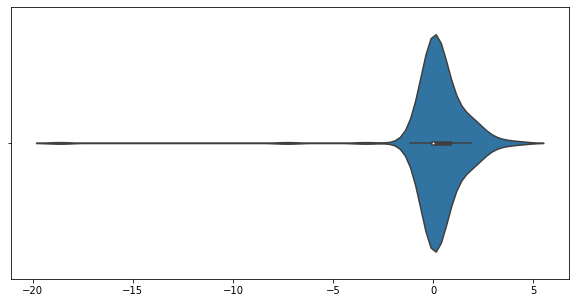

In [241]:
sns.violinplot([lor_per_corp['matched_cmv_subsample']['weighted_bare'][w]
               for w in all_empath_sci_feats])

##### RQ2: Do high +/- arousal words change people's minds?

--> Are comments with deltas more likely to be high arousal?

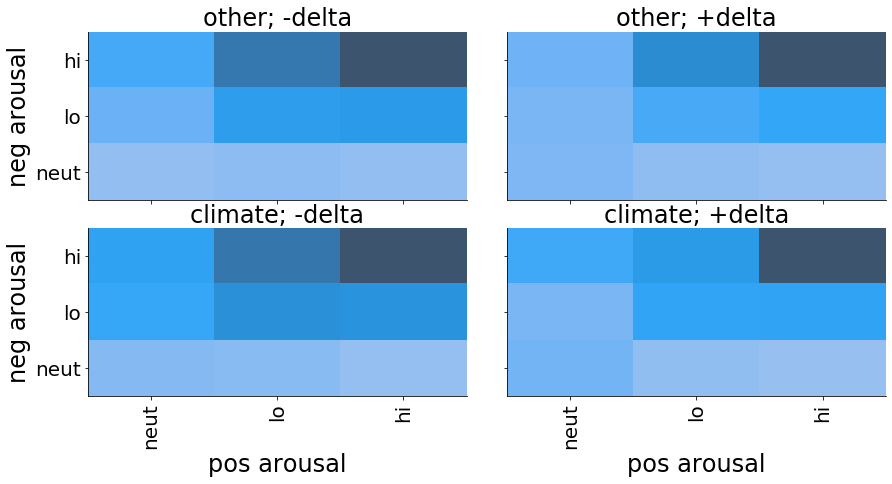

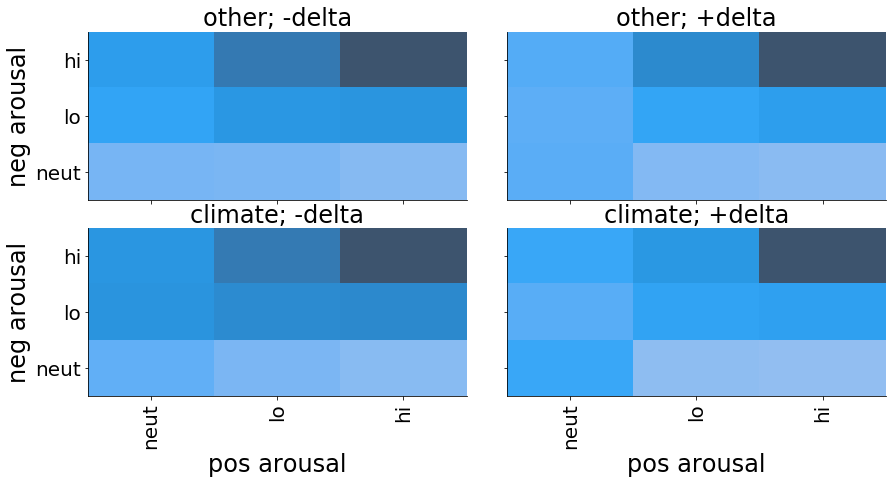

In [113]:
# Fig 4: Distribution of SentiStrength arousal categories for comments
for corp_name in corp_to_analyze:
    if 'cmv' in corp_name:
        # prep data to plot
        to_plot_df = pd.DataFrame({
            'is_awarded_delta': [utt.meta['is_awarded_delta']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                if utt.meta['senti_all_arousal_cat']],
            'senti_all_arousal_cat': [utt.meta['senti_all_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'senti_adxs_only_arousal_cat': [utt.meta['senti_adxs_only_arousal_cat']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                                 if utt.meta['senti_all_arousal_cat']],
            'is_cc_related': [utt.meta['is_cc_related']
                                for utt in corp_to_analyze[corp_name].iter_utterances()
                             if utt.meta['senti_all_arousal_cat']]})
        
        SENTI_CATS = to_plot_df['senti_all_arousal_cat'].value_counts().index
        for senti_model in ['all','adxs_only']:
            to_plot_df[f'senti_{senti_model}_arousal_cat'] = \
            pd.Categorical(to_plot_df[f'senti_{senti_model}_arousal_cat'],
                           categories=SENTI_CATS,
                           ordered=True)
        
            # further prepping: isolate +/- SS components
            for i,val in enumerate(['pos','neg']):
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                to_plot_df[f'senti_{senti_model}_arousal_cat'].apply(
                    lambda x: x.split('_{}'.format(val))[0].split('_')[-1]
                )
                if i%2 == 1:
                    categories=['hi','lo','neut']
                else:
                    categories=['neut','lo','hi']
                to_plot_df[f'{senti_model}_{val}_arousal'] = \
                pd.Categorical(to_plot_df[f'{senti_model}_{val}_arousal'],
                               categories=categories,
                               ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, f"{senti_model}_pos_arousal", f"{senti_model}_neg_arousal")
            #g.map(sns.histplot, "senti_arousal_cat")

            # aesthetics
            for ax_ix,ax in enumerate(g.axes.ravel()):
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
                if ax_ix % 2 == 0:
                    ax.set_yticklabels(ax.get_yticklabels(), fontsize=20)
                    ax.set_ylabel("neg arousal",fontsize=24)
                else:
                    ax.set_yticklabels('')
                if ax_ix >= 2:
                    ax.set_xlabel("pos arousal",fontsize=24)

            # saving
            plt.savefig(f'figs/senti_arousal_dist_deltas_vs_no_deltas_{corp_name}_{senti_model}.png',
                       dpi=150,bbox_inches="tight")

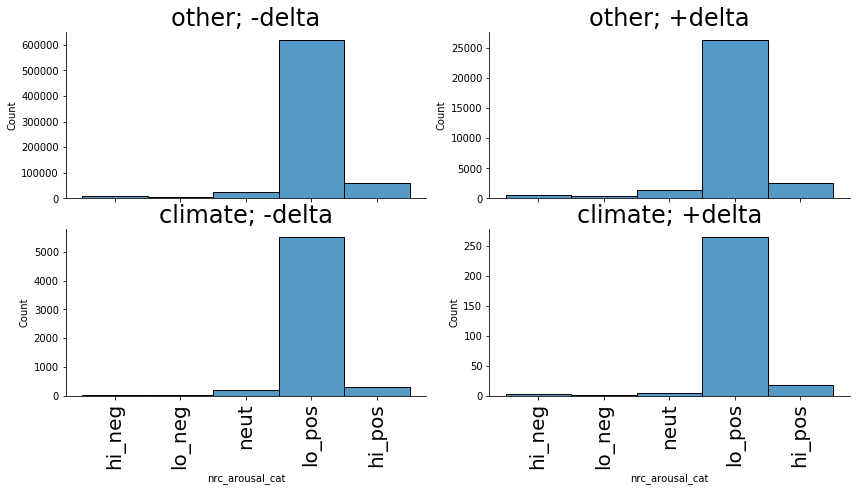

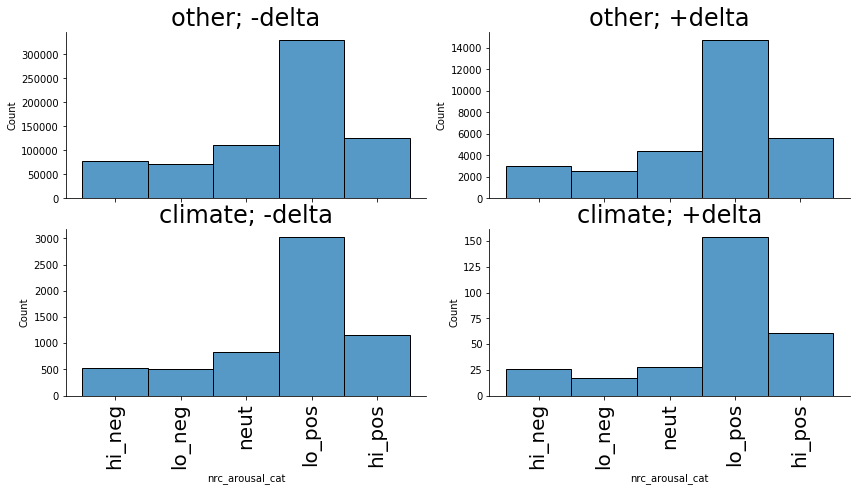

In [116]:
# Fig 5: Distribution of NRC VAD arousal categories for comments
for corp_name in corp_to_analyze:
    if 'cmv' in corp_name:
        for model_name in ['all','adxs_only']:
        
            # prep data to plot
            to_plot_df = pd.DataFrame({
                'is_awarded_delta': [utt.meta['is_awarded_delta']
                                     for utt in corp_to_analyze[corp_name].iter_utterances()
                                     if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                     and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'nrc_arousal_cat': [utt.meta[f'nrc_{model_name}_arousal_cat']
                                    for utt in corp_to_analyze[corp_name].iter_utterances()
                                    if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                    and utt.meta[f'nrc_{model_name}_arousal_cat']],
                'is_cc_related': [utt.meta['is_cc_related']
                                  for utt in corp_to_analyze[corp_name].iter_utterances()
                                  if f'nrc_{model_name}_arousal_cat' in utt.meta 
                                  and utt.meta[f'nrc_{model_name}_arousal_cat']]})
            to_plot_df['nrc_arousal_cat'] = \
            pd.Categorical(to_plot_df['nrc_arousal_cat'],
            categories=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            ordered=True)

            # plotting
            g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="is_cc_related", 
                              sharey=False, aspect=2)
            g.map(sns.histplot, "nrc_arousal_cat")

            # aesthetics
            for ax in g.axes.ravel():
                title = ax.get_title()
                is_cc_related = title.split(' |')[0].split('= ')[-1]
                is_awarded_delta = title.split('| ')[-1].split('= ')[-1]
                if is_cc_related == 'True':
                    pretty_title = 'climate; '
                else:
                    pretty_title = 'other; '
                if is_awarded_delta == 'True':
                    pretty_title += '+delta'
                else:
                    pretty_title += '-delta'
                ax.set_title(pretty_title, fontsize=24)
                ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)

            # saving
            plt.savefig(f'figs/nrc_arousal_dist_deltas_vs_no_deltas_{corp_name}_{model_name}.png',
                       dpi=150,bbox_inches="tight")

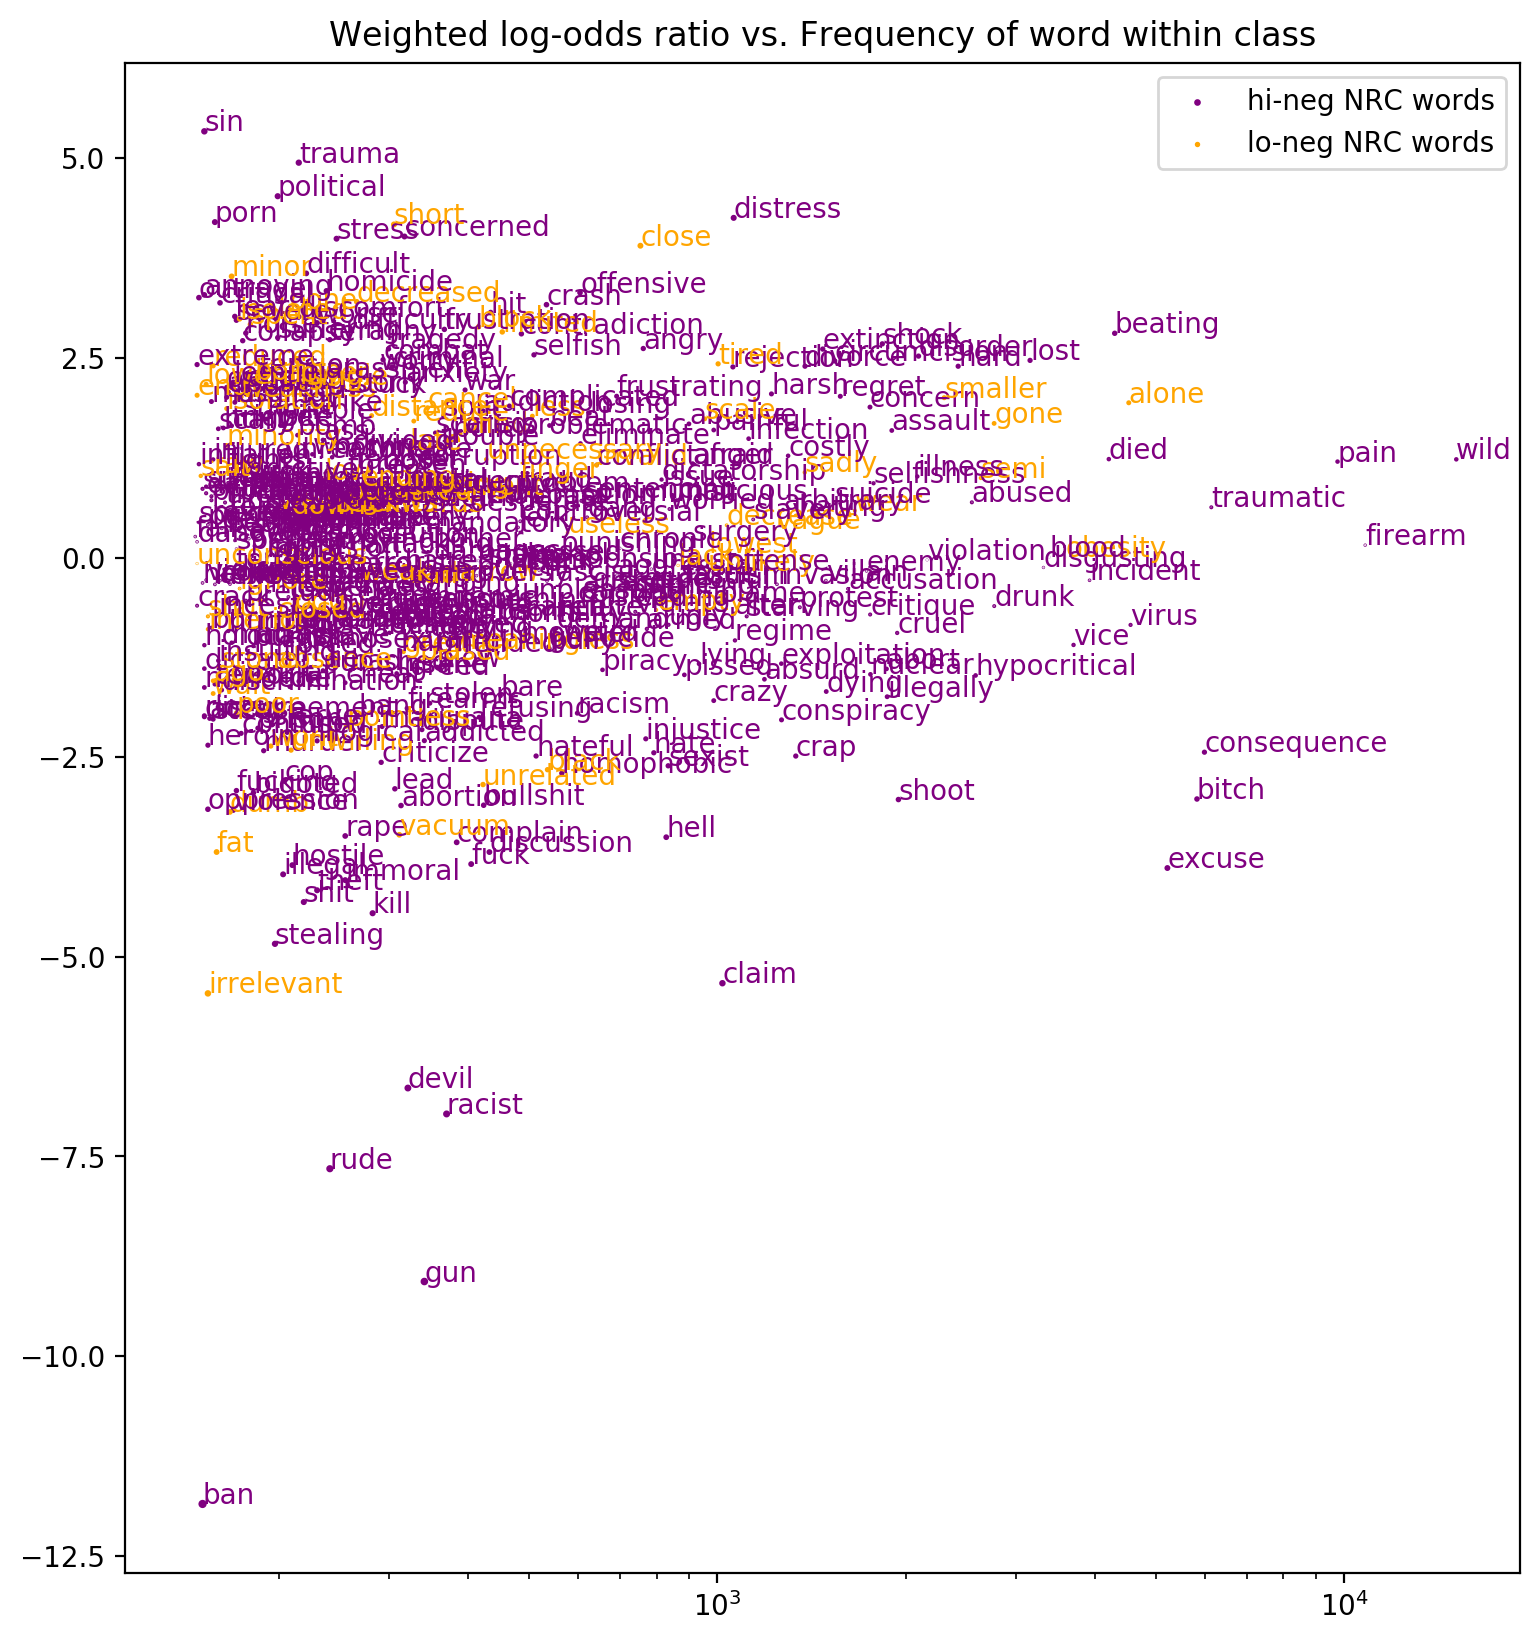

In [32]:
# no annotations of words or non-of-interest words--too crowded
fw_all_topics_no_bots.plot_fighting_words_fancy(class1_name='hi-neg NRC words', 
                                                class2_name='lo-neg NRC words', 
                                 config={'threshold': 1.96, 'annot_method': 'custom'},
                                word_set1=NRC_words_per_cat['hi_neg'],
                                word_set2=NRC_words_per_cat['lo_neg'],
                                verbose=True)

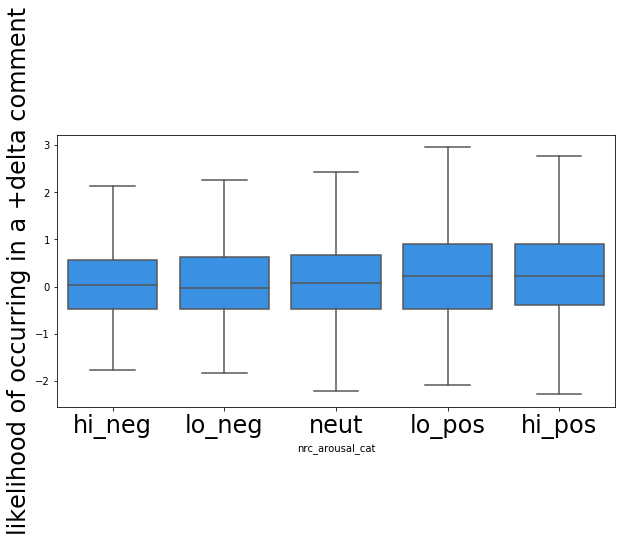

In [211]:
for corp_name in corp_to_analyze:
    #for model_name in ['all','adxs_only']:
    to_plot_df = pd.DataFrame({
        'z-score': [lor_per_corp[corp_name]['weighted_bare'][w]
                    for w in lor_per_corp[corp_name]['weighted_bare']],
        'nrc_arousal_cat': [word2NRC_cat[w]
                            if w in word2NRC_cat else None
                            for w in lor_per_corp[corp_name]['weighted_bare']]
    })
    
    sns.boxplot(data=to_plot_df,
            x='nrc_arousal_cat',y='z-score',
            order=['hi_neg','lo_neg','neut','lo_pos','hi_pos'],
            showfliers=False,color='dodgerblue')
    plt.ylabel("likelihood of occurring in a +delta comment",fontsize=24)
    plt.xticks(fontsize=24)
    plt.savefig(f'figs/lor_per_nrc_arousal_cat_{corp_name}.png',
                dpi=150,bbox_inches="tight")

In [76]:
# Check LOR values for words of derived NRC arousal cats
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_neg'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_neg'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['hi_pos'])][::-1]

In [ ]:
#df_all_topics_no_bots.loc[df_all_topics_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-2]

In [ ]:
#df_cc_no_bots.loc[df_cc_no_bots.index.isin(NRC_words_per_cat['lo_pos'])][::-1]

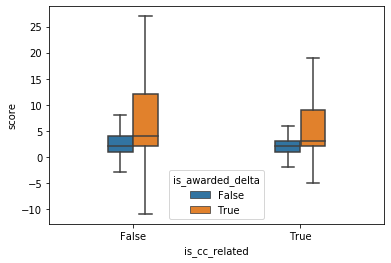

In [51]:
# Is score of a comment related to whether or not it gets a delta?
to_plot_df = pd.DataFrame({
    'is_awarded_delta': [utt.meta['is_awarded_delta']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'score': [utt.meta['score']
                        for utt in filtered_cmv_subsample.iter_utterances()],
    'is_cc_related': [utt.meta['is_cc_related']
                        for utt in filtered_cmv_subsample.iter_utterances()]
})

sns.boxplot(data=to_plot_df, x='is_cc_related', y='score', showfliers=False, width=0.3,
           hue='is_awarded_delta')

##### RQ3: Do emotions matter for deltas?

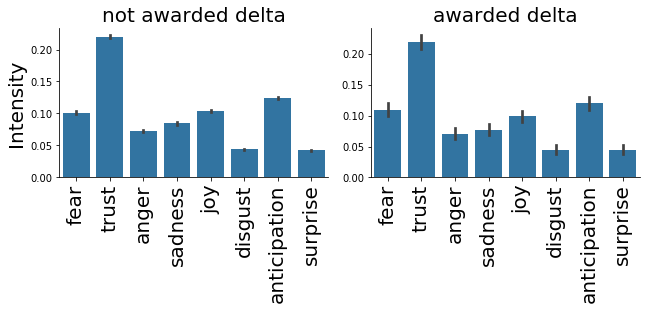

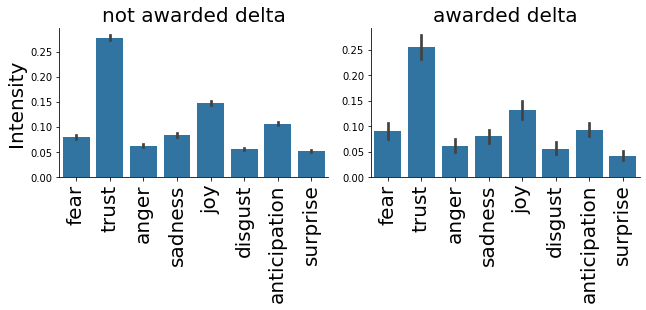

In [142]:
for corp_name in corp_to_analyze:

    years = list(range(2013,2022))
    topics = ['climate change','other']
    emotions = EMOLEX_EMOS
    for model_name in ['all','adxs_only']:
        df_year, df_topic, df_emo, df_emoscore = [], [], [], []
        df_id, df_contro, df_replies, df_score = [], [], [], []
        df_nrc_arousal, df_pos_arousal, df_neg_arousal = [], [], []
        df_delta = []
        for utt in corp_to_analyze[corp_name].iter_utterances():
            if utt.timestamp and utt.id[:2] != 't3':
                year = datetime.utcfromtimestamp(utt.timestamp).year
                topic = 'climate change' if utt.meta['is_cc_related'] else 'other'
                for key in utt.meta.keys():
                    if key.startswith(f'emolex_{model_name}'):
                        emo = key.split('_')[-1]
                        score = utt.meta[f'emolex_{model_name}_{emo}']
                        df_year.append(year)
                        df_topic.append(topic)
                        df_emo.append(emo)
                        df_emoscore.append(score)
                        df_id.append(utt.id)
                        df_contro.append(utt.meta['controversiality'])
                        df_replies.append(len(utt.meta['reply_ids']))
                        df_score.append(utt.meta['score'])
                        df_nrc_arousal.append(utt.meta[f'nrc_{model_name}_arousal_cat'])
                        senti_cat = utt.meta[f'senti_{model_name}_arousal_cat']
                        df_pos_arousal.append(senti_cat.split('_pos')[0].split('_')[-1])
                        df_neg_arousal.append(senti_cat.split('_neg')[0].split('_')[-1])
                        df_delta.append(utt.meta['is_awarded_delta'])
        to_plot_df = pd.DataFrame({
            'year':df_year,
            'topic':df_topic,
            'emotion':df_emo,
            'emoscore':df_emoscore,
            'id':df_id,
            'contro':df_contro,
            'num_replies':df_replies,
            'score':df_score,
            'nrc_arousal':df_nrc_arousal,
            'pos_arousal':df_pos_arousal,
            'neg_arousal':df_neg_arousal,
            'is_awarded_delta':df_delta
        })

#         g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", row="emotion", sharey=False, aspect=1.5)
#         g.map(sns.histplot, "emoscore")
        
        g = sns.FacetGrid(to_plot_df, col="is_awarded_delta", sharey=False, aspect=1.5)
        g.map(sns.barplot, "emotion", "emoscore", order=EMOLEX_EMOS)
        for ax_ix,ax in enumerate(g.axes[0]):
            ax.set_xticklabels(ax.get_xticklabels(),rotation=90,fontsize=20)
            ax.set_xlabel("")
            if ax_ix == 0:
                ax.set_ylabel("Intensity",fontsize=20)
            ax.set_title("not "[:4*(not (ax.get_title().split(' = ')[-1] == 'True'))] \
                         + "awarded delta",fontsize=20)
        plt.savefig(f'figs/emo_dist_deltas_v_no_deltas_{corp_name}_{model_name}.png',
                    dpi=150,bbox_inches="tight")

# Hypothesis: engaging with opponent is good strategy (agree > disagree chains)

Already tested in other paper and found to be ineffective.

# User-level analysis

In [16]:
# Update speaker-meta w/ cached files
for corp_name in corp_to_analyze:
    user_comments = pickle.load(open(f'{corp_name}_comments_per_speaker.pkl','rb'))
    convo_speaker_ids = [convo.speaker.id for convo in corp_to_analyze[corp_name].iter_utterances()
                            if convo.id[:2]=='t3']

    for speaker_id in tqdm(convo_speaker_ids):
        if speaker_id in user_comments:
            corp_to_analyze[corp_name].get_speaker(speaker_id).add_meta('comments', user_comments[speaker_id])
        else:
            corp_to_analyze[corp_name].get_speaker(speaker_id).add_meta('comments', [])

100%|██████████| 26221/26221 [00:00<00:00, 111098.27it/s]


See if we can use user-subreddit activity as proxy for stance:

Approach 1: R if user comments more in R-leaning subs; same for L.

In [21]:
import praw
from praw.models import Submission
from prawcore.exceptions import Forbidden,NotFound

reddit = praw.Reddit(client_id='ACEORGSlEeJyQhPyNRAUiA',
                     client_secret='xGN33fztXu_4jiOek_RHUtMGhHXAcQ',
                     user_agent='me',
                    password='redditC0bintr@sena',
                    username='Western-Wishbone573')
print(reddit.user.me())

Version 7.4.0 of praw is outdated. Version 7.5.0 was released 1 day ago.


Western-Wishbone573


In [ ]:
for corp_name in corp_to_analyze:
    user_comments = pickle.load(open(f'{corp_name}_comments_per_speaker.pkl','rb'))
    for speaker_id in tqdm(user_comments):
        comment_subs = []
        for c_id in tqdm(user_comments[speaker_id]):
            comment_subs.append(reddit.comment(id=c_id).subreddit.display_name)
        corp_to_analyze[corp_name].get_speaker(speaker_id).add_meta('comment_subs', comment_subs)
        
#sorted(Counter(user_comment_subs).items(),key=lambda x:x[1],reverse=True)

 31%|███       | 309/997 [04:57<11:33,  1.01s/it]


 33%|███▎      | 330/997 [05:18<10:14,  1.09it/s]

In [43]:
len(user_comments[speaker_id])

597

In [42]:
[reddit.comment(id=c_id).subreddit.display_name
                           for c_id in user_comments[speaker_id]]

KeyboardInterrupt: 

In [19]:
for corp_name in corp_to_analyze:
    user_comments = pickle.load(open(f'{corp_name}_comments_per_speaker.pkl','rb'))
    for speaker_id in tqdm(user_comments):
        corp_to_analyze[corp_name].get_speaker(speaker_id).meta['comment_subs']

['RoyalWait', 'EconomistAnonymous']

In [20]:
user_comments['EconomistAnonymous']

['cktrg7f',
 'cktrg5j',
 'cktqf3j',
 'cktpvli',
 'ckpvvu1',
 'ckpucmm',
 'ckptxe4',
 'ckpcuhc',
 'ckpbje8',
 'ckon8ez',
 'ckon8aw',
 'cknoeec',
 'cknluqu',
 'cknlnqa',
 'cknlc7d',
 'cknl6gy',
 'cknl2hj',
 'cknktva']

In [39]:
[reddit.comment(id=c_id).subreddit.display_name
for c_id in user_comments['EconomistAnonymous']]

['changemyview',
 'changemyview',
 'badeconomics',
 'badeconomics',
 'changemyview',
 'badeconomics',
 'changemyview',
 'badeconomics',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview',
 'changemyview']

In [ ]:
R_subs = {}
L_subs = {}

def get_op_leaning(user_id):
    user_comms = user_comments[user_id]
    user_comm_subs = [x.subreddit.display_name for x in user_comms]
    user_R_subs = [x for x in user_comm_subs if x in R_subs]
    user_L_subs = [x for x in user_comm_subs if x in L_subs]
    if len(user_R_subs) > len(user_L_subs):
        return 'r'
    elif len(user_L_subs) > len(user_R_subs):
        return 'l'
    else:
        return 'n'

# Topic analysis

## Why do "doom people" think we're doomed?